# Mean-Variance Optimization (MVO) Analysis
This notebook performs a comprehensive analysis of Mean-Variance Optimization strategies, including classical MVO, Bayesian approaches (Diffuse Prior, Conjugate NIW Priors, Bayesian CAPM), backtesting, and sensitivity analysis. It utilizes custom utility modules for data loading, optimization, Bayesian estimation, backtesting, and plotting.

In [1]:
# --- Standard Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats  # For normality tests
import os  # For creating output directories
import sys  # For path manipulations

# --- Custom Utility Module Imports ---
from utils import data_loader
from utils import portfolio_optimizers
from utils import bayesian_estimators
from utils import backtesting_engine
from utils import plotting_utils

# Configure matplotlib for inline plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

# --- Add custom modules to path and import new estimator ---
# Handle Tests/ subdirectory regardless of CWD

potential_paths = [
    os.path.join(os.getcwd(), 'Tests'),            # If CWD is 'Code/'
    os.path.join(os.getcwd(), 'Code', 'Tests')     # If CWD is project root
]

actual_tests_path = None
for p in potential_paths:
    if os.path.isdir(p):
        actual_tests_path = os.path.abspath(p)
        break

if actual_tests_path and actual_tests_path not in map(os.path.abspath, sys.path):
    sys.path.insert(0, actual_tests_path)
    print(f"Added to sys.path: {actual_tests_path}")
else:
    simple_tests_path = os.path.abspath('Tests')
    if os.path.isdir(simple_tests_path) and simple_tests_path not in map(os.path.abspath, sys.path):
        sys.path.insert(0, simple_tests_path)
        print(f"Added to sys.path (fallback): {simple_tests_path}")
    elif not actual_tests_path:
        print("Warning: Could not reliably find 'Tests' directory to add to sys.path. Imports might fail.")

from mixed_strategy_estimators import bayes_niw_with_mixed_hist_capm_prior_moments

print("Libraries and utility modules imported, including mixed_strategy_estimators.")


Code/utils/data_loader.py created.
Code/utils/portfolio_optimizers.py created.
Code/utils/bayesian_estimators.py created.
Code/utils/backtesting_engine.py created.
Code/utils/plotting_utils.py created with initial set of plotting functions.
Additional plotting functions appended to Code/utils/plotting_utils.py
Added to sys.path: /Users/andreavento/Documents/Tesi/Thesis/Code/Tests
Libraries and utility modules imported, including mixed_strategy_estimators.


## Configuration
Defines file paths for input datasets, output directories for plots and results, and key parameters for the analysis.

In [2]:
# --- Input Data Paths ---
BASE_DATA_PATH = '../Data/' 

FINAL_STOCKS_PATH = os.path.join(BASE_DATA_PATH, 'final_dataset_stocks.csv')
FINAL_BONDS_PATH = os.path.join(BASE_DATA_PATH, 'final_dataset_bonds.csv') 
SP500_BENCHMARK_PATH = os.path.join(BASE_DATA_PATH, 'SP_500_benchmark.csv')
RF_MAIN_PATH = os.path.join(BASE_DATA_PATH, '3-month_T_bill.csv')

HISTORICAL_RETURNS_PATH = os.path.join(BASE_DATA_PATH, 'historical_before2008_returns.csv')
HISTORICAL_RF_PATH = os.path.join(BASE_DATA_PATH, 'DGS1MO-2.csv')
HISTORICAL_SP500_BENCHMARK_PATH = os.path.join(BASE_DATA_PATH, 'SP_500_benchmark_presample.csv')

# --- Output Directories ---
PLOTS_DIR = 'plots_output/'
RESULTS_DIR = 'results_output/'

os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"Output plots will be saved to: {os.path.abspath(PLOTS_DIR)}")
print(f"Output results (CSVs) will be saved to: {os.path.abspath(RESULTS_DIR)}")

# --- General Analysis Parameters ---
MAIN_RF_START_DATE = "2008-01-31"
MAIN_RF_END_DATE = "2022-12-31"
HISTORICAL_RF_START_DATE = "2002-01-31"
HISTORICAL_RF_END_DATE = "2007-12-31"
RISK_FREE_RATE_FOR_SHARPE = 0.0 

NAME_TO_TICKER_MAP = {
    'A T & T INC': 'T', 'ALPHABET INC': 'GOOGL', 'ALTRIA GROUP INC': 'MO',
    'AMERICAN INTERNATIONAL GROUP INC': 'AIG', 'APPLE INC': 'AAPL', 'BANK OF AMERICA CORP': 'BAC',
    'BERKSHIRE HATHAWAY INC DEL': 'BRK.B', 'CHEVRON CORP NEW': 'CVX', 'CISCO SYSTEMS INC': 'CSCO',
    'CITIGROUP INC': 'C', 'COCA COLA CO': 'KO', 'EXXON MOBIL CORP': 'XOM',
    'GENERAL ELECTRIC CO': 'GE', 'INTEL CORP': 'INTC', 'INTERNATIONAL BUSINESS MACHS COR': 'IBM',
    'JOHNSON & JOHNSON': 'JNJ', 'MICROSOFT CORP': 'MSFT', 'PFIZER INC': 'PFE',
    'PROCTER & GAMBLE CO': 'PG', 'WALMART INC': 'WMT', 'b20ret': 'BOND20'
}

# --- Backtesting Parameters ---
ESTIMATION_WINDOW = 60 
HOLDING_PERIOD = 2 
RISK_LIMIT_TARGET_VOL = 0.03 

# --- Plotting Parameters ---
DEFAULT_FIG_SIZE = (12, 6) 
print("Configuration parameters set.")

Output plots will be saved to: /Users/andreavento/Documents/Tesi/Thesis/Code/plots_output
Output results (CSVs) will be saved to: /Users/andreavento/Documents/Tesi/Thesis/Code/results_output
Configuration parameters set.


## 1. Data Loading & Initial Preprocessing
This section loads the necessary financial data for the analysis. This includes:
- Core asset returns (stocks and bonds).
- S&P 500 benchmark returns.
- Risk-free rates (e.g., 3-month Treasury bill rates).

The data is then preprocessed, which involves aligning dates, handling missing values (if any within the loader functions), and calculating excess returns.

In [3]:
# --- Load Core Asset Returns, Benchmark, and Risk-Free Rates ---
print("--- Loading Core Data ---")
core_returns_df = data_loader.load_core_asset_returns(
    FINAL_STOCKS_PATH, FINAL_BONDS_PATH, NAME_TO_TICKER_MAP
)
print("Core asset returns (stocks & bonds merged, tickers mapped):")
display(core_returns_df.head())

benchmark_returns_series = data_loader.load_benchmark_returns(
    SP500_BENCHMARK_PATH, core_returns_df.index # Align benchmark to core returns index
)
benchmark_returns_series.name = "S&P 500" # Set name for easier reference
print("\nS&P 500 Benchmark returns (aligned):")
display(benchmark_returns_series.head())

risk_free_series = data_loader.load_risk_free_rates(
    RF_MAIN_PATH, MAIN_RF_START_DATE, MAIN_RF_END_DATE, core_returns_df.index # Align to core returns index
)
risk_free_series.name = "Risk-Free Rate"
print("\nRisk-free rates (aligned):")
display(risk_free_series.head())

# --- Calculate Excess Returns ---
excess_returns_df = data_loader.calculate_excess_returns(core_returns_df, risk_free_series)
print("\nExcess asset returns:")
display(excess_returns_df.head())

benchmark_excess_returns_series = data_loader.calculate_excess_returns(
    benchmark_returns_series.to_frame(), 
    risk_free_series
)[benchmark_returns_series.name] 
benchmark_excess_returns_series.name = "S&P 500 Excess Return"
print("\nS&P 500 Benchmark excess returns:")
display(benchmark_excess_returns_series.head())

core_returns_df.to_csv(os.path.join(RESULTS_DIR, "core_returns_df.csv"))
excess_returns_df.to_csv(os.path.join(RESULTS_DIR, "excess_returns_df.csv"))
benchmark_returns_series.to_csv(os.path.join(RESULTS_DIR, "benchmark_returns_series.csv"))
risk_free_series.to_csv(os.path.join(RESULTS_DIR, "risk_free_series.csv"))
print(f"\nCore data (returns, excess returns, benchmark, rf) saved to CSV files in {RESULTS_DIR}")

--- Loading Core Data ---
Core asset returns (stocks & bonds merged, tickers mapped):


T     GOOGL        MO       AIG      AAPL       BAC  \
2008-01-31 -0.064244 -0.183924  0.002779 -0.057118 -0.316640  0.070044   
2008-02-29 -0.095090 -0.165019 -0.034965 -0.147535 -0.076389 -0.099887   
2008-03-31  0.099627 -0.065177  0.005332 -0.072770  0.147816 -0.029945   
2008-04-30  0.021149  0.303812 -0.099099  0.068208  0.212195 -0.009760   
2008-05-30  0.030741  0.020042  0.113000 -0.220779  0.085082 -0.094033   

               BRK.B       CVX      CSCO         C  ...       XOM        GE  \
2008-01-31 -0.039548 -0.108004 -0.094936 -0.032269  ... -0.077810 -0.046129   
2008-02-29  0.029412  0.047928 -0.004490 -0.158324  ...  0.011111 -0.054016   
2008-03-31 -0.047143 -0.015001 -0.012300 -0.096584  ... -0.027928  0.116777   
2008-04-30  0.003373  0.126406  0.064342  0.179739  ...  0.100378 -0.116455   
2008-05-30  0.005977  0.037962  0.042122 -0.121092  ... -0.042011 -0.060551   

                INTC       IBM       JNJ      MSFT       PFE        PG  \
2008-01-31 -0.208552 -0.009158 -0.053373 -0.084270  0.027717 -0.104195   
2008-02-29 -0.047517  0.066754 -0.012116 -0.162273 -0.032534  0.011617   
2008-03-31  0.060596  0.011242  0.046966  0.043386 -0.060592  0.058779   
2008-04-30  0.050991  0.048289  0.034222  0.004933 -0.039178 -0.037391   
2008-05-30  0.047619  0.076471  0.001640 -0.003156 -0.021382 -0.014914   

                 WMT    BOND20  
2008-01-31  0.067536  0.025689  
2008-02-29 -0.022665  0.000404  
2008-03-31  0.067100  0.012042  
2008-04-30  0.100607 -0.018873  
2008-05-30 -0.000043 -0.029605  

[5 rows x 21 columns]


S&P 500 Benchmark returns (aligned):


2008-01-31   -0.061163
2008-02-29   -0.034761
2008-03-31   -0.005960
2008-04-30    0.047547
2008-05-30    0.010674
Name: S&P 500, dtype: float64


Risk-free rates (aligned):


2008-01-31    0.002300
2008-02-29    0.001367
2008-03-31    0.001725
2008-04-30    0.001017
2008-05-30    0.001017
Name: Risk-Free Rate, dtype: float64


Excess asset returns:


T     GOOGL        MO       AIG      AAPL       BAC  \
2008-01-31 -0.066544 -0.186224  0.000479 -0.059418 -0.318940  0.067744   
2008-02-29 -0.096457 -0.166386 -0.036332 -0.148902 -0.077756 -0.101254   
2008-03-31  0.097902 -0.066902  0.003607 -0.074495  0.146091 -0.031670   
2008-04-30  0.020132  0.302795 -0.100116  0.067191  0.211178 -0.010777   
2008-05-30  0.029724  0.019025  0.111983 -0.221796  0.084065 -0.095050   

               BRK.B       CVX      CSCO         C  ...       XOM        GE  \
2008-01-31 -0.041848 -0.110304 -0.097236 -0.034569  ... -0.080110 -0.048429   
2008-02-29  0.028045  0.046561 -0.005857 -0.159691  ...  0.009744 -0.055383   
2008-03-31 -0.048868 -0.016726 -0.014025 -0.098309  ... -0.029653  0.115052   
2008-04-30  0.002356  0.125389  0.063325  0.178722  ...  0.099361 -0.117472   
2008-05-30  0.004960  0.036945  0.041105 -0.122109  ... -0.043028 -0.061568   

                INTC       IBM       JNJ      MSFT       PFE        PG  \
2008-01-31 -0.210852 -0.011458 -0.055673 -0.086570  0.025417 -0.106495   
2008-02-29 -0.048884  0.065387 -0.013483 -0.163640 -0.033901  0.010250   
2008-03-31  0.058871  0.009517  0.045241  0.041661 -0.062317  0.057054   
2008-04-30  0.049974  0.047272  0.033205  0.003916 -0.040195 -0.038408   
2008-05-30  0.046602  0.075454  0.000623 -0.004173 -0.022399 -0.015931   

                 WMT    BOND20  
2008-01-31  0.065236  0.023389  
2008-02-29 -0.024032 -0.000963  
2008-03-31  0.065375  0.010317  
2008-04-30  0.099590 -0.019890  
2008-05-30 -0.001060 -0.030622  

[5 rows x 21 columns]


S&P 500 Benchmark excess returns:


2008-01-31   -0.063463
2008-02-29   -0.036128
2008-03-31   -0.007685
2008-04-30    0.046530
2008-05-30    0.009657
Name: S&P 500 Excess Return, dtype: float64


Core data (returns, excess returns, benchmark, rf) saved to CSV files in results_output/


The tables above show the head of the loaded and processed datasets:
- **Core asset returns**: Monthly total returns for the selected stocks and the bond asset.
- **S&P 500 Benchmark returns**: Monthly total returns for the S&P 500 index, aligned with the asset data.
- **Risk-free rates**: Monthly risk-free rates, aligned with the asset data.
- **Excess asset returns**: Calculated as `core returns - risk-free rate`.
- **S&P 500 Benchmark excess returns**: Calculated as `benchmark returns - risk-free rate`.

These datasets form the primary inputs for the subsequent portfolio optimization and analysis steps.

### 1.1. Initial Exploratory Data Analysis (EDA)
Visualizing the cumulative performance and annualized returns of the assets and the benchmark.

--- Generating Cumulative Wealth Plot ---
Assets selected for highlighting in cumulative wealth plot: ['AAPL', 'MSFT', 'GOOGL', 'AIG', 'C']
Plot saved to plots_output/cumulative_wealth_vs_benchmark.png


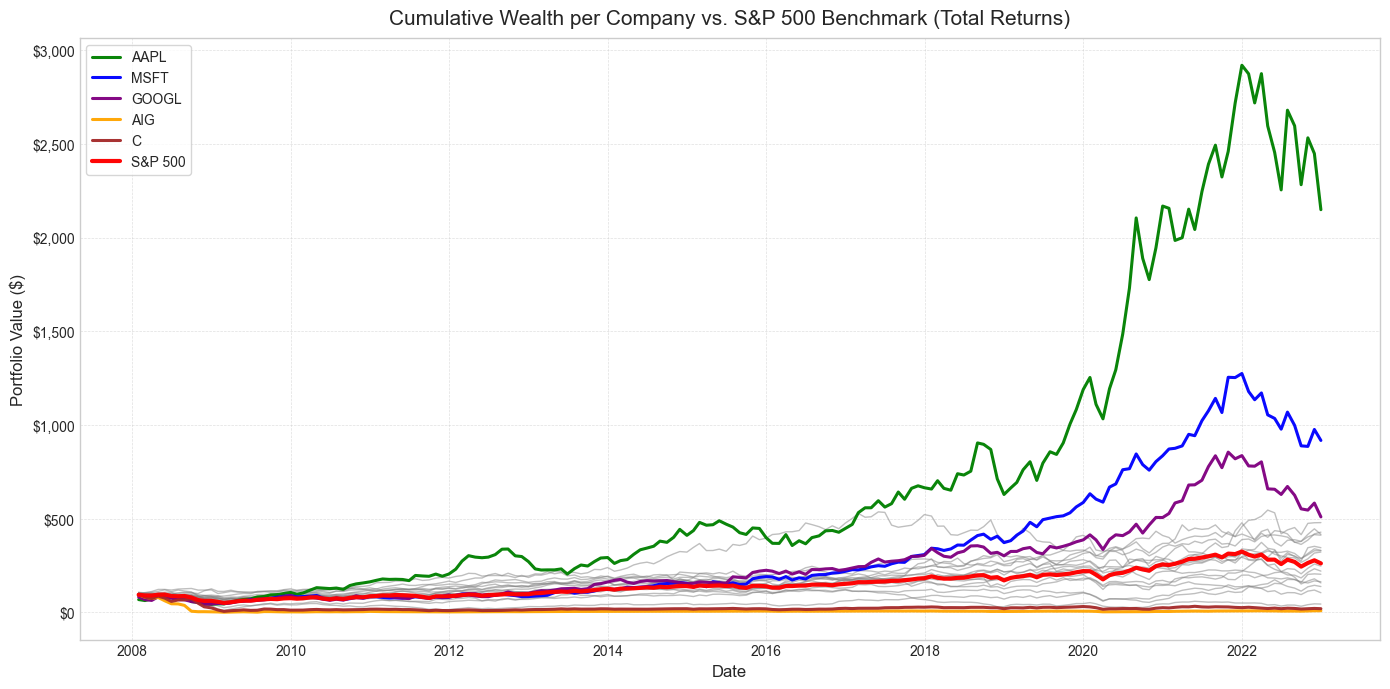

In [4]:
# --- Cumulative Wealth Plot ---
print("--- Generating Cumulative Wealth Plot ---")
wealth_df = (1 + core_returns_df).cumprod() * 100
benchmark_wealth_series = (1 + benchmark_returns_series).cumprod() * 100

highlighted_assets_list = None
if not wealth_df.empty:
    final_wealth = wealth_df.iloc[-1].sort_values(ascending=False)
    highlighted_assets_list = []
    if len(final_wealth) >= 1: highlighted_assets_list.append(final_wealth.index[0]) 
    if len(final_wealth) >= 2: highlighted_assets_list.append(final_wealth.index[1]) 
    if len(final_wealth) >= 3: highlighted_assets_list.append(final_wealth.index[2]) 
    if len(final_wealth) >= 4: highlighted_assets_list.append(final_wealth.index[-1])
    if len(final_wealth) >= 5: highlighted_assets_list.append(final_wealth.index[-2])

print(f"Assets selected for highlighting in cumulative wealth plot: {highlighted_assets_list}")

plotting_utils.plot_cumulative_wealth(
    wealth_df, 
    benchmark_series=benchmark_wealth_series, 
    title="Cumulative Wealth per Company vs. S&P 500 Benchmark (Total Returns)",
    highlight_assets=highlighted_assets_list,
    output_path=os.path.join(PLOTS_DIR, "cumulative_wealth_vs_benchmark.png") 
)

The plot above illustrates the growth of a $100 initial investment in each of the selected assets compared to the S&P 500 benchmark over the analysis period. Some top and bottom performers are highlighted for clarity.


--- Generating Annualized Returns Bar Chart ---
Plot saved to plots_output/annualized_returns_bar.png


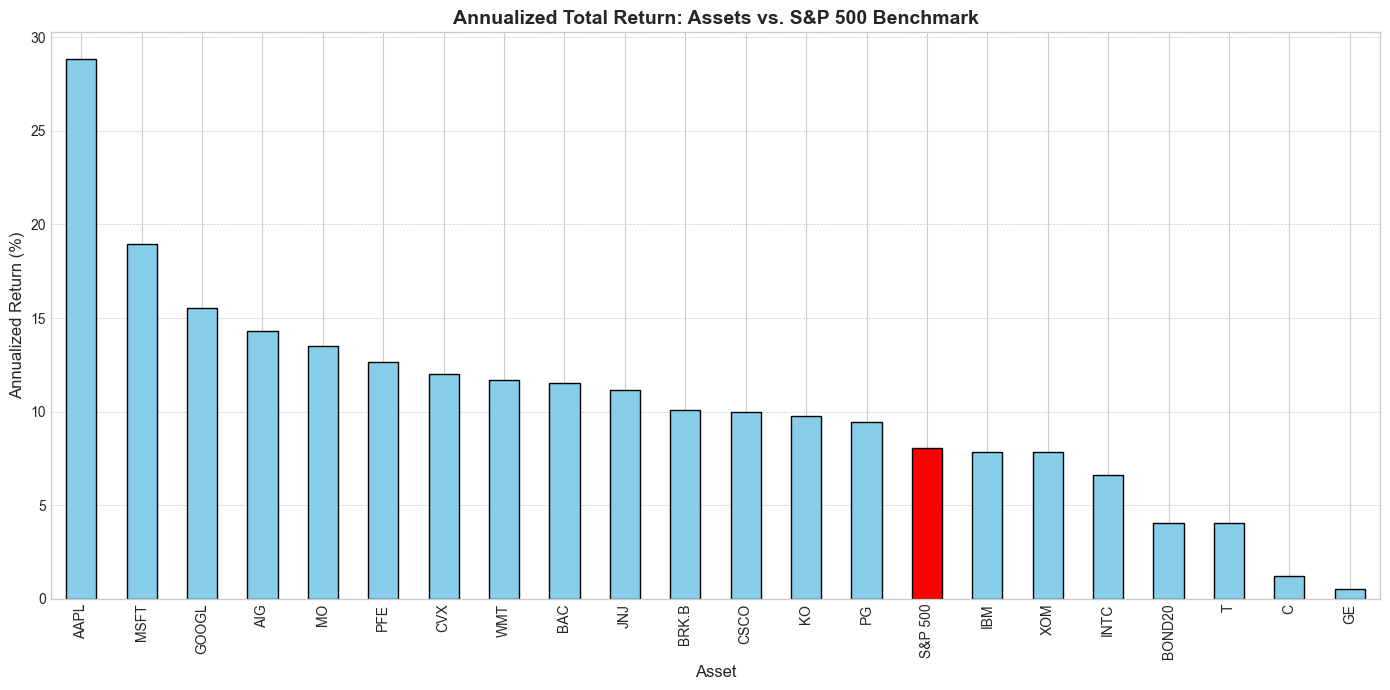

In [5]:
# --- Annualized Returns Bar Chart ---
print("\n--- Generating Annualized Returns Bar Chart ---")
mean_monthly_core_returns = core_returns_df.mean()
mean_monthly_benchmark_return = benchmark_returns_series.mean() 

annualized_core_returns = ((1 + mean_monthly_core_returns) ** 12 - 1) * 100
annualized_benchmark_return = ((1 + mean_monthly_benchmark_return) ** 12 - 1) * 100

plot_ann_returns_data = annualized_core_returns.copy()
plot_ann_returns_data[benchmark_returns_series.name] = annualized_benchmark_return 
plot_ann_returns_data = plot_ann_returns_data.sort_values(ascending=False)

plotting_utils.plot_annualized_returns_bar(
    plot_ann_returns_data,
    benchmark_name=benchmark_returns_series.name, 
    title="Annualized Total Return: Assets vs. S&P 500 Benchmark",
    output_path=os.path.join(PLOTS_DIR, "annualized_returns_bar.png") 
)

This bar chart compares the annualized total returns of each asset against the S&P 500 benchmark. The benchmark is highlighted in red.

## 2. Load Historical Data for Priors
This section loads historical financial data from a period *before* the main analysis window (e.g., 2002-2007). This data is primarily used to inform the priors for some of the Bayesian models implemented later, providing a basis for the expected returns and covariance structure.

In [6]:
# --- Load Historical Asset Returns, Risk-Free Rates, and Calculate Excess Returns ---
print("--- Loading Historical Data for Priors ---")

historical_asset_returns_prior_df = data_loader.load_historical_asset_returns_for_prior(
    HISTORICAL_RETURNS_PATH, 
    target_columns=core_returns_df.columns, 
    start_row=24 
)

if not historical_asset_returns_prior_df.empty:
    print("Historical asset returns for priors loaded:")
    display(historical_asset_returns_prior_df.head())
    historical_asset_returns_prior_df.to_csv(os.path.join(RESULTS_DIR, "historical_asset_returns_prior.csv"))

    historical_rf_prior_series = data_loader.load_historical_risk_free_for_prior(
        HISTORICAL_RF_PATH, 
        HISTORICAL_RF_START_DATE, 
        HISTORICAL_RF_END_DATE, 
        historical_asset_returns_prior_df.index 
    )
    historical_rf_prior_series.name = "Historical Risk-Free Rate"
    print("\nHistorical risk-free rates for priors loaded:")
    display(historical_rf_prior_series.head())
    historical_rf_prior_series.to_csv(os.path.join(RESULTS_DIR, "historical_rf_prior_series.csv"))

    historical_excess_returns_prior_df = data_loader.calculate_excess_returns(
        historical_asset_returns_prior_df, historical_rf_prior_series
    )
    print("\nHistorical excess returns for priors calculated:")
    display(historical_excess_returns_prior_df.head())
    historical_excess_returns_prior_df.to_csv(os.path.join(RESULTS_DIR, "historical_excess_returns_prior.csv"))

    if not historical_excess_returns_prior_df.empty and historical_excess_returns_prior_df.shape[1] > 1:
        sample_historical_covariance_prior = historical_excess_returns_prior_df.cov()
        print("\nSample historical covariance matrix for priors:")
        display(sample_historical_covariance_prior.head())
        sample_historical_covariance_prior.to_csv(os.path.join(RESULTS_DIR, "sample_historical_covariance_prior.csv"))
    else:
        print("\nCould not calculate historical covariance: not enough data or assets.")
        sample_historical_covariance_prior = pd.DataFrame() 
        
else:
    print("Historical asset returns for priors are empty or could not be loaded. Skipping further historical data processing.")
    historical_excess_returns_prior_df = pd.DataFrame()
    sample_historical_covariance_prior = pd.DataFrame()

print(f"\nHistorical prior data processing complete. Relevant files saved to {RESULTS_DIR}")

--- Loading Historical Data for Priors ---
Historical asset returns for priors loaded:


T  GOOGL        MO       AIG      AAPL       BAC     BRK.B  \
2002-01-31 -0.037369    NaN  0.092912 -0.066121  0.128767  0.001271 -0.025501   
2002-02-28  0.010414    NaN  0.050888 -0.001861 -0.122168  0.024116 -0.011797   
2002-03-28 -0.010571    NaN  0.011204 -0.024740  0.090783  0.063643 -0.024560   
2002-04-30 -0.163194    NaN  0.033416 -0.041863  0.025349  0.065569  0.030034   
2002-05-31  0.103992    NaN  0.051810 -0.031105 -0.039967  0.045944  0.015843   

                 CVX      CSCO         C  ...       XOM        GE      INTC  \
2002-01-31 -0.064836  0.093319 -0.057845  ... -0.006361 -0.073104  0.114149   
2002-02-28  0.015990 -0.279293 -0.045359  ...  0.063508  0.041184 -0.184646   
2002-03-28  0.069043  0.186405  0.094365  ...  0.061259 -0.027273  0.065149   
2002-04-30 -0.039437 -0.134672 -0.125606  ... -0.083505 -0.157543 -0.059191   
2002-05-31  0.014301  0.077133  0.001386  ... -0.000249 -0.012995 -0.033904   

                 IBM       JNJ      MSFT       PFE        PG       WMT  \
2002-01-31 -0.108052 -0.026904 -0.038340  0.045671  0.037028  0.042224   
2002-02-28 -0.089258  0.062076 -0.084288 -0.013919  0.038075  0.033845   
2002-03-28  0.059927  0.066502  0.033768 -0.029785  0.062507 -0.010240   
2002-04-30 -0.194615 -0.016782 -0.133477 -0.085305  0.006105 -0.088744   
2002-05-31 -0.037727 -0.036095 -0.025832 -0.044567 -0.007866 -0.031507   

              BOND20  
2002-01-31  0.011488  
2002-02-28  0.012538  
2002-03-28 -0.040447  
2002-04-30  0.040135  
2002-05-31  0.001533  

[5 rows x 21 columns]


Historical risk-free rates for priors loaded:


2002-01-31    0.001400
2002-02-28    0.001408
2002-03-28    0.001408
2002-04-30    0.001467
2002-05-31    0.001475
Name: Historical Risk-Free Rate, dtype: float64


Historical excess returns for priors calculated:


T  GOOGL        MO       AIG      AAPL       BAC     BRK.B  \
2002-01-31 -0.038769    NaN  0.091512 -0.067521  0.127367 -0.000129 -0.026901   
2002-02-28  0.009006    NaN  0.049480 -0.003269 -0.123576  0.022708 -0.013205   
2002-03-28 -0.011979    NaN  0.009796 -0.026148  0.089375  0.062235 -0.025968   
2002-04-30 -0.164661    NaN  0.031949 -0.043330  0.023882  0.064102  0.028567   
2002-05-31  0.102517    NaN  0.050335 -0.032580 -0.041442  0.044469  0.014368   

                 CVX      CSCO         C  ...       XOM        GE      INTC  \
2002-01-31 -0.066236  0.091919 -0.059245  ... -0.007761 -0.074504  0.112749   
2002-02-28  0.014582 -0.280701 -0.046767  ...  0.062100  0.039776 -0.186054   
2002-03-28  0.067635  0.184997  0.092957  ...  0.059851 -0.028681  0.063741   
2002-04-30 -0.040904 -0.136139 -0.127073  ... -0.084972 -0.159010 -0.060658   
2002-05-31  0.012826  0.075658 -0.000089  ... -0.001724 -0.014470 -0.035379   

                 IBM       JNJ      MSFT       PFE        PG       WMT  \
2002-01-31 -0.109452 -0.028304 -0.039740  0.044271  0.035628  0.040824   
2002-02-28 -0.090666  0.060668 -0.085696 -0.015327  0.036667  0.032437   
2002-03-28  0.058519  0.065094  0.032360 -0.031193  0.061099 -0.011648   
2002-04-30 -0.196082 -0.018249 -0.134944 -0.086772  0.004638 -0.090211   
2002-05-31 -0.039202 -0.037570 -0.027307 -0.046042 -0.009341 -0.032982   

              BOND20  
2002-01-31  0.010088  
2002-02-28  0.011130  
2002-03-28 -0.041855  
2002-04-30  0.038668  
2002-05-31  0.000058  

[5 rows x 21 columns]


Sample historical covariance matrix for priors:


T     GOOGL        MO       AIG      AAPL       BAC     BRK.B  \
T      0.005508 -0.000286  0.001605  0.002361  0.001410  0.000999  0.000458   
GOOGL -0.000286  0.014521 -0.000150 -0.000848  0.005028  0.000551  0.000485   
MO     0.001605 -0.000150  0.006527  0.000112  0.002971  0.000883  0.001033   
AIG    0.002361 -0.000848  0.000112  0.004038  0.001215  0.001226  0.000435   
AAPL   0.001410  0.005028  0.002971  0.001215  0.012233  0.000973  0.000303   

            CVX      CSCO         C  ...       XOM        GE      INTC  \
T      0.001151  0.002643  0.002805  ...  0.001554  0.001688  0.002706   
GOOGL -0.000393  0.001068  0.000664  ... -0.000390  0.000428  0.002857   
MO     0.001185  0.000963  0.001007  ...  0.000530  0.000321  0.001788   
AIG    0.001099  0.002169  0.002429  ...  0.001104  0.001381  0.002172   
AAPL   0.002401  0.002071  0.001403  ...  0.002099  0.000199  0.004954   

            IBM           JNJ      MSFT       PFE        PG       WMT  \
T      0.003520  4.779713e-04  0.002437  0.001370  0.000212  0.000664   
GOOGL  0.000200  9.837195e-07  0.002465 -0.001223 -0.000744  0.000820   
MO     0.001295  3.338522e-04 -0.000004  0.000825  0.000300 -0.000753   
AIG    0.002358  4.536385e-04  0.001545  0.000995  0.000395  0.000949   
AAPL   0.002380  3.300686e-04  0.001928  0.000365  0.000102 -0.000058   

         BOND20  
T     -0.000569  
GOOGL  0.000242  
MO     0.000437  
AIG   -0.000572  
AAPL  -0.000377  

[5 rows x 21 columns]


Historical prior data processing complete. Relevant files saved to results_output/


This section has loaded and processed historical data (typically from an earlier period like 2002-2007) for the same set of assets being analyzed in the main period. 
Key outputs include:
- `historical_asset_returns_prior_df`: Historical total returns for the assets.
- `historical_rf_prior_series`: Historical risk-free rates.
- `historical_excess_returns_prior_df`: Historical excess returns for the assets.
- `sample_historical_covariance_prior`: The covariance matrix calculated from these historical excess returns.

These datasets, particularly the historical excess returns and their covariance, can be used to define more informed (less diffuse) priors for Bayesian portfolio optimization models.

## 3. Normality Analysis
This section investigates the distributional properties of asset returns, specifically focusing on whether they conform to a normal distribution. Classical Mean-Variance Optimization (MVO) often assumes normality. We will test this assumption for both raw total returns and log returns.
The `run_normality_tests` function (defined in an earlier cell in this notebook) performs Shapiro-Wilk, Jarque-Bera, and Anderson-Darling tests.

In [7]:
# --- Define run_normality_tests directly in notebook for now --- 
def run_normality_tests(df, label=''):
    """Performs Shapiro-Wilk, Jarque-Bera, and Anderson-Darling tests for normality."""
    results = []
    for col in df.columns:
        data = df[col].dropna()
        if len(data) < 3: 
            print(f"Skipping normality tests for {col} due to insufficient data ({len(data)} samples).")
            continue
        
        shapiro_stat, shapiro_p = stats.shapiro(data)
        jb_stat, jb_p = stats.jarque_bera(data)
        ad_result = stats.anderson(data, dist='norm')
        ad_stat = ad_result.statistic
        ad_crit_val_5_percent = ad_result.critical_values[2] 
        
        results.append({
            'Asset': col,
            'Shapiro_p': shapiro_p,
            'JarqueBera_p': jb_p,
            'AD_stat': ad_stat,
            'AD_5%_crit': ad_crit_val_5_percent,
            'AD_pass_5%': ad_stat < ad_crit_val_5_percent
        })
    
    test_results_df = pd.DataFrame(results)
    if not test_results_df.empty:
        test_results_df['Shapiro_pass_5%'] = test_results_df['Shapiro_p'] > 0.05
        test_results_df['JB_pass_5%'] = test_results_df['JarqueBera_p'] > 0.05
        all_passed_col_name = 'All_Passed_5%'
        all_failed_col_name = 'All_Failed_5%'
        test_results_df[all_passed_col_name] = test_results_df['Shapiro_pass_5%'] & \
                                               test_results_df['JB_pass_5%'] & \
                                               test_results_df['AD_pass_5%']
        test_results_df[all_failed_col_name] = ~test_results_df['Shapiro_pass_5%'] & \
                                               ~test_results_df['JB_pass_5%'] & \
                                               ~test_results_df['AD_pass_5%']
        
        summary_counts = {
            'Total Assets Tested': len(test_results_df),
            'Shapiro Passed (5%)': test_results_df['Shapiro_pass_5%'].sum(),
            'Jarque-Bera Passed (5%)': test_results_df['JB_pass_5%'].sum(),
            'Anderson-Darling Passed (5%)': test_results_df['AD_pass_5%'].sum(),
            'Passed All Tests (5%)': test_results_df[all_passed_col_name].sum(),
            'Failed All Tests (5%)': test_results_df[all_failed_col_name].sum()
        }
        summary_counts['Partial Agreement (5%)'] = summary_counts['Total Assets Tested'] - \
                                                 summary_counts['Passed All Tests (5%)'] - \
                                                 summary_counts['Failed All Tests (5%)']
        summary_df = pd.DataFrame.from_dict(summary_counts, orient='index', columns=[f'{label} Normality Test Counts'])
    else:
        summary_df = pd.DataFrame(columns=[f'{label} Normality Test Counts'])

    return test_results_df, summary_df

print("--- Performing Normality Analysis ---")
log_core_returns_df = np.log(1 + core_returns_df).dropna(how='all') 

print("\nTesting Raw Total Returns for Normality:")
raw_normality_results_df, raw_normality_summary_df = run_normality_tests(core_returns_df, "Raw Total Returns")
if not raw_normality_summary_df.empty:
    display(raw_normality_summary_df)
    raw_normality_results_df.to_csv(os.path.join(RESULTS_DIR, "normality_tests_raw_total_returns.csv"), index=False)
    print(f"Detailed raw returns normality test results saved to {os.path.join(RESULTS_DIR, 'normality_tests_raw_total_returns.csv')}")
else:
    print("Could not generate normality summary for raw returns.")

print("\nTesting Log Total Returns for Normality:")
log_normality_results_df, log_normality_summary_df = run_normality_tests(log_core_returns_df, "Log Total Returns")
if not log_normality_summary_df.empty:
    display(log_normality_summary_df)
    log_normality_results_df.to_csv(os.path.join(RESULTS_DIR, "normality_tests_log_total_returns.csv"), index=False)
    print(f"Detailed log returns normality test results saved to {os.path.join(RESULTS_DIR, 'normality_tests_log_total_returns.csv')}")
else:
    print("Could not generate normality summary for log returns.")

--- Performing Normality Analysis ---

Testing Raw Total Returns for Normality:


Raw Total Returns Normality Test Counts
Total Assets Tested                                                21
Shapiro Passed (5%)                                                 8
Jarque-Bera Passed (5%)                                             7
Anderson-Darling Passed (5%)                                       11
Passed All Tests (5%)                                               6
Failed All Tests (5%)                                               9
Partial Agreement (5%)                                              6

Detailed raw returns normality test results saved to results_output/normality_tests_raw_total_returns.csv

Testing Log Total Returns for Normality:


Log Total Returns Normality Test Counts
Total Assets Tested                                                21
Shapiro Passed (5%)                                                 7
Jarque-Bera Passed (5%)                                             6
Anderson-Darling Passed (5%)                                        9
Passed All Tests (5%)                                               6
Failed All Tests (5%)                                              12
Partial Agreement (5%)                                              3

Detailed log returns normality test results saved to results_output/normality_tests_log_total_returns.csv


The summary tables above indicate how many assets passed or failed each normality test at a 5% significance level. Generally, financial asset returns often exhibit deviations from normality. The detailed results are saved.


--- Plotting Return Distributions ---
Raw returns distribution plot saved to plots_output/return_histograms_total_raw.png


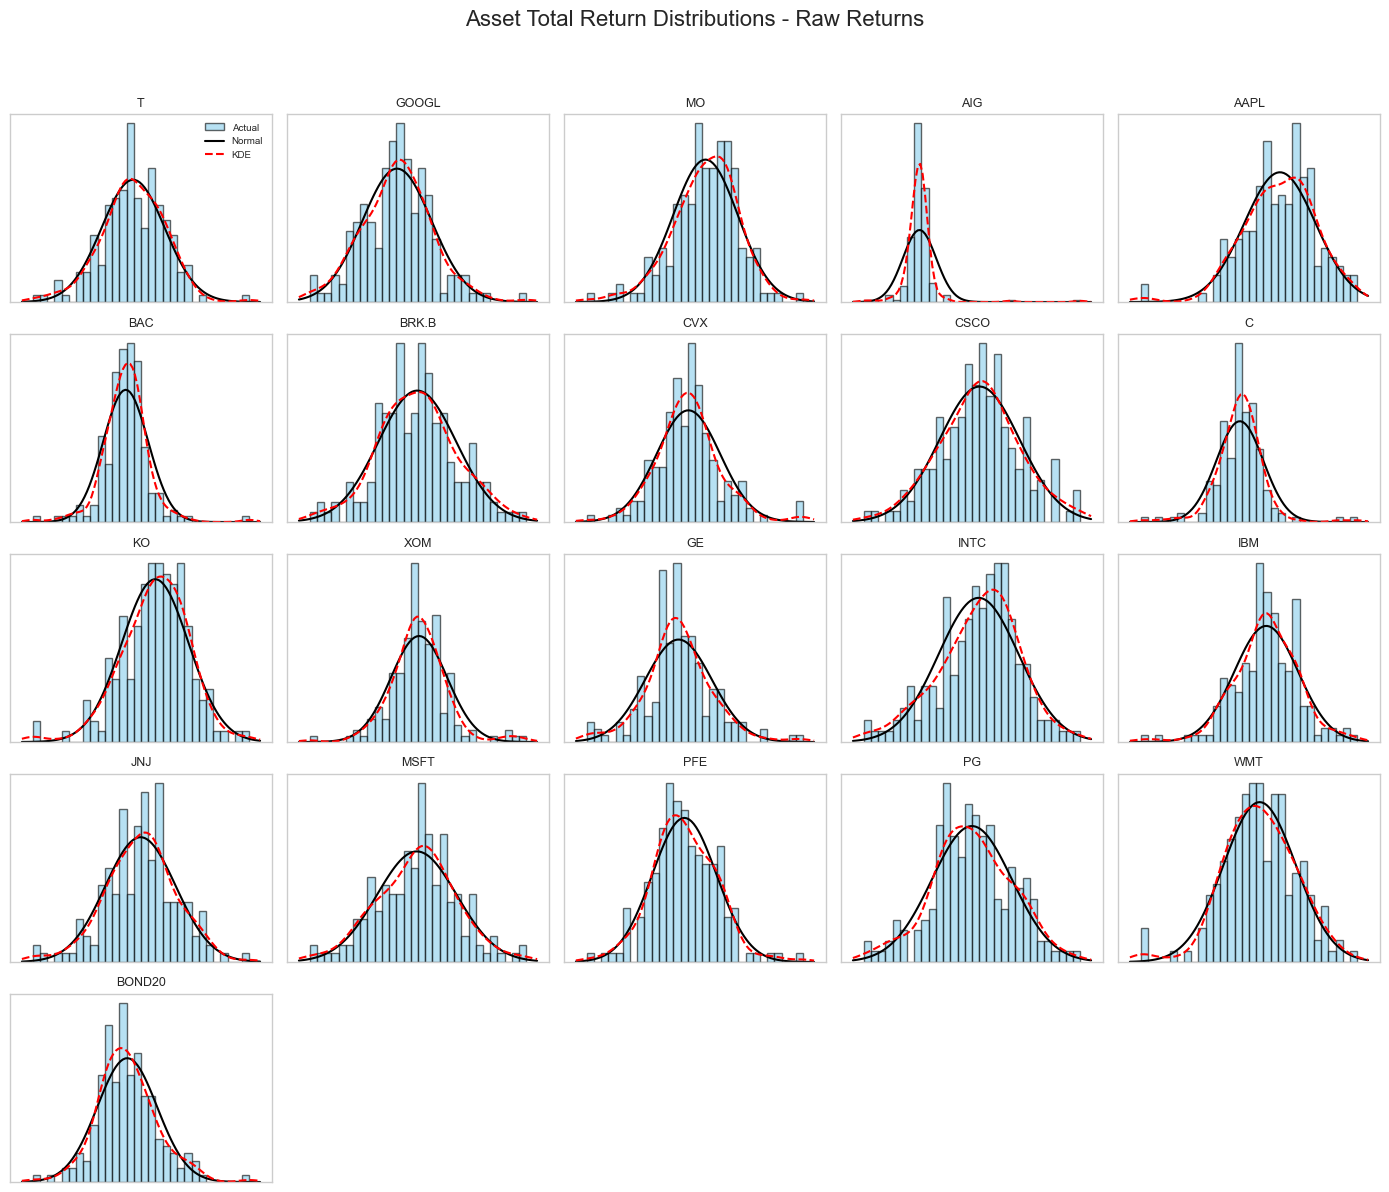

Log returns distribution plot saved to plots_output/return_histograms_total_log.png


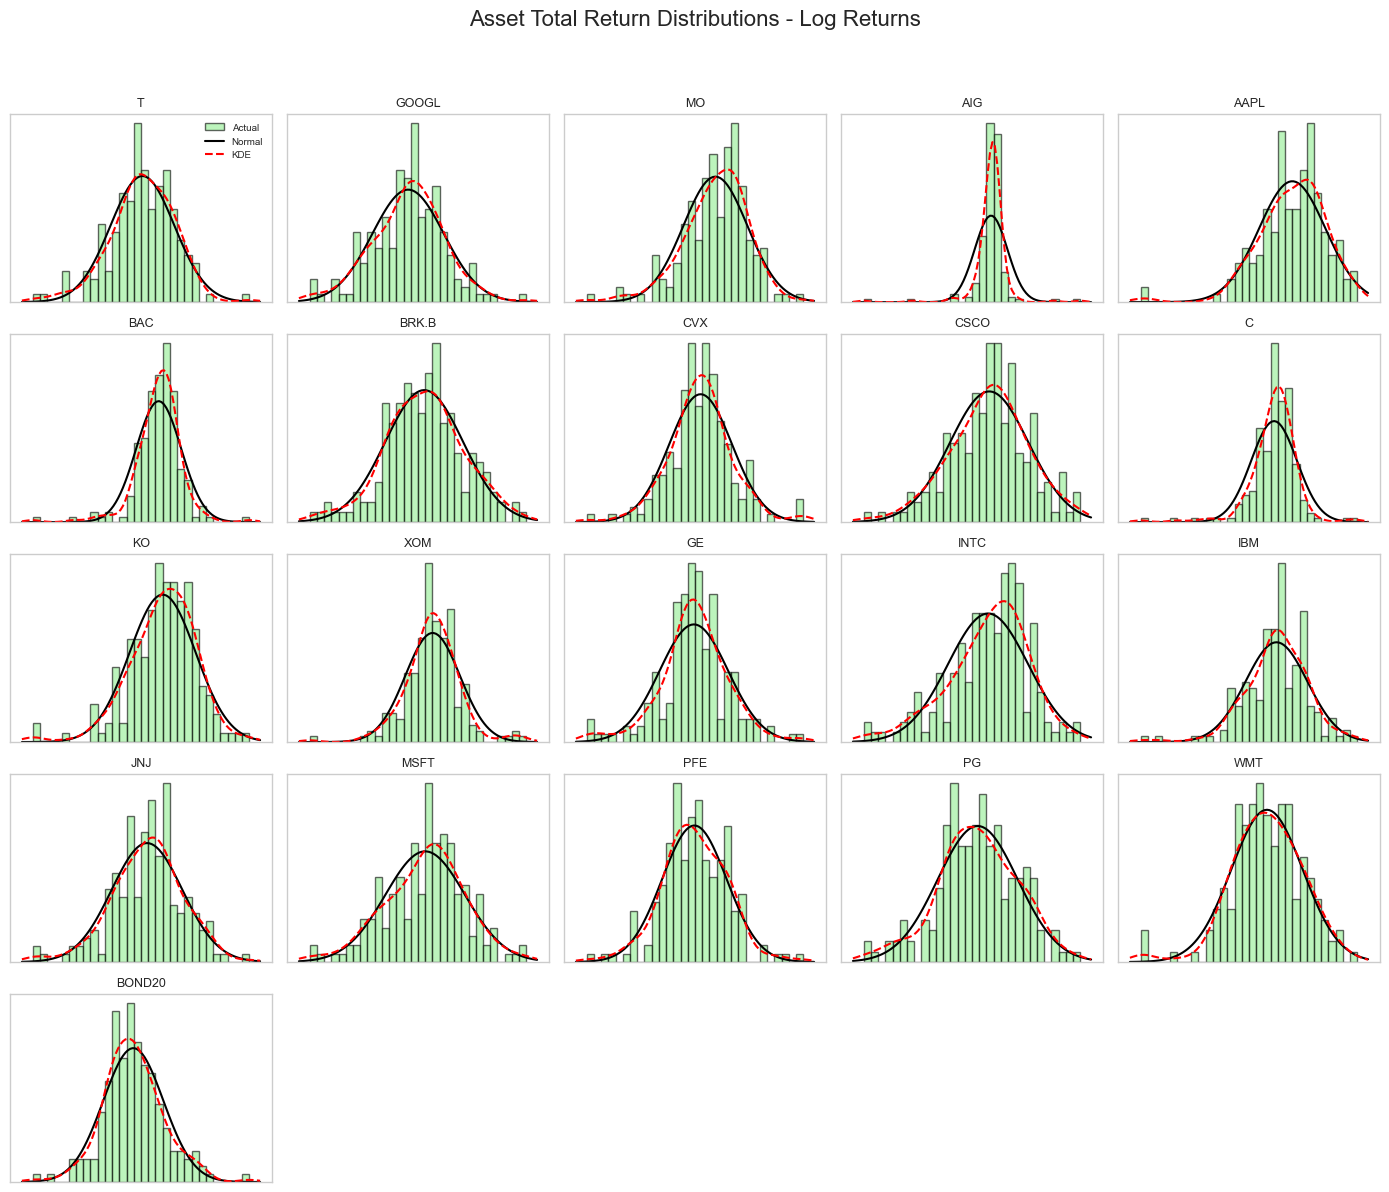

Sampled comparison plot saved to plots_output/return_histograms_total_sampled_comparison.png


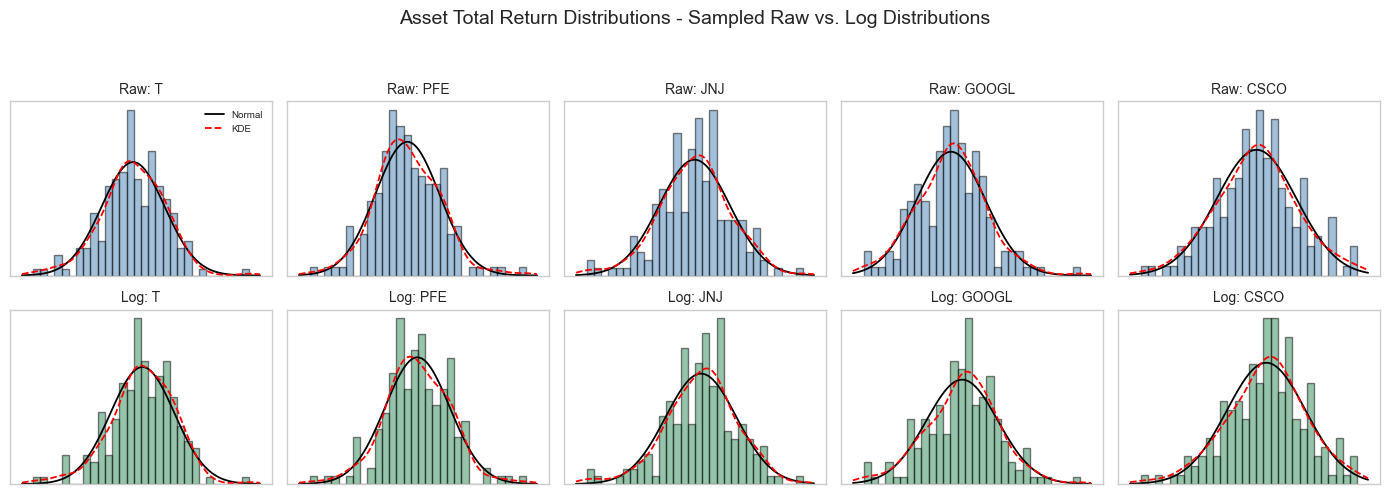

In [8]:
# --- Plot Return Distributions ---
print("\n--- Plotting Return Distributions ---")
plotting_utils.plot_return_distribution_histograms(
    returns_data_df=core_returns_df, 
    log_returns_data_df=log_core_returns_df,
    num_assets_to_sample=5, 
    title_prefix="Asset Total Return Distributions",
    output_path_raw=os.path.join(PLOTS_DIR, "return_histograms_total_raw.png"),
    output_path_log=os.path.join(PLOTS_DIR, "return_histograms_total_log.png"),
    output_path_sampled_comparison=os.path.join(PLOTS_DIR, "return_histograms_total_sampled_comparison.png")
)

The plots visualize the distributions of raw total returns and log total returns, overlaid with normal and KDE curves. A sampled comparison is also shown.

## 4. Sensitivity to Mean Estimate & Estimation Window
This section explores MVO's sensitivity to expected return estimates and estimation window length.

--- Analyzing Sensitivity to Mean Estimate Perturbation ---
Baseline MVO Weights (Excess Returns):


T        -0.193383
GOOGL    -0.010326
MO        0.156251
AIG       0.052592
AAPL      0.185059
BAC       0.162391
BRK.B     0.128075
CVX       0.119639
CSCO     -0.088721
C        -0.293784
KO       -0.033506
XOM       0.075255
GE       -0.103307
INTC     -0.142921
IBM       0.103833
JNJ       0.113926
MSFT      0.224711
PFE       0.076982
PG        0.091854
WMT       0.080364
BOND20    0.295016
Name: Baseline Weights, dtype: float64


MVO Weights with Perturbed Mean (Excess Returns):


T        -0.251745
GOOGL    -0.006216
MO        0.191772
AIG       0.050312
AAPL      0.144064
BAC       0.184838
BRK.B    -0.034574
CVX       0.089394
CSCO     -0.060937
C        -0.307059
KO       -0.097788
XOM       0.133775
GE       -0.066436
INTC     -0.165543
IBM       0.113484
JNJ       0.054479
MSFT      0.288023
PFE       0.143703
PG        0.159416
WMT       0.094041
BOND20    0.342998
Name: Perturbed Mean Weights, dtype: float64

Plot saved to plots_output/weights_sensitivity_mean_perturbation.png


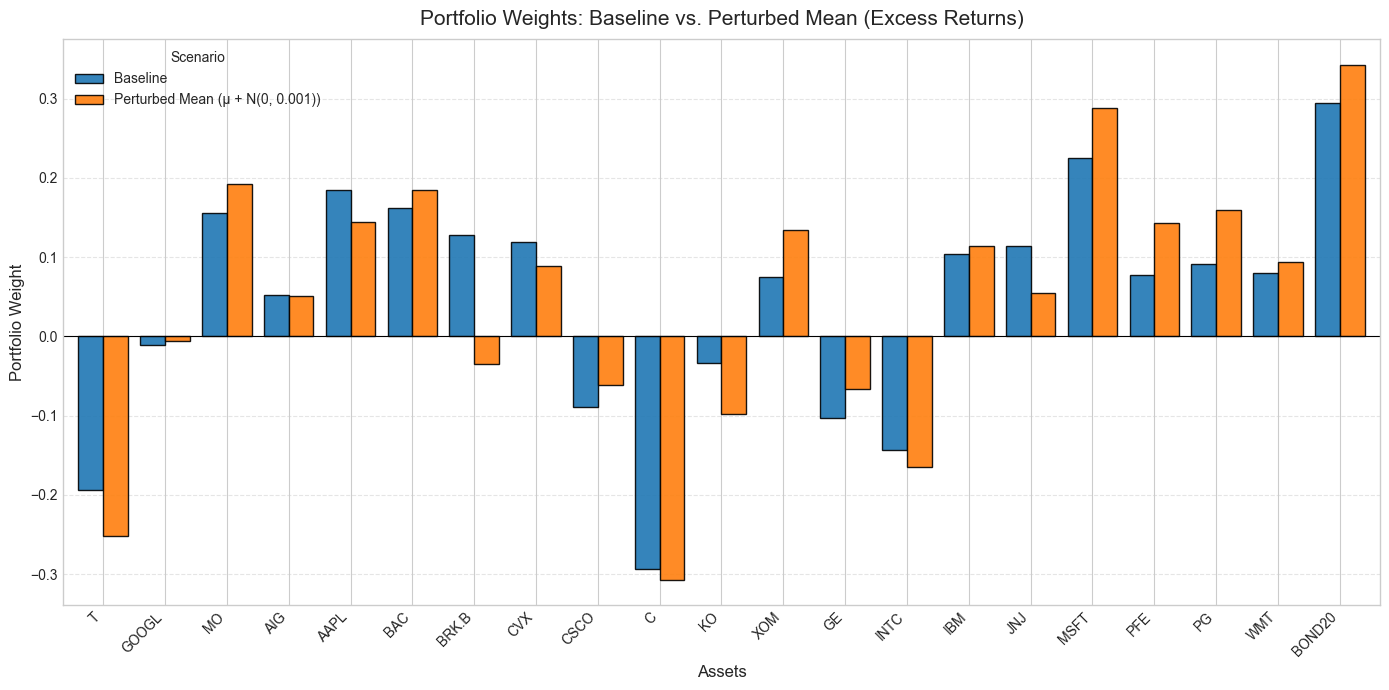


Average absolute percentage change in weights due to mean perturbation: 44.07%


In [9]:
# --- Sensitivity to Expected Return Estimates (Mean Perturbation) ---
print("--- Analyzing Sensitivity to Mean Estimate Perturbation ---")

mu_hat_excess = excess_returns_df.mean().values
Sigma_hat_excess = excess_returns_df.cov().values
asset_names_excess = excess_returns_df.columns

baseline_weights = portfolio_optimizers.compute_mvo_weights(mu_hat_excess, Sigma_hat_excess)
baseline_weights_series = pd.Series(baseline_weights, index=asset_names_excess, name="Baseline Weights")
print("Baseline MVO Weights (Excess Returns):")
display(baseline_weights_series)

np.random.seed(123)
epsilon_mu = np.random.normal(loc=0, scale=0.001, size=mu_hat_excess.shape) 
mu_noisy = mu_hat_excess + epsilon_mu

weights_noisy_mean = portfolio_optimizers.compute_mvo_weights(mu_noisy, Sigma_hat_excess)
weights_noisy_mean_series = pd.Series(weights_noisy_mean, index=asset_names_excess, name="Perturbed Mean Weights")
print("\nMVO Weights with Perturbed Mean (Excess Returns):")
display(weights_noisy_mean_series)

weights_comparison_dict_perturb = {
    'Baseline': baseline_weights_series,
    'Perturbed Mean (μ + N(0, 0.001))': weights_noisy_mean_series
}
plotting_utils.plot_weights_comparison_bar(
    weights_comparison_dict_perturb,
    title="Portfolio Weights: Baseline vs. Perturbed Mean (Excess Returns)",
    output_path=os.path.join(PLOTS_DIR, "weights_sensitivity_mean_perturbation.png")
)

percentual_change = np.abs((weights_noisy_mean - baseline_weights) / np.where(baseline_weights != 0, baseline_weights, np.nan))
avg_percentual_change = np.nanmean(percentual_change) * 100
print(f"\nAverage absolute percentage change in weights due to mean perturbation: {avg_percentual_change:.2f}%")

The plot compares baseline MVO weights with weights after perturbing mean estimates, showing sensitivity.


--- Analyzing Sensitivity to Estimation Window Length ---
Using fixed full-sample mean for window sensitivity: [0.00283193 0.0116205  0.01011423]...
Plot saved to plots_output/weights_sensitivity_estimation_window.png


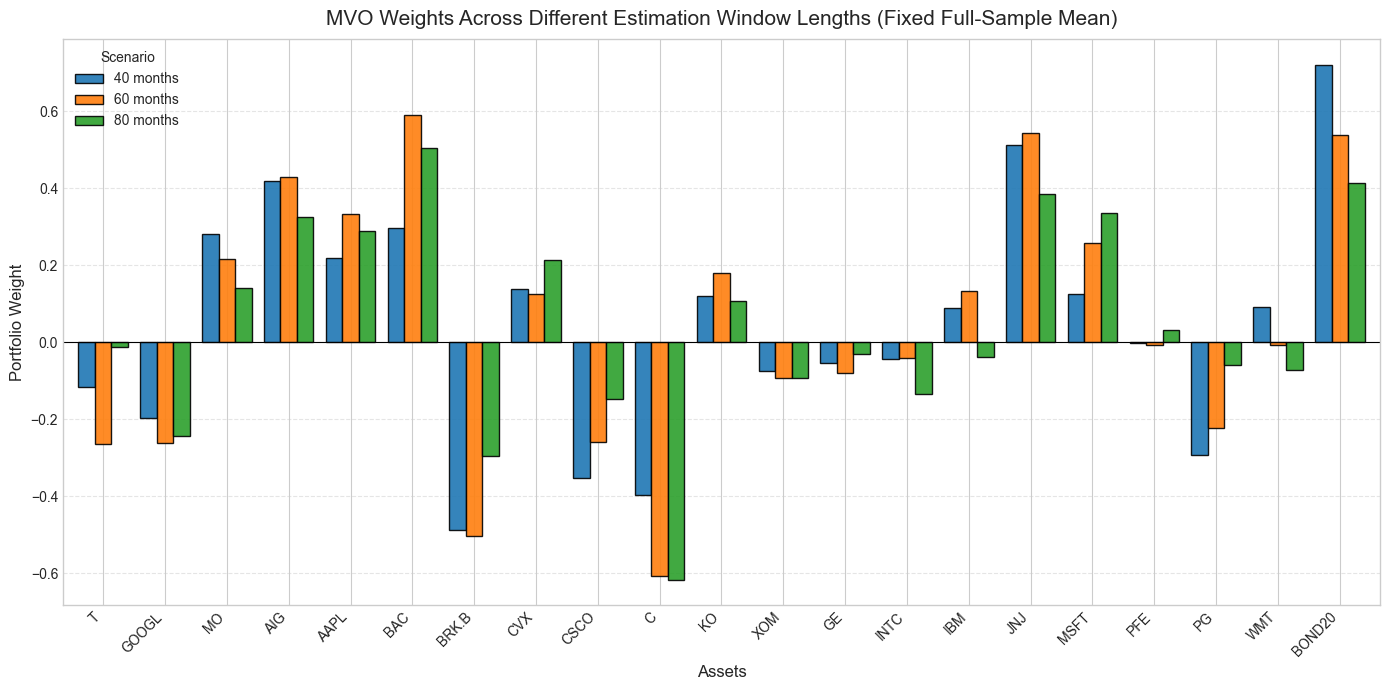

In [10]:
# --- Sensitivity to Estimation Window Length ---
print("\n--- Analyzing Sensitivity to Estimation Window Length ---")

window_sizes = [40, 60, 80] 
weights_by_window_dict = {}
mu_for_window_sensitivity = excess_returns_df.mean().values 

print(f"Using fixed full-sample mean for window sensitivity: {mu_for_window_sensitivity[:3]}...")

for window in window_sizes:
    if len(excess_returns_df) >= window:
        recent_returns_for_cov = excess_returns_df.iloc[-window:]
        current_assets_in_window = recent_returns_for_cov.columns
        mu_aligned_for_window = excess_returns_df[current_assets_in_window].mean().values
        
        if len(current_assets_in_window) < 2 :
            print(f"Skipping window {window}: only {len(current_assets_in_window)} asset(s) available.")
            continue
            
        Sigma_win = recent_returns_for_cov.cov().values
        if mu_aligned_for_window.shape[0] == Sigma_win.shape[0]:
            weights = portfolio_optimizers.compute_mvo_weights(mu_aligned_for_window, Sigma_win)
            weights_by_window_dict[f"{window} months"] = pd.Series(weights, index=current_assets_in_window)
        else:
            print(f"Dimension mismatch for window {window}. Skipping.")
    else:
        print(f"Skipping window {window} as it's larger than available data.")

if weights_by_window_dict:
    all_assets_in_windows_sensitivity = pd.Index([])
    for s_item in weights_by_window_dict.values():
        all_assets_in_windows_sensitivity = all_assets_in_windows_sensitivity.union(s_item.index)
    
    aligned_weights_by_window_dict = {
        key: s_item.reindex(all_assets_in_windows_sensitivity).fillna(0) 
        for key, s_item in weights_by_window_dict.items()
    }
    plotting_utils.plot_weights_comparison_bar(
        aligned_weights_by_window_dict,
        title="MVO Weights Across Different Estimation Window Lengths (Fixed Full-Sample Mean)",
        output_path=os.path.join(PLOTS_DIR, "weights_sensitivity_estimation_window.png")
    )
else:
    print("No data to plot for estimation window sensitivity.")

This plot shows how MVO weights change when the covariance matrix is estimated using different window lengths (with fixed means).

## 5. Classical Efficient Frontier
Computes and visualizes the classical MVO efficient frontier, GMV, Tangency portfolio, and CML. Also shows frontiers by estimation window.

--- Computing Main Classical Efficient Frontier ---
Plot saved to plots_output/efficient_frontier_classical_full_sample.png


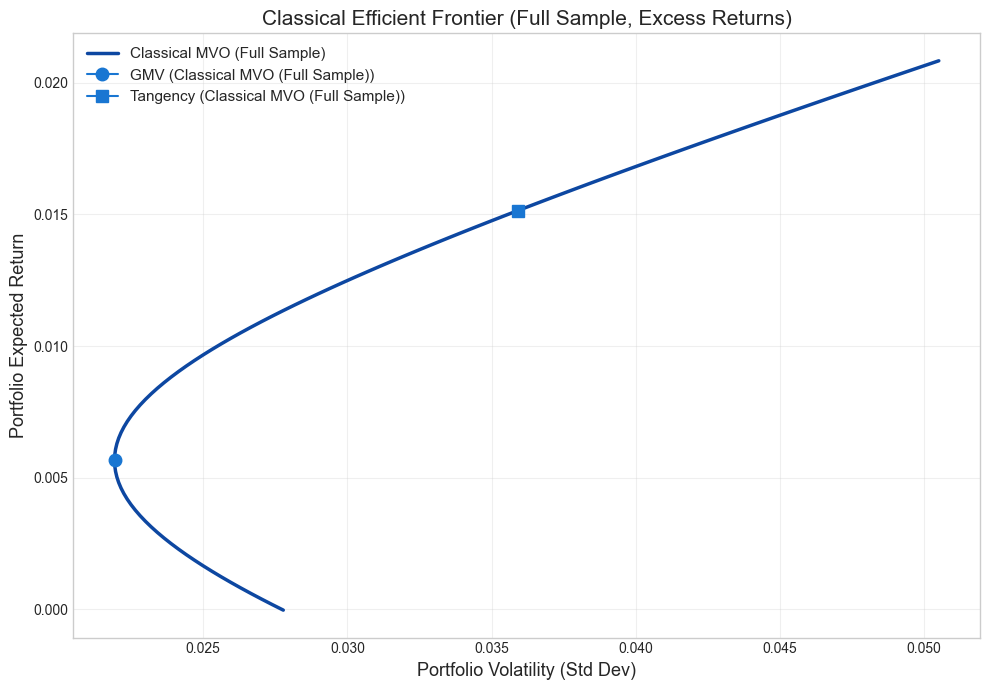

In [11]:
# --- Compute and Plot Main Classical Efficient Frontier ---
print("--- Computing Main Classical Efficient Frontier ---")

target_returns_classical, portfolio_vols_classical, _ = \
    portfolio_optimizers.compute_efficient_frontier_general(
        excess_returns_df, bayesian_scale_factor_fn=None
    )

valid_indices_classical = ~np.isnan(portfolio_vols_classical) & ~np.isnan(target_returns_classical)
portfolio_vols_classical_valid = portfolio_vols_classical[valid_indices_classical]
target_returns_classical_valid = target_returns_classical[valid_indices_classical]

classical_frontier_plot_data = []
gmv_point_classical_main = None
tangency_point_classical_main = None

if len(portfolio_vols_classical_valid) > 1:
    gmv_idx_classical = np.nanargmin(portfolio_vols_classical_valid)
    gmv_point_classical_main = (portfolio_vols_classical_valid[gmv_idx_classical], target_returns_classical_valid[gmv_idx_classical])

    sharpe_ratios_classical = (target_returns_classical_valid - RISK_FREE_RATE_FOR_SHARPE) / portfolio_vols_classical_valid
    valid_sharpe_indices = np.isfinite(sharpe_ratios_classical) & (portfolio_vols_classical_valid > 1e-9)
    if np.any(valid_sharpe_indices):
        tangency_idx_classical = np.nanargmax(sharpe_ratios_classical[valid_sharpe_indices])
        actual_idx_for_tangency = np.where(valid_sharpe_indices)[0][tangency_idx_classical]
        tangency_point_classical_main = (portfolio_vols_classical_valid[actual_idx_for_tangency], target_returns_classical_valid[actual_idx_for_tangency])
    else:
        tangency_point_classical_main = (np.nan, np.nan)
        
    classical_frontier_plot_data.append((
        portfolio_vols_classical_valid, target_returns_classical_valid, "Classical MVO (Full Sample)", 
        gmv_point_classical_main, tangency_point_classical_main,
        {'line_color': '#0d47a1', 'dot_color': '#1976d2', 'line_style': '-'}
    ))

    plotting_utils.plot_efficient_frontier(
        classical_frontier_plot_data,
        title="Classical Efficient Frontier (Full Sample, Excess Returns)",
        plot_cml=True, risk_free_rate=RISK_FREE_RATE_FOR_SHARPE,
        output_path=os.path.join(PLOTS_DIR, "efficient_frontier_classical_full_sample.png")
    )
else:
    print("Could not generate main classical efficient frontier.")

The plot shows the classical efficient frontier with GMV, Tangency portfolio, and CML.


--- Computing Classical Efficient Frontiers for Different Estimation Windows ---
Plot saved to plots_output/efficient_frontiers_by_estimation_window.png


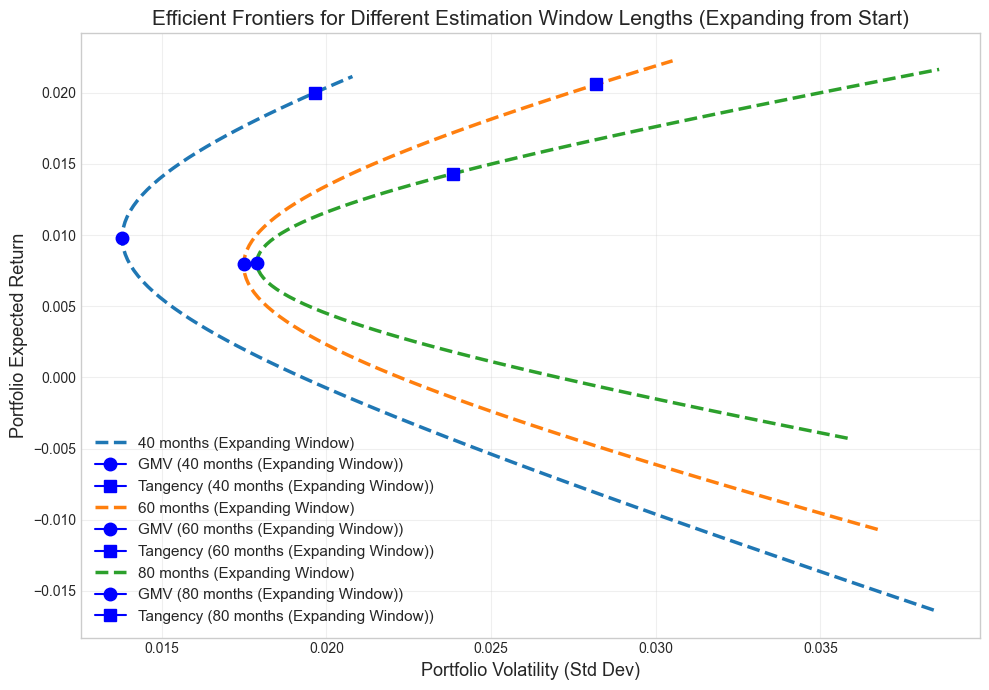

In [12]:
# --- Classical Efficient Frontiers for Different Estimation Windows ---
print("\n--- Computing Classical Efficient Frontiers for Different Estimation Windows ---")
frontiers_by_window_plot_data = []
for w_size in window_sizes:
    if len(excess_returns_df) >= w_size:
        windowed_returns_data = excess_returns_df.iloc[:w_size] 
        if windowed_returns_data.shape[1] < 2 or windowed_returns_data.shape[0] < 5:
            print(f"Skipping window {w_size} due to insufficient data/assets.")
            continue
        tr_w, pv_w, _ = portfolio_optimizers.compute_efficient_frontier_general(windowed_returns_data)
        valid_indices_w = ~np.isnan(pv_w) & ~np.isnan(tr_w)
        if np.sum(valid_indices_w) > 1:
             frontiers_by_window_plot_data.append((
                 pv_w[valid_indices_w], tr_w[valid_indices_w], f"{w_size} months (Expanding Window)", 
                 None, None, {'line_style': '--'}
             ))
        else:
            print(f"Not enough valid points for window {w_size}.")
    else:
        print(f"Window size {w_size} too large.")

if frontiers_by_window_plot_data:
    plotting_utils.plot_efficient_frontier(
        frontiers_by_window_plot_data,
        title="Efficient Frontiers for Different Estimation Window Lengths (Expanding from Start)",
        output_path=os.path.join(PLOTS_DIR, "efficient_frontiers_by_estimation_window.png")
    )
else:
    print("No data for efficient frontiers by window plot.")

This plot compares efficient frontiers estimated using different expanding window lengths.

## 6. Rolling Window Backtesting (Classical Strategies)
Evaluates out-of-sample performance of classical MVO strategies using rolling window backtesting.

--- Section 6: Rolling Window Backtesting (Classical Strategies) ---

Running classical strategy: Unconstrained...
Summary for Unconstrained:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                           1.1697                        0.0074   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0554                            0.4628   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                       9.9986       1.1266       0.3897   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.2285            1.2776            0.4703

Plot saved to plots_output/avg_weights_classical_unconstrained.png


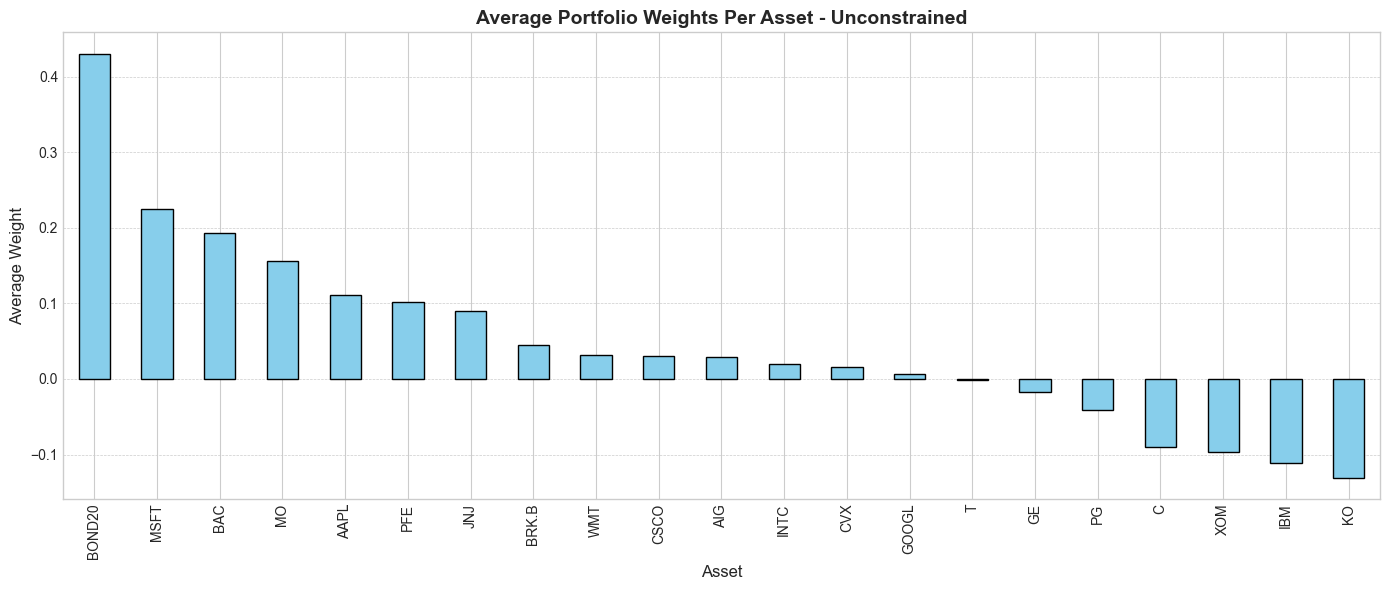


Running classical strategy: Unconstrained Ridge...
Summary for Unconstrained Ridge:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                           1.7967                        0.0087   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0361                            0.8319   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                      11.6863       0.0748       0.0155   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.0355            0.1393            0.0542

Plot saved to plots_output/avg_weights_classical_unconstrained_ridge.png


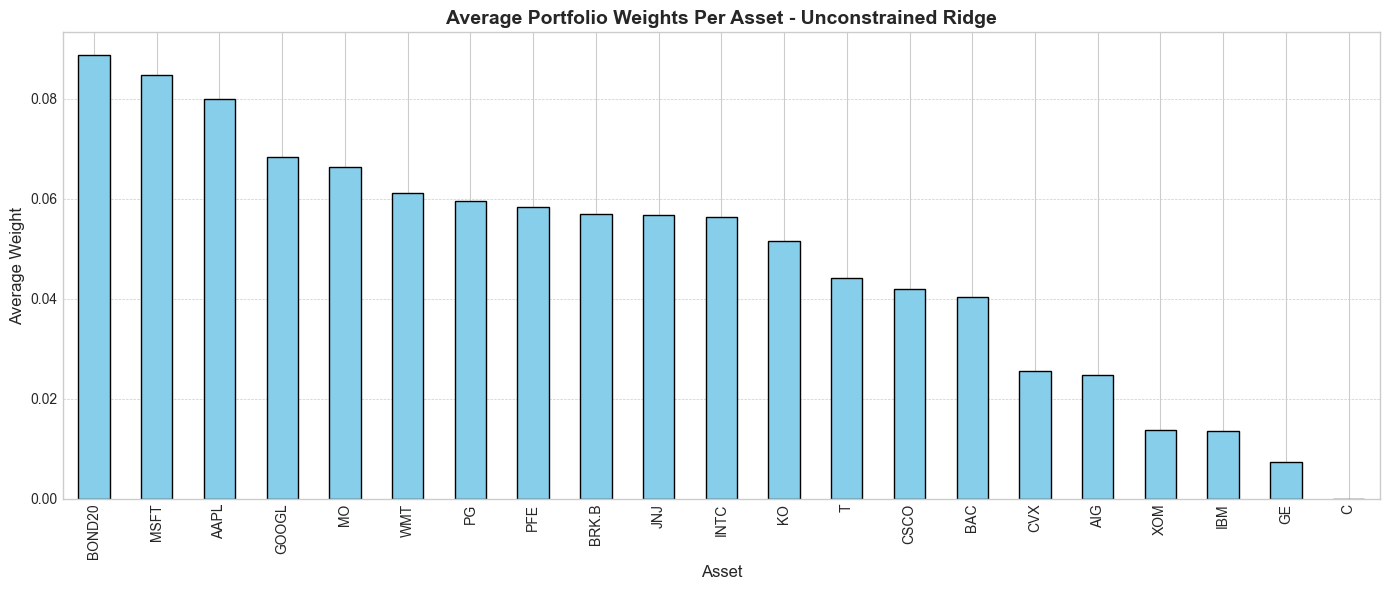


Running classical strategy: Long Only...
Summary for Long Only:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                           1.9085                         0.009   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0372                             0.842   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                      12.1714       0.2874       0.0771   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                       0.108            0.2974            0.1642

Plot saved to plots_output/avg_weights_classical_long_only.png


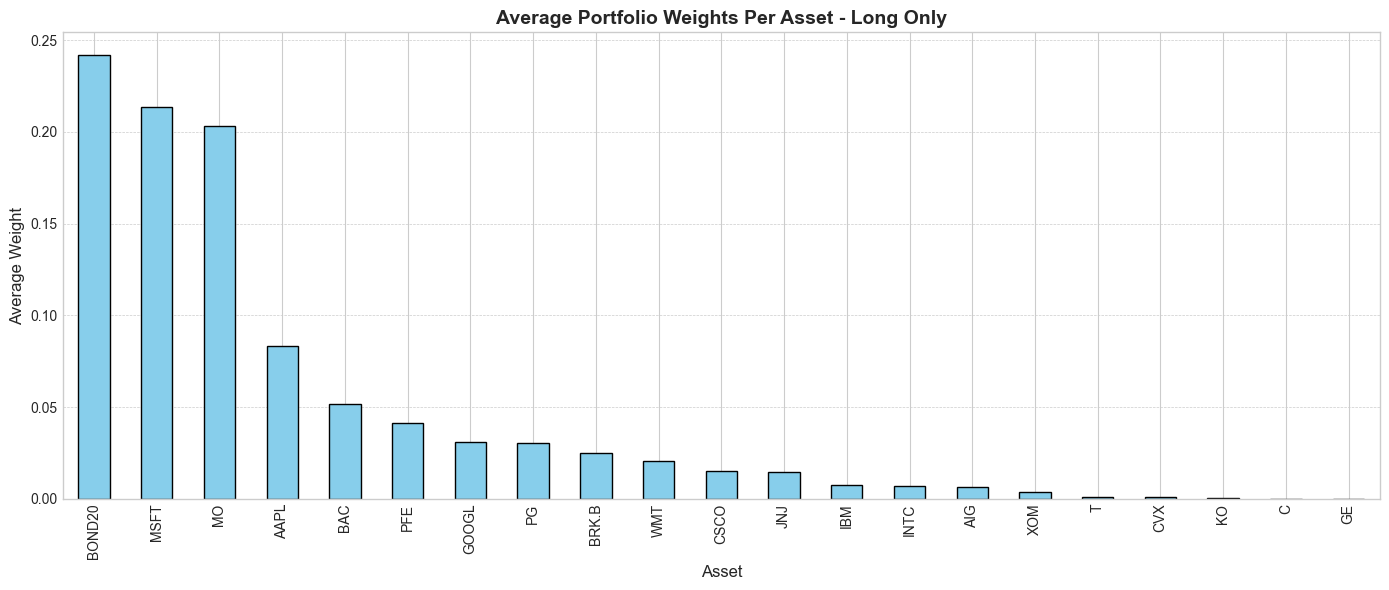

In [13]:
# --- Define and Run Classical Backtesting Strategies ---
print("--- Section 6: Rolling Window Backtesting (Classical Strategies) ---")
classical_strategies_to_run = {
    "Unconstrained": {"constraint_fn": portfolio_optimizers.unconstrained, "ridge": False},
    "Unconstrained Ridge": {"constraint_fn": portfolio_optimizers.unconstrained_ridge, "ridge": True, "lambda_ridge": 0.1},
    "Long Only": {"constraint_fn": portfolio_optimizers.long_only, "ridge": False}
}
classical_results_collection = {}
classical_cumulative_returns_collection = {}
classical_weights_collection = {}

for strat_name, config in classical_strategies_to_run.items():
    print(f"\nRunning classical strategy: {strat_name}...")
    weights_df, strategy_excess_returns_series = backtesting_engine.run_rolling_strategy(
        excess_returns_df=excess_returns_df, estimation_window=ESTIMATION_WINDOW,
        holding_period=HOLDING_PERIOD, risk_limit_target_vol=RISK_LIMIT_TARGET_VOL,
        constraint_fn=config["constraint_fn"], portfolio_solver_fn=portfolio_optimizers.solve_portfolio,
        ridge=config.get("ridge", False), lambda_ridge=config.get("lambda_ridge", 0.1)
    )
    summary_df, allocation_diag_df, cum_total_returns_rebased100, turnover_series = \
        backtesting_engine.summarize_performance(weights_df, strategy_excess_returns_series, risk_free_series)
    classical_results_collection[strat_name] = summary_df
    classical_cumulative_returns_collection[strat_name] = cum_total_returns_rebased100
    classical_weights_collection[strat_name] = weights_df
    print(f"Summary for {strat_name}:"); display(summary_df.round(4))
    safe_name = strat_name.lower().replace(' ', '_')
    summary_df.to_csv(os.path.join(RESULTS_DIR, f"summary_classical_{safe_name}.csv"))
    weights_df.to_csv(os.path.join(RESULTS_DIR, f"weights_classical_{safe_name}.csv"))
    if not turnover_series.empty: turnover_series.to_csv(os.path.join(RESULTS_DIR, f"turnover_classical_{safe_name}.csv"))
    if not allocation_diag_df.empty: plotting_utils.plot_average_weights_bar(allocation_diag_df["Average Weight"], strat_name, output_path=os.path.join(PLOTS_DIR, f"avg_weights_classical_{safe_name}.png"))
    else: print(f"No allocation diagnostics for {strat_name}.")

Performance summaries and average weights for classical strategies are saved and displayed.


--- Comparing Cumulative Returns of Classical Strategies ---
Plot saved to plots_output/cumulative_returns_classical_strategies.png


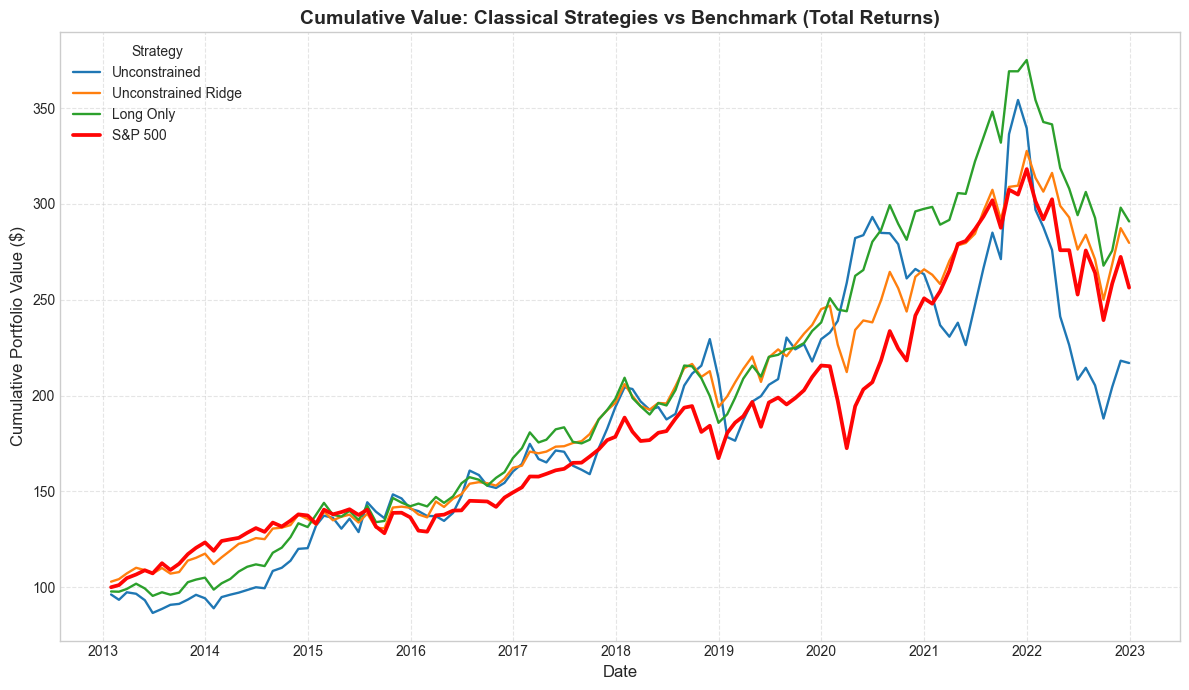

In [14]:
# --- Compare Cumulative Returns of Classical Strategies ---
print("\n--- Comparing Cumulative Returns of Classical Strategies ---")
benchmark_cum_total_for_plot_classical = None
valid_series_classical = [s for s in classical_cumulative_returns_collection.values() if not s.empty]
if valid_series_classical:
    min_date_classical = min(s.index.min() for s in valid_series_classical)
    max_date_classical = max(s.index.max() for s in valid_series_classical)
    benchmark_total_returns_for_plot_period = benchmark_returns_series[
        (benchmark_returns_series.index >= min_date_classical) & (benchmark_returns_series.index <= max_date_classical)
    ]
    if not benchmark_total_returns_for_plot_period.empty:
        temp_benchmark_cum_total = (1 + benchmark_total_returns_for_plot_period).cumprod()
        benchmark_cum_total_for_plot_classical = (temp_benchmark_cum_total / temp_benchmark_cum_total.iloc[0]) * 100
        benchmark_cum_total_for_plot_classical.name = "S&P 500"
    plotting_utils.plot_strategy_cumulative_returns_comparison(
        classical_cumulative_returns_collection, 
        benchmark_series=benchmark_cum_total_for_plot_classical, benchmark_label="S&P 500",
        title="Cumulative Value: Classical Strategies vs Benchmark (Total Returns)",
        output_path=os.path.join(PLOTS_DIR, "cumulative_returns_classical_strategies.png")
    )
else:
    print("No classical strategy results for cumulative returns plot.")

Cumulative total returns of classical strategies are compared against the S&P 500.


--- Comparing Performance Metrics of Classical Strategies ---
Plot saved to plots_output/metrics_comparison_classical_strategies.png


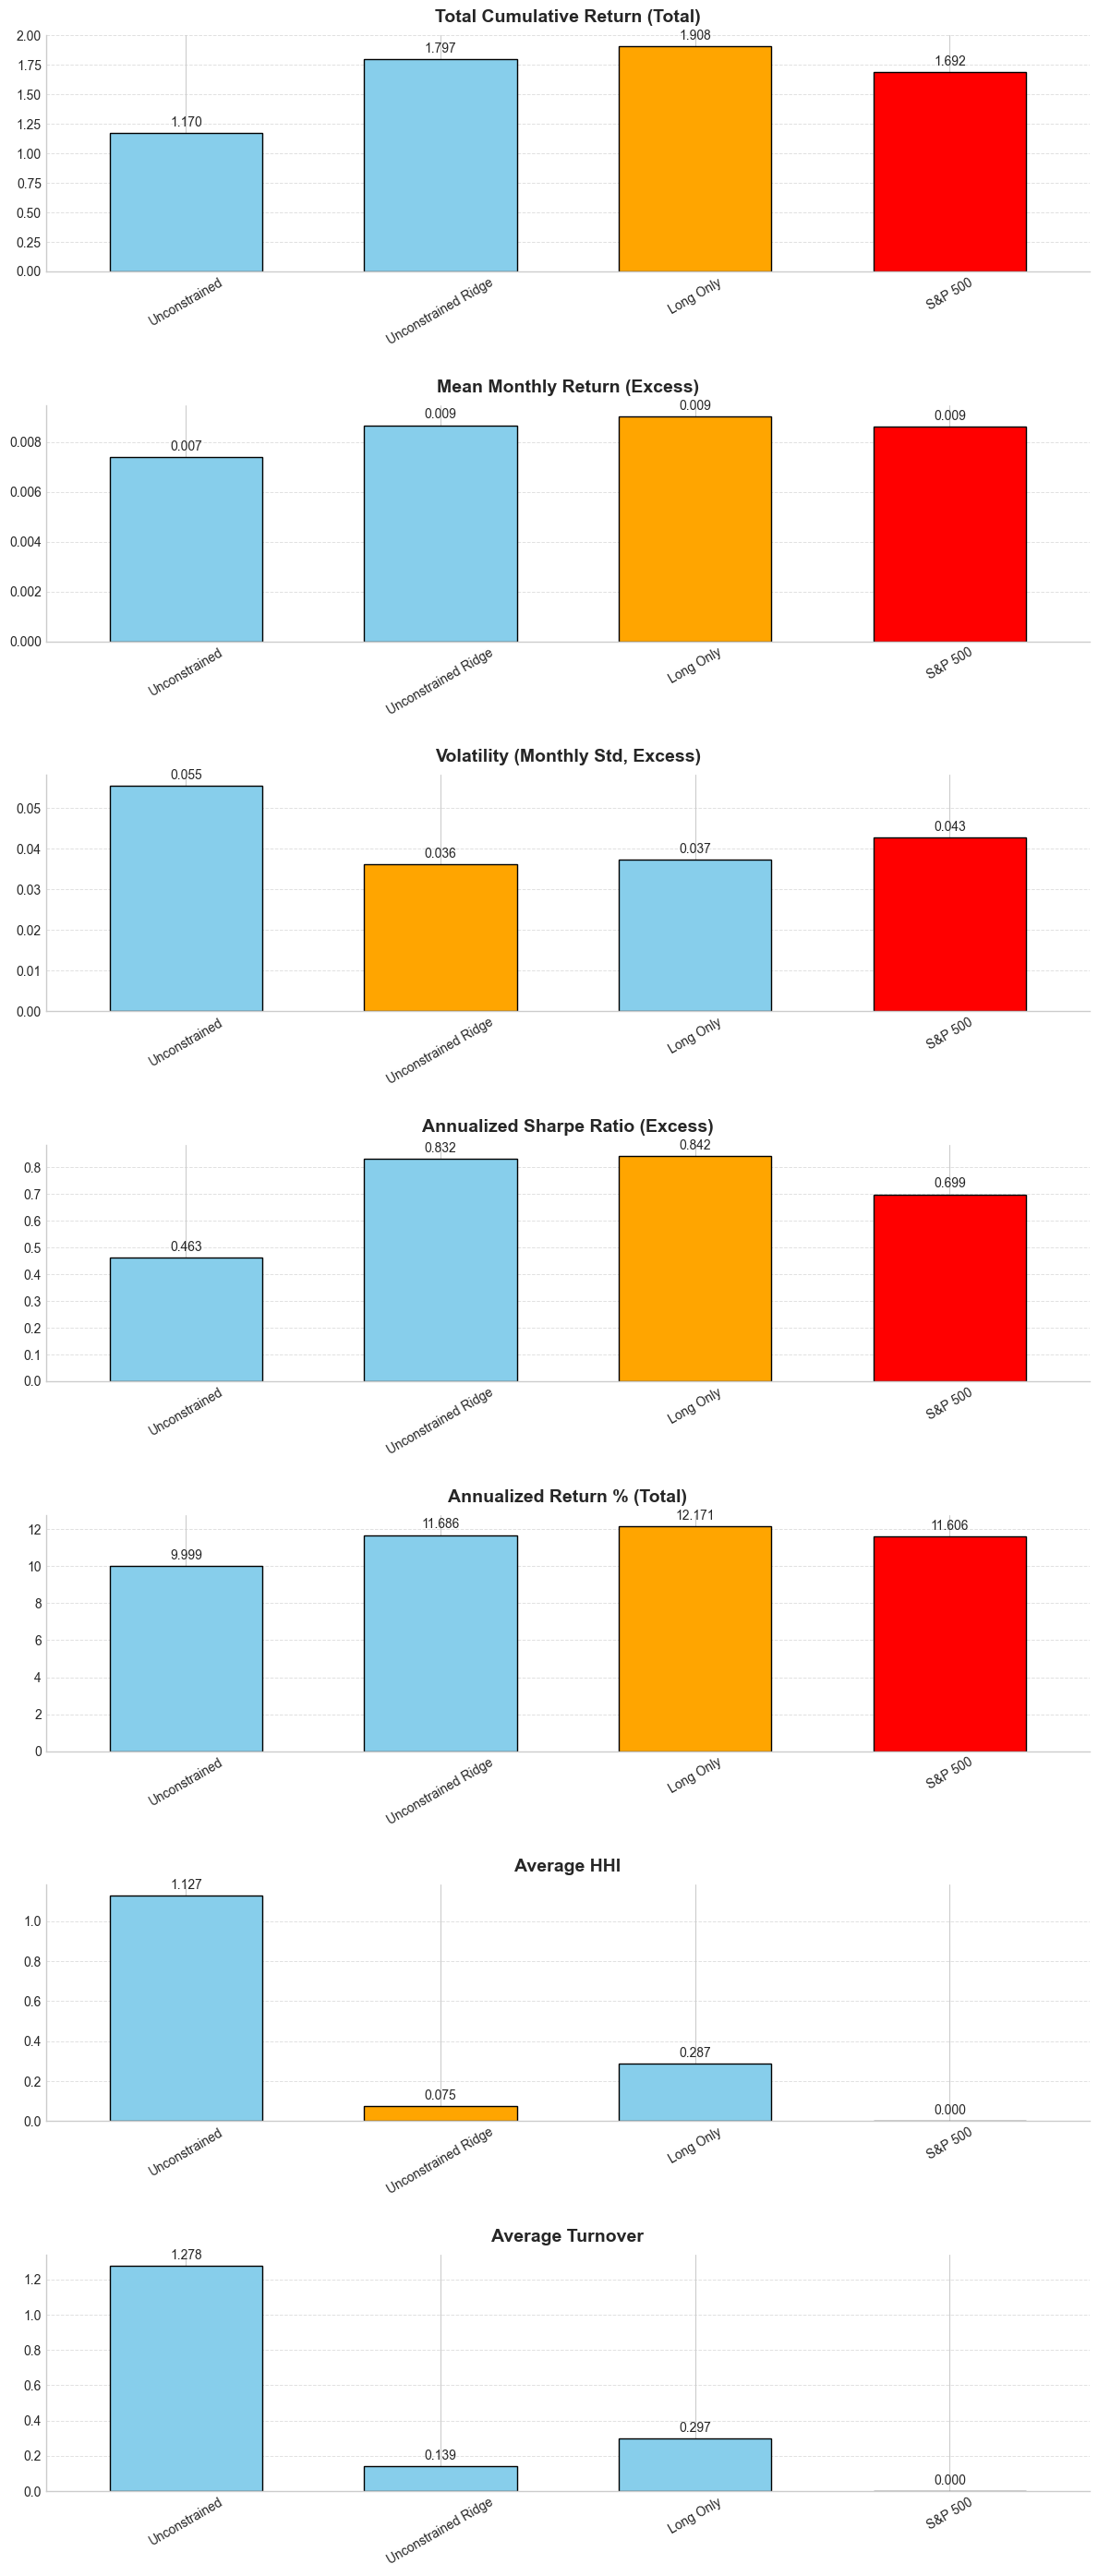

In [15]:
# --- Compare Performance Metrics of Classical Strategies ---
print("\n--- Comparing Performance Metrics of Classical Strategies ---")
benchmark_summary_for_plot_classical_metrics = None 
all_classical_summaries_df = pd.DataFrame()
if classical_results_collection:
    all_classical_summaries_df = pd.concat([df.assign(Strategy=name) for name, df in classical_results_collection.items()]).set_index("Strategy")
    if valid_series_classical: # min_date_classical, max_date_classical defined
        bench_excess_for_stats_classical = benchmark_excess_returns_series[
            (benchmark_excess_returns_series.index >= min_date_classical) &
            (benchmark_excess_returns_series.index <= max_date_classical)
        ]
        bench_total_for_stats_classical = benchmark_returns_series[
            (benchmark_returns_series.index >= min_date_classical) &
            (benchmark_returns_series.index <= max_date_classical)
        ]
        if not bench_excess_for_stats_classical.empty and not bench_total_for_stats_classical.empty:
            bench_mean_monthly_exc = bench_excess_for_stats_classical.mean()
            bench_vol_monthly_exc = bench_excess_for_stats_classical.std()
            bench_sharpe_exc = (bench_mean_monthly_exc / bench_vol_monthly_exc * np.sqrt(12)) if bench_vol_monthly_exc != 0 else 0.0
            bench_total_cum_ret = (1 + bench_total_for_stats_classical).prod() - 1
            bench_ann_total_ret_pct = ((1 + bench_total_for_stats_classical.mean())**12 - 1) * 100
            benchmark_summary_for_plot_classical_metrics = pd.DataFrame({
                "Total Cumulative Return (Total)": [bench_total_cum_ret], "Mean Monthly Return (Excess)": [bench_mean_monthly_exc],
                "Volatility (Monthly Std, Excess)": [bench_vol_monthly_exc], "Annualized Sharpe Ratio (Excess)": [bench_sharpe_exc],
                "Annualized Return % (Total)": [bench_ann_total_ret_pct], "Average HHI": [np.nan],
                "HHI Std Dev": [np.nan], "Avg Rolling Weight Std Dev": [np.nan],
                "Average Turnover": [0.0], "Turnover Std Dev": [0.0]
            }, index=["S&P 500"])
            all_classical_summaries_df = pd.concat([all_classical_summaries_df, benchmark_summary_for_plot_classical_metrics])
    if not all_classical_summaries_df.empty:
        metrics_to_plot_list = [
            "Total Cumulative Return (Total)", "Mean Monthly Return (Excess)", "Volatility (Monthly Std, Excess)",
            "Annualized Sharpe Ratio (Excess)", "Annualized Return % (Total)", "Average HHI", "Average Turnover"
        ]
        for metric in metrics_to_plot_list: 
            if metric not in all_classical_summaries_df.columns: all_classical_summaries_df[metric] = np.nan
        maximize_metrics_set = {"Total Cumulative Return (Total)", "Mean Monthly Return (Excess)", 
                              "Annualized Sharpe Ratio (Excess)", "Annualized Return % (Total)"}
        plotting_utils.plot_strategy_metrics_comparison_bar(
            all_classical_summaries_df, metrics_to_plot=metrics_to_plot_list, benchmark_name="S&P 500",
            maximize_metrics=maximize_metrics_set,
            output_path=os.path.join(PLOTS_DIR, "metrics_comparison_classical_strategies.png")
        )
    else: print("No classical summaries for metrics plot.")
else: print("No classical results for metrics comparison.")

Key performance metrics are compared across classical strategies and the benchmark.

## 7. Bayesian Efficient Frontiers
Compares efficient frontiers from Bayesian approaches (Diffuse Prior, Conjugate NIW) with Classical MVO.

--- Section 7: Bayesian Efficient Frontiers ---
Plot saved to plots_output/efficient_frontiers_bayesian_comparison.png


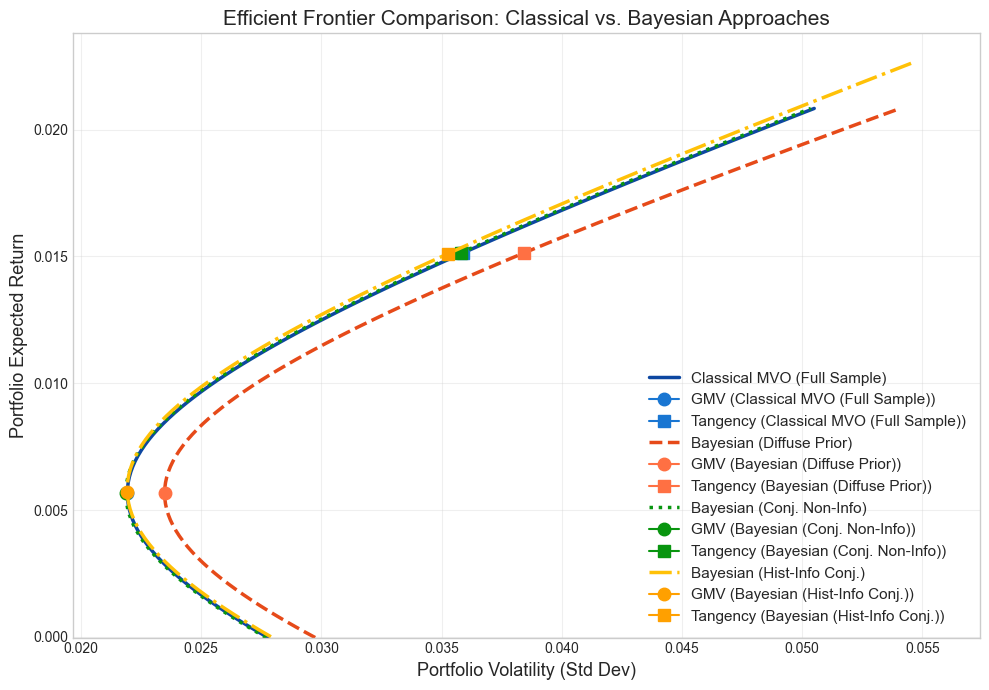


Summary of GMV and Tangency Portfolio Characteristics from Efficient Frontiers:


Return  Volatility  Sharpe
Strategy                   Type                                
Classical MVO              GMV       0.0057      0.0219  0.2582
                           Tangency  0.0151      0.0359  0.4218
Bayesian (Diffuse Prior)   GMV       0.0057      0.0235  0.2412
                           Tangency  0.0151      0.0385  0.3939
Bayesian (Conj. Non-Info)  GMV       0.0057      0.0219  0.2590
                           Tangency  0.0151      0.0358  0.4230
Bayesian (Hist-Info Conj.) GMV       0.0057      0.0219  0.2612
                           Tangency  0.0151      0.0353  0.4284

In [16]:
# --- Bayesian Efficient Frontier Calculations ---
print("--- Section 7: Bayesian Efficient Frontiers ---")
frontiers_to_plot_bayesian_comparison = []
ef_char_summary_list = [] 

if 'classical_frontier_plot_data' in locals() and classical_frontier_plot_data:
    frontiers_to_plot_bayesian_comparison.append(classical_frontier_plot_data[0]) 
    _, _, _, gmv_c, tan_c, _ = classical_frontier_plot_data[0]
    if gmv_c: ef_char_summary_list.append({'Strategy': 'Classical MVO', 'Type': 'GMV', 'Return': gmv_c[1], 'Volatility': gmv_c[0], 'Sharpe': (gmv_c[1]-RISK_FREE_RATE_FOR_SHARPE)/gmv_c[0] if gmv_c[0]!=0 else 0})
    if tan_c: ef_char_summary_list.append({'Strategy': 'Classical MVO', 'Type': 'Tangency', 'Return': tan_c[1], 'Volatility': tan_c[0], 'Sharpe': (tan_c[1]-RISK_FREE_RATE_FOR_SHARPE)/tan_c[0] if tan_c[0]!=0 else 0})

mu_b_diff, sig_b_diff = bayesian_estimators.bayesian_diffuse_prior_moments(excess_returns_df)
tr_b_diff, pv_b_diff, _ = portfolio_optimizers.compute_efficient_frontier_from_moments(mu_b_diff, sig_b_diff)
valid_b_diff = ~np.isnan(pv_b_diff) & ~np.isnan(tr_b_diff)
if np.sum(valid_b_diff) > 1:
    gmv_idx, tan_idx = np.nanargmin(pv_b_diff[valid_b_diff]), np.nanargmax(((tr_b_diff[valid_b_diff]-RISK_FREE_RATE_FOR_SHARPE)/pv_b_diff[valid_b_diff])[np.isfinite((tr_b_diff[valid_b_diff]-RISK_FREE_RATE_FOR_SHARPE)/pv_b_diff[valid_b_diff]) & (pv_b_diff[valid_b_diff]>1e-9)])
    actual_tan_idx = np.where(np.isfinite((tr_b_diff[valid_b_diff]-RISK_FREE_RATE_FOR_SHARPE)/pv_b_diff[valid_b_diff]) & (pv_b_diff[valid_b_diff]>1e-9))[0][tan_idx]
    gmv_pt_bd = (pv_b_diff[valid_b_diff][gmv_idx], tr_b_diff[valid_b_diff][gmv_idx])
    tan_pt_bd = (pv_b_diff[valid_b_diff][actual_tan_idx], tr_b_diff[valid_b_diff][actual_tan_idx])
    frontiers_to_plot_bayesian_comparison.append((pv_b_diff[valid_b_diff], tr_b_diff[valid_b_diff], "Bayesian (Diffuse Prior)", gmv_pt_bd, tan_pt_bd, {'line_color': '#e64a19', 'dot_color': '#ff7043', 'line_style': '--'}))
    if gmv_pt_bd: ef_char_summary_list.append({'Strategy': 'Bayesian (Diffuse Prior)', 'Type': 'GMV', 'Return': gmv_pt_bd[1], 'Volatility': gmv_pt_bd[0], 'Sharpe': (gmv_pt_bd[1]-RISK_FREE_RATE_FOR_SHARPE)/gmv_pt_bd[0] if gmv_pt_bd[0]!=0 else 0})
    if tan_pt_bd: ef_char_summary_list.append({'Strategy': 'Bayesian (Diffuse Prior)', 'Type': 'Tangency', 'Return': tan_pt_bd[1], 'Volatility': tan_pt_bd[0], 'Sharpe': (tan_pt_bd[1]-RISK_FREE_RATE_FOR_SHARPE)/tan_pt_bd[0] if tan_pt_bd[0]!=0 else 0})

mu_niw_ni, sig_niw_ni = bayesian_estimators.informative_bayes_predictive_niw(excess_returns_df, use_flat_mean_prior=True, tau_prior_confidence=1e-6, use_flat_cov_prior=True)
tr_niw_ni, pv_niw_ni, _ = portfolio_optimizers.compute_efficient_frontier_from_moments(mu_niw_ni, sig_niw_ni)
valid_niw_ni = ~np.isnan(pv_niw_ni) & ~np.isnan(tr_niw_ni)
if np.sum(valid_niw_ni) > 1:
    gmv_idx, tan_idx = np.nanargmin(pv_niw_ni[valid_niw_ni]), np.nanargmax(((tr_niw_ni[valid_niw_ni]-RISK_FREE_RATE_FOR_SHARPE)/pv_niw_ni[valid_niw_ni])[np.isfinite((tr_niw_ni[valid_niw_ni]-RISK_FREE_RATE_FOR_SHARPE)/pv_niw_ni[valid_niw_ni]) & (pv_niw_ni[valid_niw_ni]>1e-9)])
    actual_tan_idx = np.where(np.isfinite((tr_niw_ni[valid_niw_ni]-RISK_FREE_RATE_FOR_SHARPE)/pv_niw_ni[valid_niw_ni]) & (pv_niw_ni[valid_niw_ni]>1e-9))[0][tan_idx]
    gmv_pt_niw_ni = (pv_niw_ni[valid_niw_ni][gmv_idx], tr_niw_ni[valid_niw_ni][gmv_idx])
    tan_pt_niw_ni = (pv_niw_ni[valid_niw_ni][actual_tan_idx], tr_niw_ni[valid_niw_ni][actual_tan_idx])
    frontiers_to_plot_bayesian_comparison.append((pv_niw_ni[valid_niw_ni], tr_niw_ni[valid_niw_ni], "Bayesian (Conj. Non-Info)", gmv_pt_niw_ni, tan_pt_niw_ni, {'line_color': '#08950F', 'dot_color': '#08950F', 'line_style': ':'}))
    if gmv_pt_niw_ni: ef_char_summary_list.append({'Strategy': 'Bayesian (Conj. Non-Info)', 'Type': 'GMV', 'Return': gmv_pt_niw_ni[1], 'Volatility': gmv_pt_niw_ni[0], 'Sharpe': (gmv_pt_niw_ni[1]-RISK_FREE_RATE_FOR_SHARPE)/gmv_pt_niw_ni[0] if gmv_pt_niw_ni[0]!=0 else 0})
    if tan_pt_niw_ni: ef_char_summary_list.append({'Strategy': 'Bayesian (Conj. Non-Info)', 'Type': 'Tangency', 'Return': tan_pt_niw_ni[1], 'Volatility': tan_pt_niw_ni[0], 'Sharpe': (tan_pt_niw_ni[1]-RISK_FREE_RATE_FOR_SHARPE)/tan_pt_niw_ni[0] if tan_pt_niw_ni[0]!=0 else 0})

if 'historical_excess_returns_prior_df' in locals() and not historical_excess_returns_prior_df.empty and 'sample_historical_covariance_prior' in locals() and not sample_historical_covariance_prior.empty:
    common_assets = excess_returns_df.columns.intersection(historical_excess_returns_prior_df.columns)
    if len(common_assets) > 1:
        eta_hist = historical_excess_returns_prior_df[common_assets].mean().values
        N_comm = len(common_assets); nu_hist = float(N_comm + 2)
        omega_sc_fact = nu_hist - N_comm - 1.0
        if omega_sc_fact > 0:
            omega_hist = sample_historical_covariance_prior.loc[common_assets, common_assets].values * omega_sc_fact
            mu_niw_h, sig_niw_h = bayesian_estimators.informative_bayes_predictive_niw(excess_returns_df[common_assets], eta_prior_mean=eta_hist, tau_prior_confidence=15, nu_prior_dof=nu_hist, omega_prior_scale_matrix=omega_hist, use_flat_mean_prior=False, use_flat_cov_prior=False)
            tr_niw_h, pv_niw_h, _ = portfolio_optimizers.compute_efficient_frontier_from_moments(mu_niw_h, sig_niw_h)
            valid_niw_h = ~np.isnan(pv_niw_h) & ~np.isnan(tr_niw_h)
            if np.sum(valid_niw_h) > 1:
                gmv_idx, tan_idx = np.nanargmin(pv_niw_h[valid_niw_h]), np.nanargmax(((tr_niw_h[valid_niw_h]-RISK_FREE_RATE_FOR_SHARPE)/pv_niw_h[valid_niw_h])[np.isfinite((tr_niw_h[valid_niw_h]-RISK_FREE_RATE_FOR_SHARPE)/pv_niw_h[valid_niw_h]) & (pv_niw_h[valid_niw_h]>1e-9)])
                actual_tan_idx = np.where(np.isfinite((tr_niw_h[valid_niw_h]-RISK_FREE_RATE_FOR_SHARPE)/pv_niw_h[valid_niw_h]) & (pv_niw_h[valid_niw_h]>1e-9))[0][tan_idx]
                gmv_pt_niw_h = (pv_niw_h[valid_niw_h][gmv_idx], tr_niw_h[valid_niw_h][gmv_idx])
                tan_pt_niw_h = (pv_niw_h[valid_niw_h][actual_tan_idx], tr_niw_h[valid_niw_h][actual_tan_idx])
                frontiers_to_plot_bayesian_comparison.append((pv_niw_h[valid_niw_h], tr_niw_h[valid_niw_h], "Bayesian (Hist-Info Conj.)", gmv_pt_niw_h, tan_pt_niw_h, {'line_color': '#FFC107', 'dot_color': '#FFA000', 'line_style': '-.'}))
                if gmv_pt_niw_h: ef_char_summary_list.append({'Strategy': 'Bayesian (Hist-Info Conj.)', 'Type': 'GMV', 'Return': gmv_pt_niw_h[1], 'Volatility': gmv_pt_niw_h[0], 'Sharpe': (gmv_pt_niw_h[1]-RISK_FREE_RATE_FOR_SHARPE)/gmv_pt_niw_h[0] if gmv_pt_niw_h[0]!=0 else 0})
                if tan_pt_niw_h: ef_char_summary_list.append({'Strategy': 'Bayesian (Hist-Info Conj.)', 'Type': 'Tangency', 'Return': tan_pt_niw_h[1], 'Volatility': tan_pt_niw_h[0], 'Sharpe': (tan_pt_niw_h[1]-RISK_FREE_RATE_FOR_SHARPE)/tan_pt_niw_h[0] if tan_pt_niw_h[0]!=0 else 0})

if frontiers_to_plot_bayesian_comparison:
    all_vols_bc = np.concatenate([f[0] for f in frontiers_to_plot_bayesian_comparison if len(f[0]) > 0 and np.any(~np.isnan(f[0]))])
    all_rets_bc = np.concatenate([f[1] for f in frontiers_to_plot_bayesian_comparison if len(f[1]) > 0 and np.any(~np.isnan(f[1]))])
    xlim_eff_bc, ylim_eff_bc = (None,None)
    if len(all_vols_bc) > 0 and len(all_rets_bc) > 0:
        min_v, max_v = np.nanmin(all_vols_bc), np.nanmax(all_vols_bc)
        min_r, max_r = np.nanmin(all_rets_bc), np.nanmax(all_rets_bc)
        xlim_eff_bc=(max(0, min_v * 0.9), max_v * 1.05)
        ylim_eff_bc=(min_r - abs(min_r*0.05) if min_r < 0 else min_r * 0.9, max_r * 1.05)
        if np.isnan(xlim_eff_bc).any() or np.isinf(xlim_eff_bc).any(): xlim_eff_bc = None
        if np.isnan(ylim_eff_bc).any() or np.isinf(ylim_eff_bc).any(): ylim_eff_bc = None
    plotting_utils.plot_efficient_frontier(frontiers_to_plot_bayesian_comparison, title="Efficient Frontier Comparison: Classical vs. Bayesian Approaches", xlim=xlim_eff_bc, ylim=ylim_eff_bc, output_path=os.path.join(PLOTS_DIR, "efficient_frontiers_bayesian_comparison.png"))
else: print("No frontiers to plot for Bayesian comparison.")

if ef_char_summary_list:
    ef_char_summary_df = pd.DataFrame(ef_char_summary_list).set_index(['Strategy', 'Type'])
    print("\nSummary of GMV and Tangency Portfolio Characteristics from Efficient Frontiers:")
    display(ef_char_summary_df.round(4))
    ef_char_summary_df.to_csv(os.path.join(RESULTS_DIR, "efficient_frontier_characteristics_summary.csv"))

The plot compares Classical, Diffuse Prior, Non-Informative Conjugate NIW, and History-Informed Conjugate NIW efficient frontiers. The table summarizes the key characteristics (Return, Volatility, Sharpe Ratio) of the Global Minimum Variance (GMV) and Tangency portfolios for each of these frontiers, providing a quantitative comparison of their risk-return trade-offs at these critical points.

## 8. Bayesian Rolling Window Strategies (Non-CAPM based)
Backtests Bayesian strategies (Diffuse Prior, Conjugate NIW) with and without Ridge regularization.

--- Section 8: Bayesian Rolling Window Strategies (Non-CAPM based) ---

Running Bayesian strategy: Bayesian Diffuse Prior...
Summary for Bayesian Diffuse Prior:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                            0.949                        0.0059   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0439                             0.469   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                       8.1083       0.7591       0.2894   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.1849            0.9691             0.368

Plot saved to plots_output/avg_weights_bayesian_bayesian_diffuse_prior.png


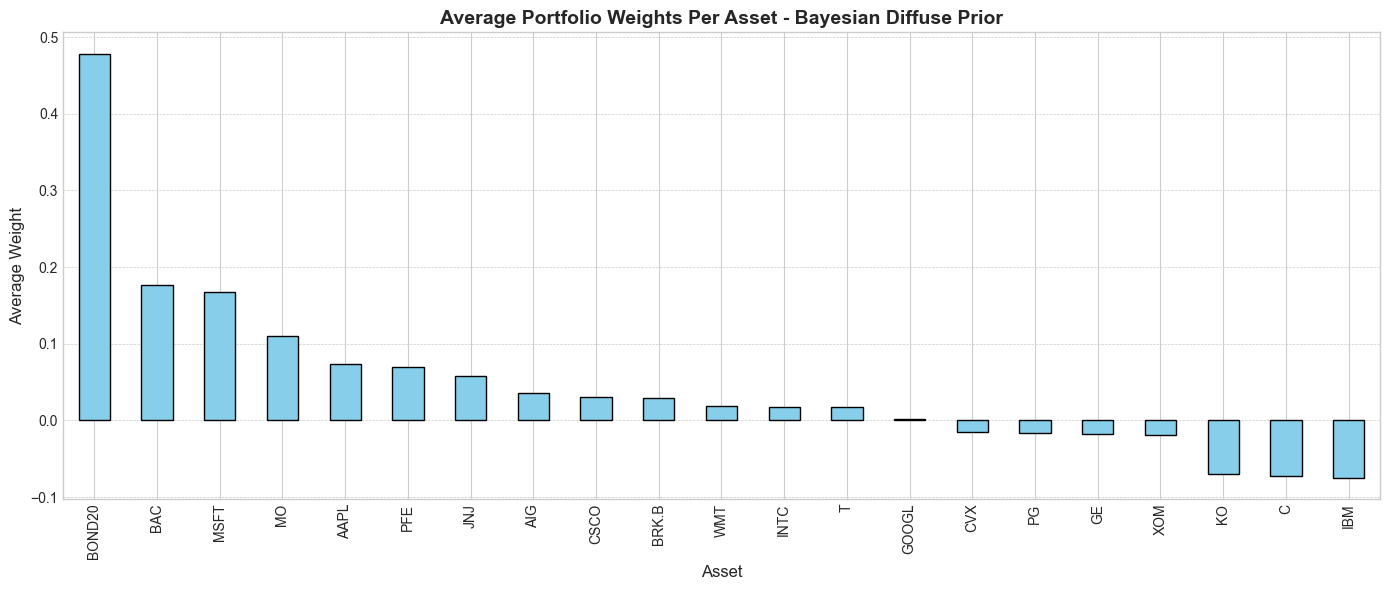


Running Bayesian strategy: Bayesian Non-info NIW...
Summary for Bayesian Non-info NIW:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                           1.1778                        0.0075   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0558                            0.4625   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                      10.0717       1.1435       0.3946   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.2303            1.2894            0.4744

Plot saved to plots_output/avg_weights_bayesian_bayesian_non-info_niw.png


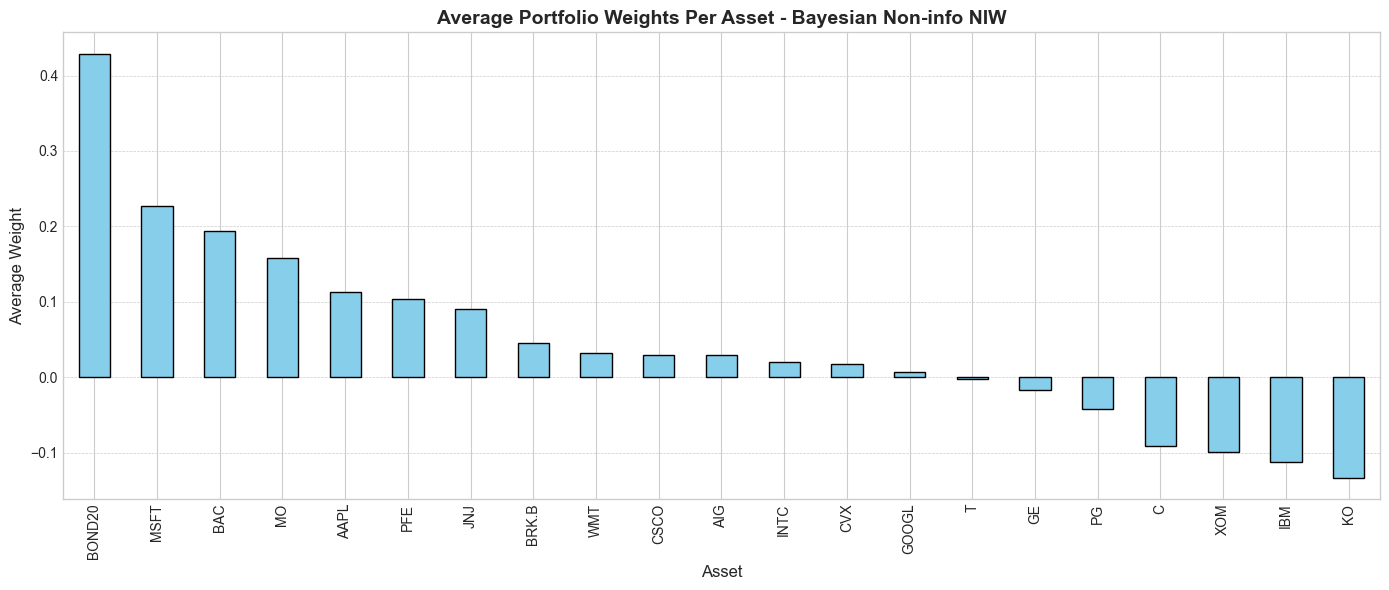


Running Bayesian strategy: Bayesian Diffuse Prior Ridge...
Summary for Bayesian Diffuse Prior Ridge:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                            1.404                        0.0073   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0316                            0.7945   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                        9.813        0.095        0.035   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.0461            0.1462            0.0837

Plot saved to plots_output/avg_weights_bayesian_bayesian_diffuse_prior_ridge.png


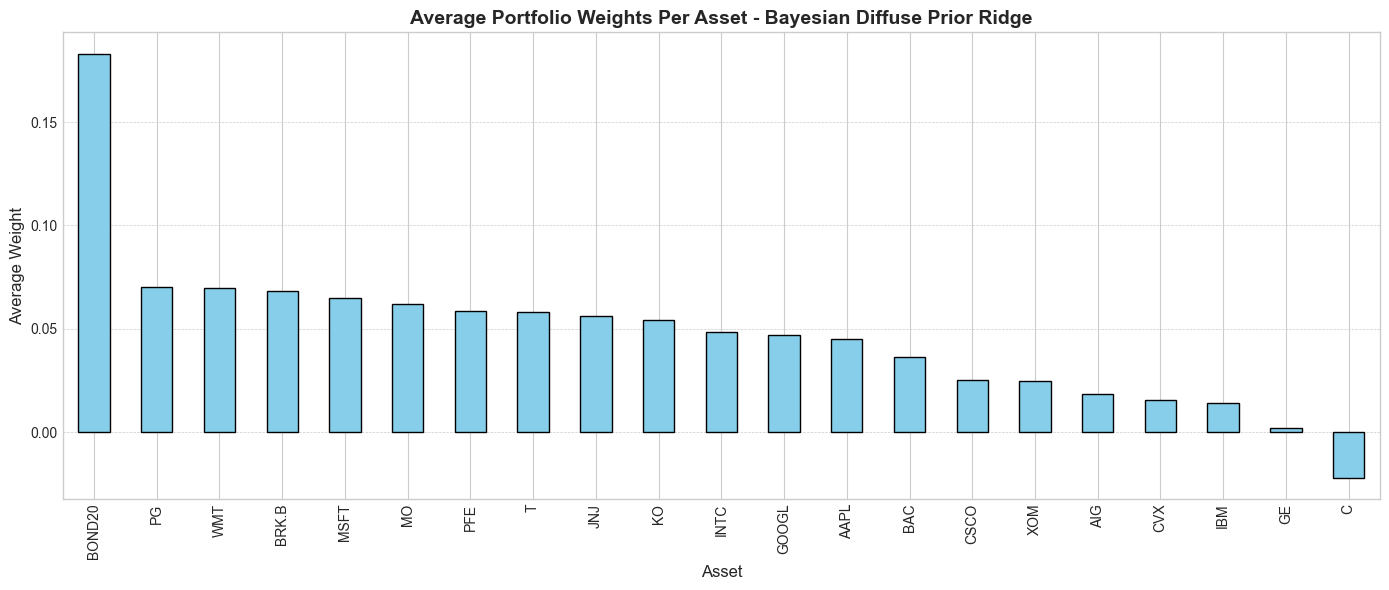


Running Bayesian strategy: Bayesian Non-info NIW Ridge...
Summary for Bayesian Non-info NIW Ridge:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                           1.8107                        0.0087   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0363                            0.8325   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                      11.7501       0.0747       0.0151   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.0354            0.1396            0.0536

Plot saved to plots_output/avg_weights_bayesian_bayesian_non-info_niw_ridge.png


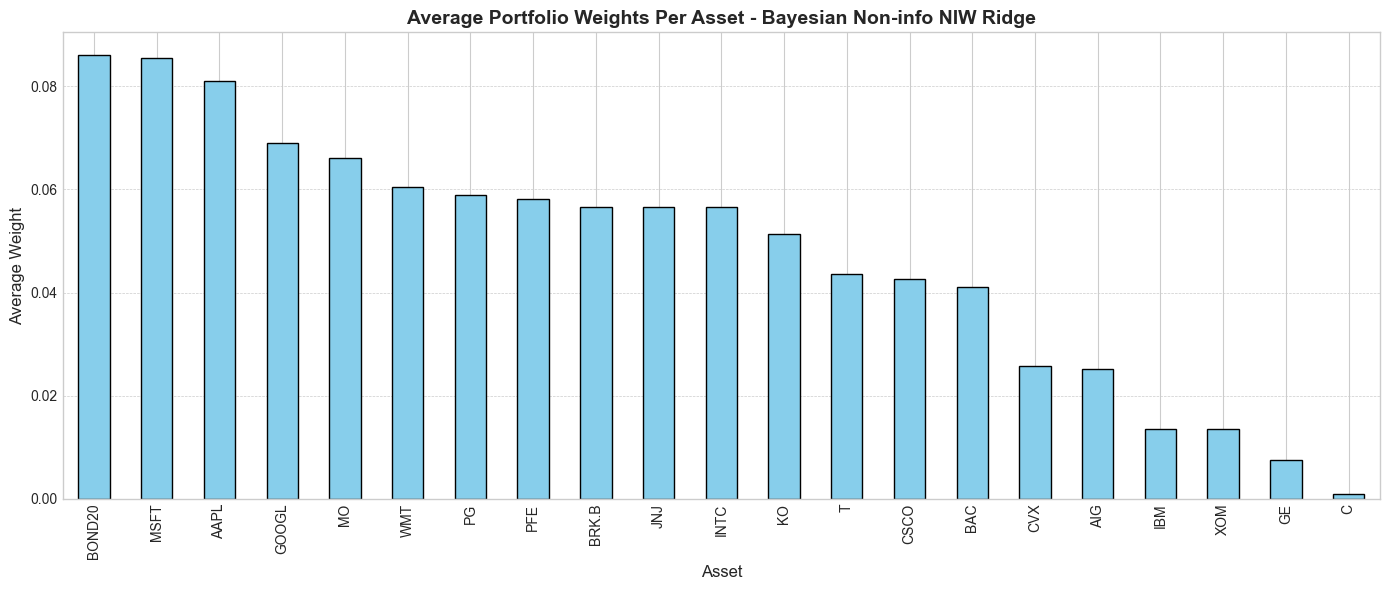


Running Bayesian strategy: Bayesian Hist-info NIW...
Summary for Bayesian Hist-info NIW:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                           1.9216                        0.0096   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0501                            0.6653   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                      12.9543       0.7775       0.2567   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.1882            0.9497            0.3323

Plot saved to plots_output/avg_weights_bayesian_bayesian_hist-info_niw.png


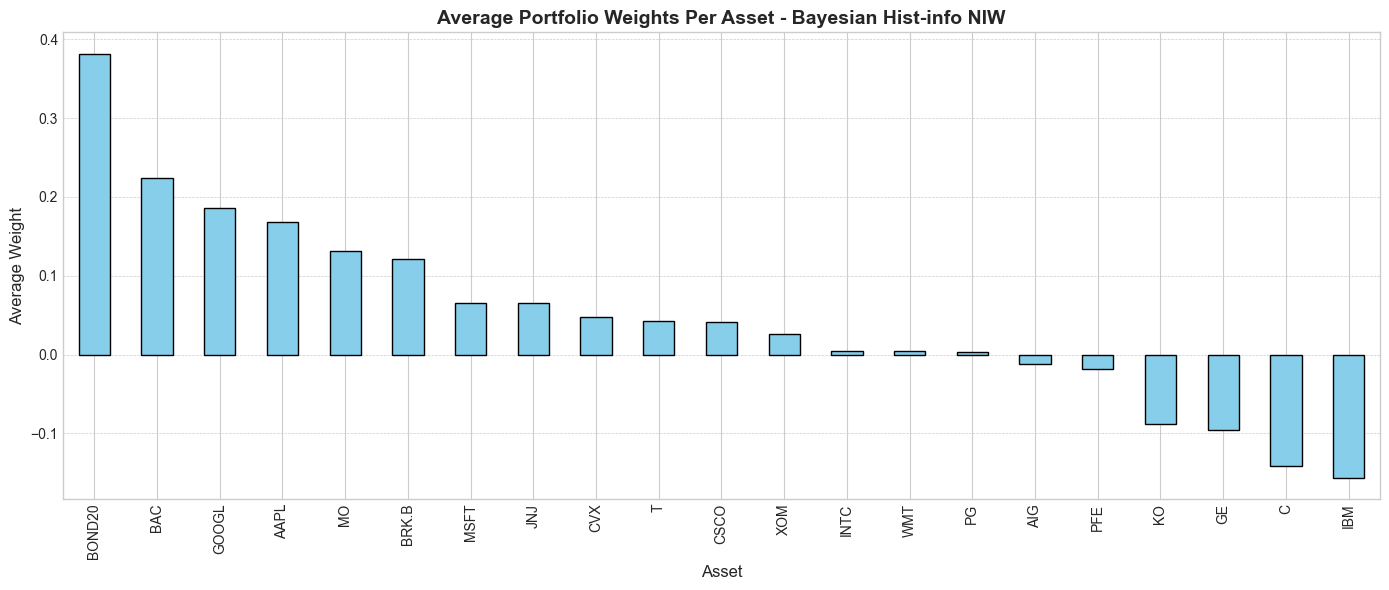

In [17]:
# --- Define and Run Bayesian (Non-CAPM) Backtesting Strategies ---
print("--- Section 8: Bayesian Rolling Window Strategies (Non-CAPM based) ---")
if 'historical_excess_returns_prior_df' not in locals(): historical_excess_returns_prior_df = pd.DataFrame()
if 'sample_historical_covariance_prior' not in locals(): sample_historical_covariance_prior = pd.DataFrame()

bayesian_strategies_to_run = {
    "Bayesian Diffuse Prior": {"posterior_fn": bayesian_estimators.bayesian_diffuse_prior_moments, "constraint_fn": portfolio_optimizers.unconstrained, "ridge": False, "posterior_kwargs": {}},
    "Bayesian Non-info NIW": {"posterior_fn": bayesian_estimators.informative_bayes_predictive_niw, "constraint_fn": portfolio_optimizers.unconstrained, "ridge": False, "posterior_kwargs": {"use_flat_mean_prior": True, "tau_prior_confidence": 1e-6, "use_flat_cov_prior": True}},
    "Bayesian Diffuse Prior Ridge": {"posterior_fn": bayesian_estimators.bayesian_diffuse_prior_moments, "constraint_fn": portfolio_optimizers.unconstrained_ridge, "ridge": True, "lambda_ridge": 0.1, "posterior_kwargs": {}},
    "Bayesian Non-info NIW Ridge": {"posterior_fn": bayesian_estimators.informative_bayes_predictive_niw, "constraint_fn": portfolio_optimizers.unconstrained_ridge, "ridge": True, "lambda_ridge": 0.1, "posterior_kwargs": {"use_flat_mean_prior": True, "tau_prior_confidence": 1e-6, "use_flat_cov_prior": True}}
}

if not historical_excess_returns_prior_df.empty and not sample_historical_covariance_prior.empty:
    common_assets_hist_strat = excess_returns_df.columns.intersection(historical_excess_returns_prior_df.columns)
    if len(common_assets_hist_strat) > 1:
        bayesian_strategies_to_run["Bayesian Hist-info NIW"] = {
            "posterior_fn": bayesian_estimators.informative_bayes_predictive_niw,
            "constraint_fn": portfolio_optimizers.unconstrained, "ridge": False,
            "posterior_kwargs": {
                "eta_prior_mean": historical_excess_returns_prior_df.reindex(columns=excess_returns_df.columns).mean().fillna(historical_excess_returns_prior_df.mean().mean()).values,
                "tau_prior_confidence": 15, "nu_prior_dof": float(excess_returns_df.shape[1] + 2),
                "default_prior_historical_mean": historical_excess_returns_prior_df.mean().mean(),
                "default_prior_historical_var": historical_excess_returns_prior_df.var().mean(),
                "use_flat_mean_prior": False, "use_flat_cov_prior": False,
            }
        }

bayesian_results_collection = {}
bayesian_cumulative_returns_collection = {}
bayesian_weights_collection = {}

for strat_name, config in bayesian_strategies_to_run.items():
    print(f"\nRunning Bayesian strategy: {strat_name}...")
    weights_df, strategy_excess_returns_series = backtesting_engine.run_bayesian_strategy(
        excess_returns_df=excess_returns_df, estimation_window=ESTIMATION_WINDOW, holding_period=HOLDING_PERIOD,
        risk_limit_target_vol=RISK_LIMIT_TARGET_VOL, constraint_fn=config["constraint_fn"],
        posterior_fn=config["posterior_fn"], portfolio_solver_fn=portfolio_optimizers.solve_portfolio,
        ridge=config.get("ridge", False), lambda_ridge=config.get("lambda_ridge", 0.1),
        **config["posterior_kwargs"]
    )
    summary_df, allocation_diag_df, cum_total_rebased100, turnover_s = \
        backtesting_engine.summarize_performance(weights_df, strategy_excess_returns_series, risk_free_series)
    bayesian_results_collection[strat_name] = summary_df
    bayesian_cumulative_returns_collection[strat_name] = cum_total_rebased100
    bayesian_weights_collection[strat_name] = weights_df
    print(f"Summary for {strat_name}:"); display(summary_df.round(4))
    s_name = strat_name.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('.', '')
    summary_df.to_csv(os.path.join(RESULTS_DIR, f"summary_bayesian_{s_name}.csv"))
    weights_df.to_csv(os.path.join(RESULTS_DIR, f"weights_bayesian_{s_name}.csv"))
    if not turnover_s.empty: turnover_s.to_csv(os.path.join(RESULTS_DIR, f"turnover_bayesian_{s_name}.csv"))
    if not allocation_diag_df.empty: plotting_utils.plot_average_weights_bar(allocation_diag_df["Average Weight"], strat_name, output_path=os.path.join(PLOTS_DIR, f"avg_weights_bayesian_{s_name}.png"))

Backtesting results for Bayesian (Non-CAPM) strategies are saved and displayed.

Plot saved to plots_output/cumulative_returns_bayesian_non_capm_strategies.png


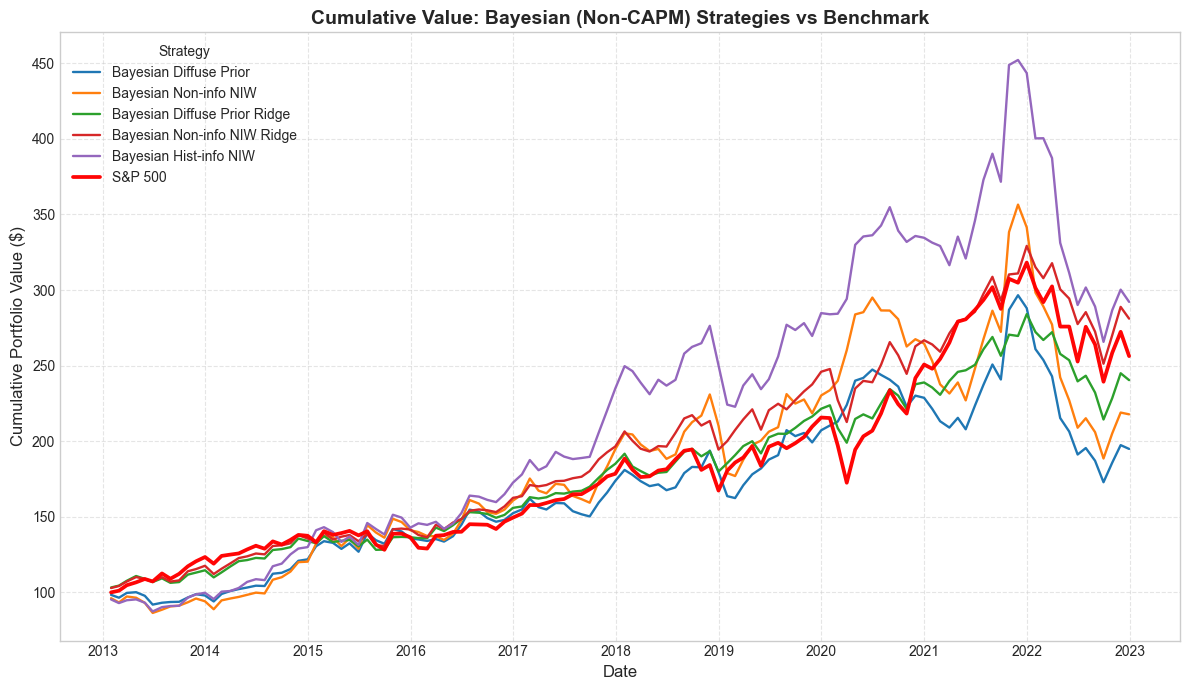

Plot saved to plots_output/metrics_comparison_bayesian_non_capm_strategies.png


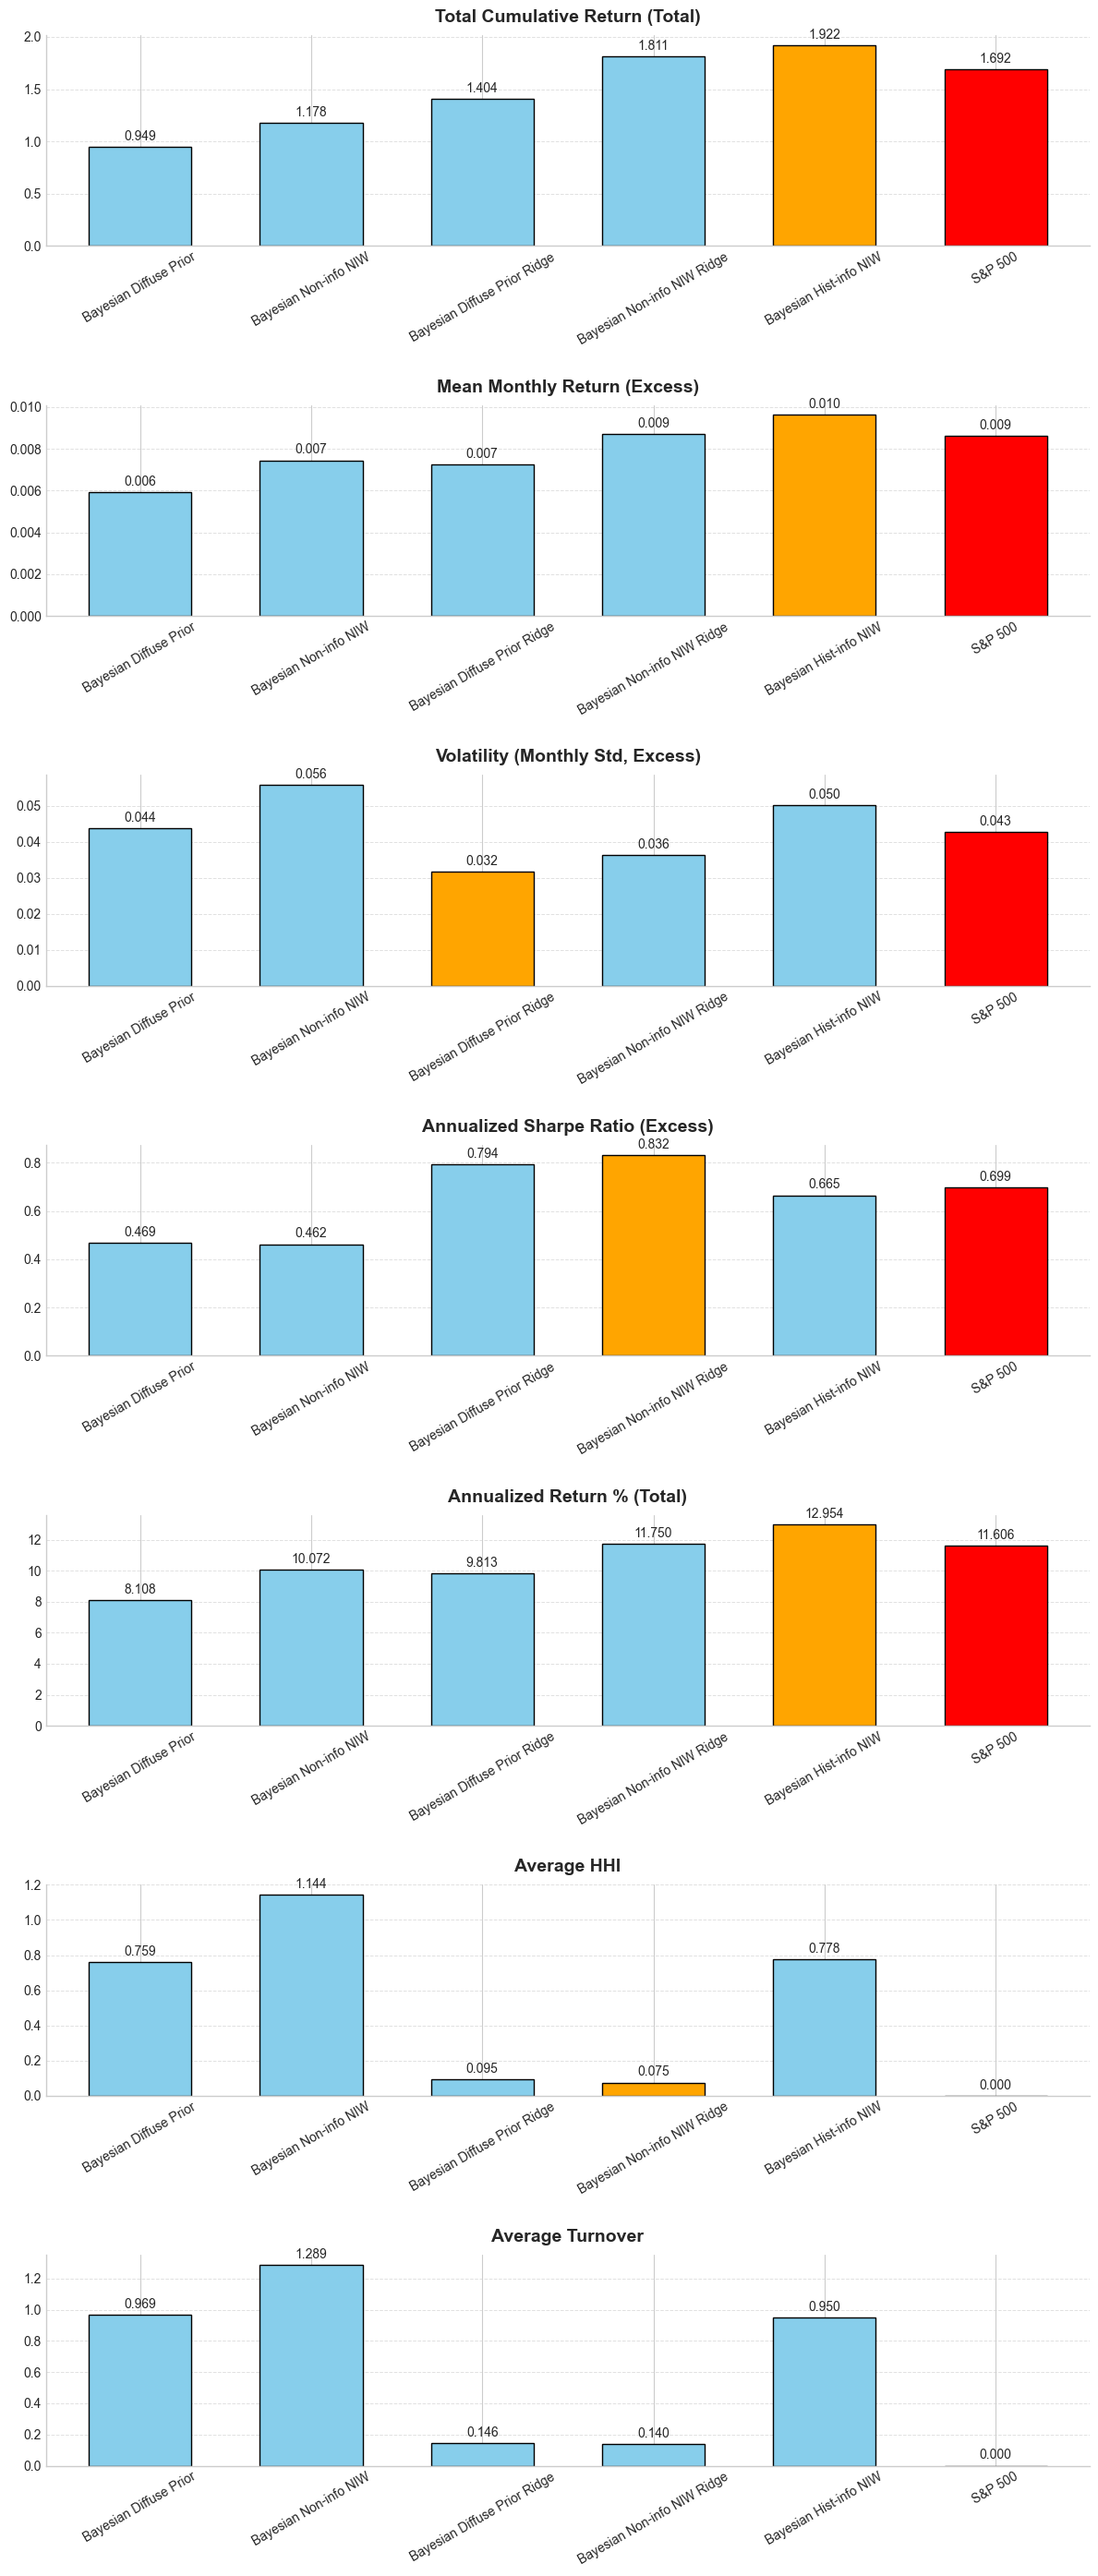

Plot saved to plots_output/cumulative_returns_classical_vs_bayesian_non_capm.png


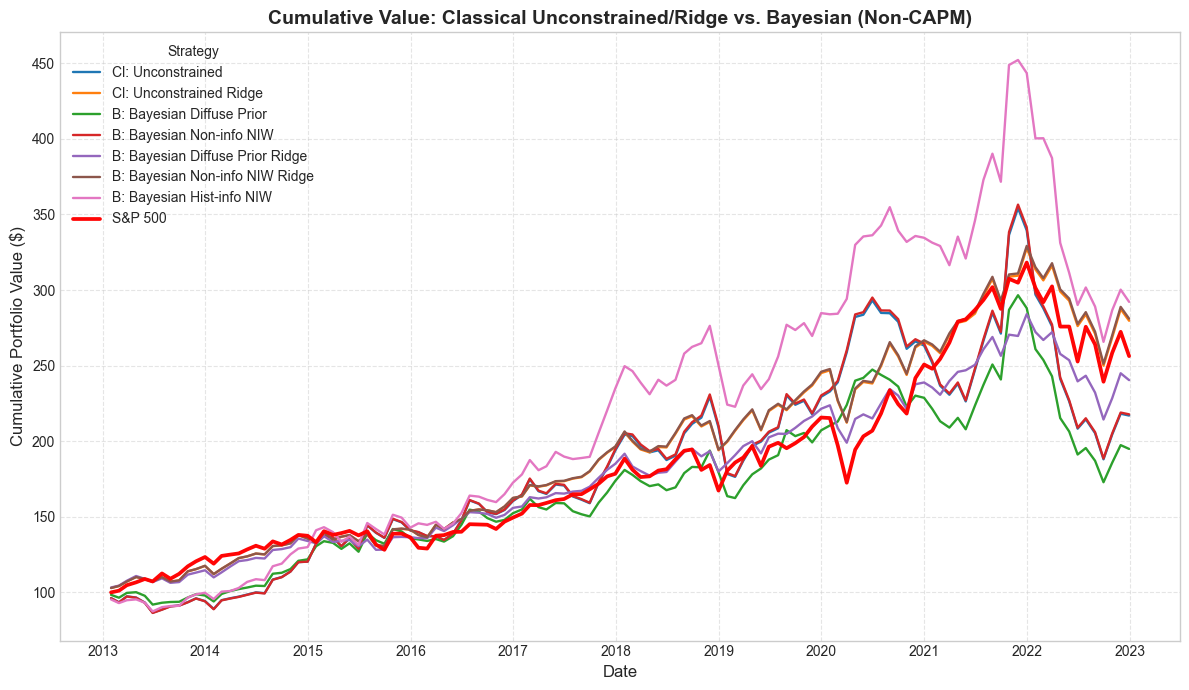

In [18]:
# --- Compare Cumulative Returns of Bayesian (Non-CAPM) Strategies ---
if bayesian_cumulative_returns_collection:
    plotting_utils.plot_strategy_cumulative_returns_comparison(
        bayesian_cumulative_returns_collection,
        benchmark_series=benchmark_cum_total_for_plot_classical if 'benchmark_cum_total_for_plot_classical' in locals() else None,
        benchmark_label="S&P 500",
        title="Cumulative Value: Bayesian (Non-CAPM) Strategies vs Benchmark",
        output_path=os.path.join(PLOTS_DIR, "cumulative_returns_bayesian_non_capm_strategies.png")
    )

# --- Compare Performance Metrics of Bayesian (Non-CAPM) Strategies ---
if bayesian_results_collection:
    all_bayesian_summaries_df = pd.concat([df.assign(Strategy=name) for name, df in bayesian_results_collection.items()]).set_index("Strategy")
    if 'benchmark_summary_for_plot_classical_metrics' in locals() and benchmark_summary_for_plot_classical_metrics is not None:
         all_bayesian_summaries_df = pd.concat([all_bayesian_summaries_df, benchmark_summary_for_plot_classical_metrics])
    if 'metrics_to_plot_list' in locals() and 'maximize_metrics_set' in locals():
        for metric in metrics_to_plot_list:
            if metric not in all_bayesian_summaries_df.columns: all_bayesian_summaries_df[metric] = np.nan
        plotting_utils.plot_strategy_metrics_comparison_bar(
            all_bayesian_summaries_df, metrics_to_plot=metrics_to_plot_list,
            benchmark_name="S&P 500", maximize_metrics=maximize_metrics_set,
            output_path=os.path.join(PLOTS_DIR, "metrics_comparison_bayesian_non_capm_strategies.png")
        )

# --- Combined plot: Classical Unconstrained & Ridge vs. Bayesian (Non-CAPM) Strategies ---
plot_classical_vs_bayes_cum_returns = {}
if 'classical_cumulative_returns_collection' in locals():
    if "Unconstrained" in classical_cumulative_returns_collection: plot_classical_vs_bayes_cum_returns["Cl: Unconstrained"] = classical_cumulative_returns_collection["Unconstrained"]
    if "Unconstrained Ridge" in classical_cumulative_returns_collection: plot_classical_vs_bayes_cum_returns["Cl: Unconstrained Ridge"] = classical_cumulative_returns_collection["Unconstrained Ridge"]
for name, series in bayesian_cumulative_returns_collection.items(): plot_classical_vs_bayes_cum_returns[f"B: {name}"] = series
if plot_classical_vs_bayes_cum_returns:
    plotting_utils.plot_strategy_cumulative_returns_comparison(
        plot_classical_vs_bayes_cum_returns,
        benchmark_series=benchmark_cum_total_for_plot_classical if 'benchmark_cum_total_for_plot_classical' in locals() else None,
        benchmark_label="S&P 500",
        title="Cumulative Value: Classical Unconstrained/Ridge vs. Bayesian (Non-CAPM)",
        output_path=os.path.join(PLOTS_DIR, "cumulative_returns_classical_vs_bayesian_non_capm.png")
    )

Comparative plots for Bayesian (Non-CAPM) strategies are displayed.

## 9. Bayesian CAPM Framework & Efficient Frontier
Introduces Bayesian CAPM, estimates predictive moments, and plots its efficient frontier compared to Classical MVO.

--- Section 9: Bayesian CAPM Framework & Efficient Frontier ---
Bayesian CAPM predictive mean (first 5): [0.0028453  0.01159004 0.01008706 0.01071994 0.02075697]


0         1         2         3         4
0  0.005403  0.002030  0.001727  0.002665  0.002110
1  0.002030  0.006577  0.002008  0.003099  0.002454
2  0.001727  0.002008  0.006212  0.002637  0.002088
3  0.002665  0.003099  0.002637  0.064219  0.003222
4  0.002110  0.002454  0.002088  0.003222  0.008173

Plot saved to plots_output/efficient_frontier_bayesian_capm_vs_classical.png


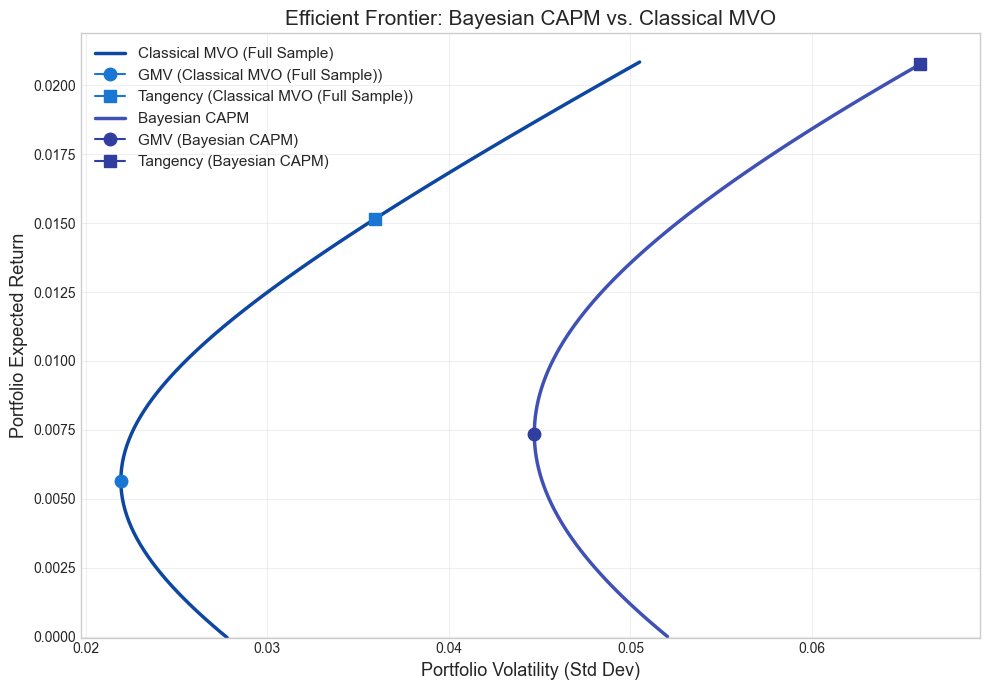

In [19]:
# --- Bayesian CAPM Estimation and Efficient Frontier ---
print("--- Section 9: Bayesian CAPM Framework & Efficient Frontier ---")
mu_bcapm, sigma_bcapm, tr_bcapm, pv_bcapm = (None, None, np.array([]), np.array([]))
bayesian_capm_ef_plot_data_list = [] 

if 'excess_returns_df' in locals() and not excess_returns_df.empty and 'benchmark_excess_returns_series' in locals() and not benchmark_excess_returns_series.empty:
    mu_bcapm, sigma_bcapm = bayesian_estimators.bayesian_capm_estimation(excess_returns_df, benchmark_excess_returns_series)
    print("Bayesian CAPM predictive mean (first 5):", mu_bcapm[:5] if mu_bcapm is not None else 'None')
    if sigma_bcapm is not None: display(pd.DataFrame(sigma_bcapm).iloc[:5, :5])
    if mu_bcapm is not None: pd.Series(mu_bcapm, index=excess_returns_df.columns).to_csv(os.path.join(RESULTS_DIR, "bcapm_predictive_mean.csv"))
    if sigma_bcapm is not None: pd.DataFrame(sigma_bcapm, index=excess_returns_df.columns, columns=excess_returns_df.columns).to_csv(os.path.join(RESULTS_DIR, "bcapm_predictive_covariance.csv"))
    if mu_bcapm is not None and sigma_bcapm is not None:
        tr_bcapm, pv_bcapm, _ = portfolio_optimizers.compute_efficient_frontier_from_moments(mu_bcapm, sigma_bcapm)
        valid_bcapm_ef = ~np.isnan(pv_bcapm) & ~np.isnan(tr_bcapm)
        if np.sum(valid_bcapm_ef) > 1:
            pv_b_valid, tr_b_valid = pv_bcapm[valid_bcapm_ef], tr_bcapm[valid_bcapm_ef]
            gmv_idx, tan_idx = np.nanargmin(pv_b_valid), np.nanargmax(((tr_b_valid-RISK_FREE_RATE_FOR_SHARPE)/pv_b_valid)[np.isfinite((tr_b_valid-RISK_FREE_RATE_FOR_SHARPE)/pv_b_valid) & (pv_b_valid > 1e-9)])
            actual_tan_idx = np.where(np.isfinite((tr_b_valid-RISK_FREE_RATE_FOR_SHARPE)/pv_b_valid) & (pv_b_valid > 1e-9))[0][tan_idx]
            gmv_pt_bcapm = (pv_b_valid[gmv_idx], tr_b_valid[gmv_idx])
            tan_pt_bcapm = (pv_b_valid[actual_tan_idx], tr_b_valid[actual_tan_idx])
            bayesian_capm_ef_plot_data_list.append((pv_b_valid, tr_b_valid, "Bayesian CAPM", gmv_pt_bcapm, tan_pt_bcapm, {'line_color': '#3F51B5', 'dot_color': '#303F9F', 'line_style': '-'}))
            if 'classical_frontier_plot_data' in locals() and classical_frontier_plot_data: bayesian_capm_ef_plot_data_list.insert(0, classical_frontier_plot_data[0])
            
            all_vols_bc_plot = np.concatenate([f[0] for f in bayesian_capm_ef_plot_data_list if len(f[0]) > 0 and np.any(~np.isnan(f[0]))])
            all_rets_bc_plot = np.concatenate([f[1] for f in bayesian_capm_ef_plot_data_list if len(f[1]) > 0 and np.any(~np.isnan(f[1]))])
            xlim_bc_eff, ylim_bc_eff = (None,None)
            if len(all_vols_bc_plot)>0 and len(all_rets_bc_plot)>0:
                min_v,max_v = np.nanmin(all_vols_bc_plot),np.nanmax(all_vols_bc_plot)
                min_r,max_r = np.nanmin(all_rets_bc_plot),np.nanmax(all_rets_bc_plot)
                xlim_bc_eff=(max(0,min_v*0.9),max_v*1.05)
                ylim_bc_eff=(min_r-abs(min_r*0.05) if min_r<0 else min_r*0.9,max_r*1.05)
            plotting_utils.plot_efficient_frontier(bayesian_capm_ef_plot_data_list, title="Efficient Frontier: Bayesian CAPM vs. Classical MVO", xlim=xlim_bc_eff,ylim=ylim_bc_eff, plot_cml=True, risk_free_rate=RISK_FREE_RATE_FOR_SHARPE, output_path=os.path.join(PLOTS_DIR, "efficient_frontier_bayesian_capm_vs_classical.png"))
        else: print("Not enough valid points for Bayesian CAPM EF plot.")
else: print("Core or benchmark excess returns missing for Bayesian CAPM EF.")
if 'bayesian_capm_results_collection' not in locals(): 
    bayesian_capm_results_collection = {}
    bayesian_capm_cumulative_returns_collection = {}
    bayesian_capm_weights_collection = {}

The Bayesian CAPM efficient frontier is plotted against the classical MVO frontier.

## 10. Bayesian CAPM-based Rolling Window Strategies
Backtests strategies derived from Bayesian CAPM estimates or using them as priors.

--- Section 10: Bayesian CAPM-based Rolling Window Strategies ---

Running Bayesian CAPM-based strategy: MVO (Bayesian CAPM moments)...


/Users/andreavento/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/andreavento/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/andreavento/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/andreavento/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/a

Summary for MVO (Bayesian CAPM moments):


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                           1.6817                        0.0085   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0401                            0.7319   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                      11.4173        0.059       0.0032   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.0236            0.0585            0.0347

Plot saved to plots_output/avg_weights_bcapm_mvo_bayesian_capm_moments.png


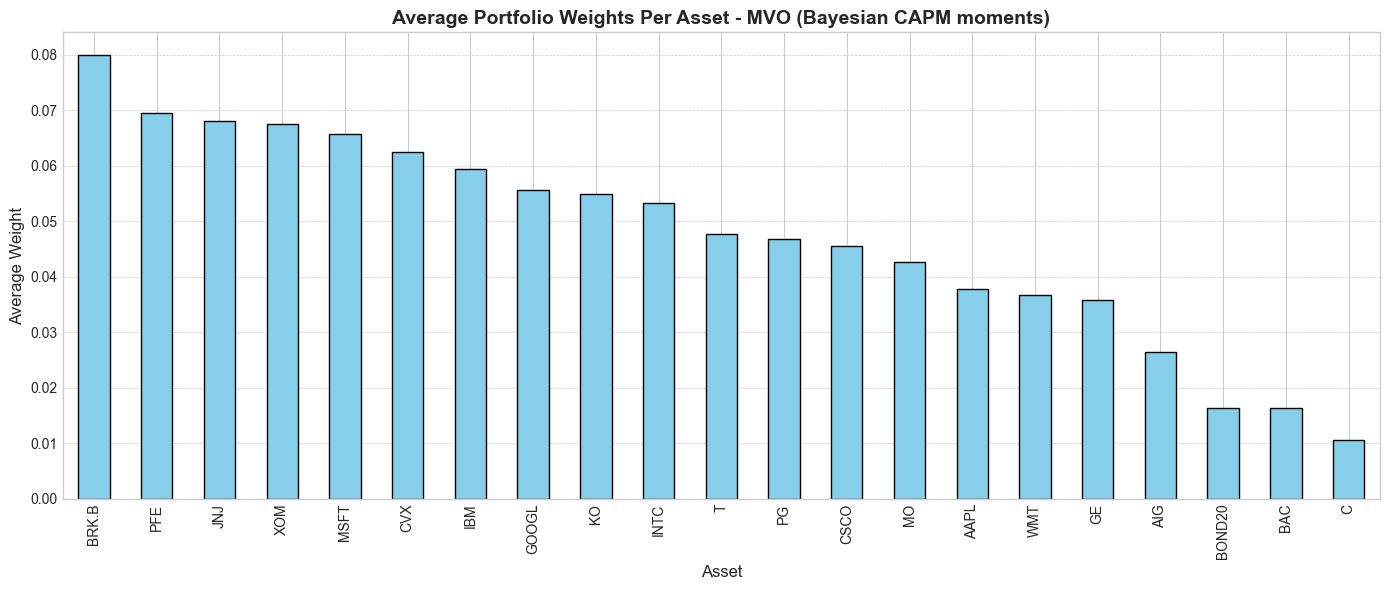


Running Bayesian CAPM-based strategy: NIW (Bayesian CAPM prior)...


/Users/andreavento/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/Users/andreavento/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Summary for NIW (Bayesian CAPM prior):


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                           2.1067                        0.0095   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0352                            0.9364   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                      12.8215        0.159       0.0235   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.0742            0.3111            0.1304

Plot saved to plots_output/avg_weights_bcapm_niw_bayesian_capm_prior.png


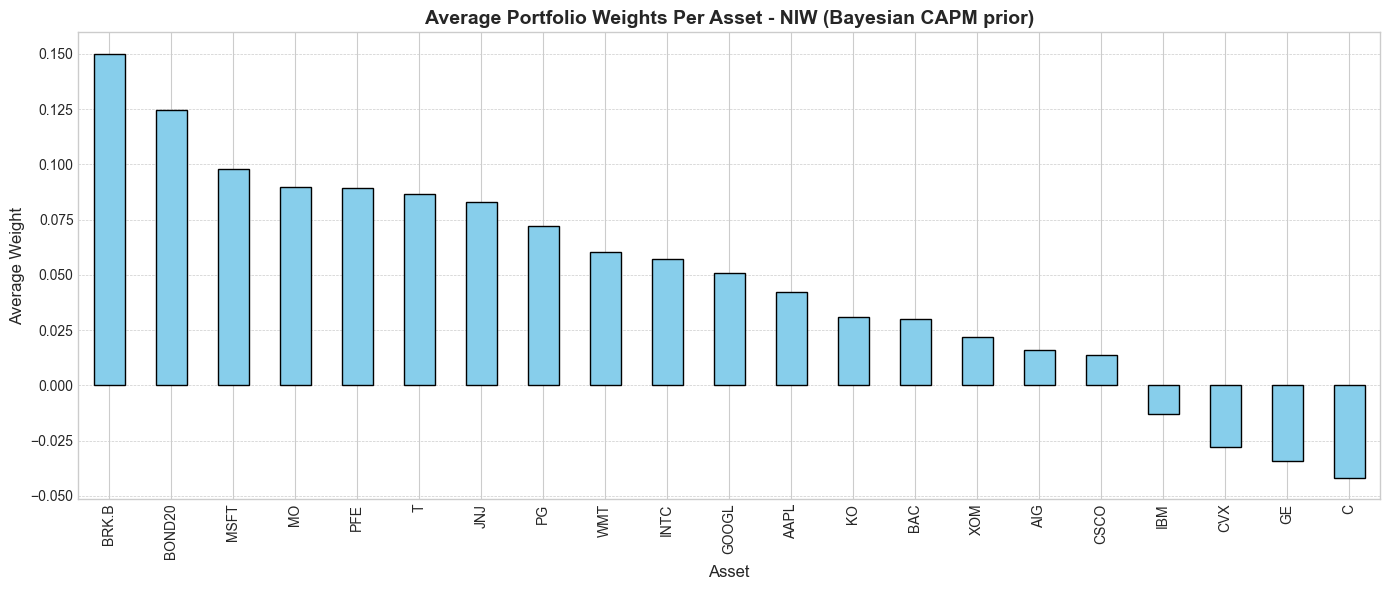


Running Bayesian CAPM-based strategy: NIW (Bayesian CAPM prior) Ridge...
Summary for NIW (Bayesian CAPM prior) Ridge:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                            1.612                         0.008   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0346                            0.8049   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                      10.8569       0.0976       0.0451   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.0449            0.1748            0.1191

Plot saved to plots_output/avg_weights_bcapm_niw_bayesian_capm_prior_ridge.png


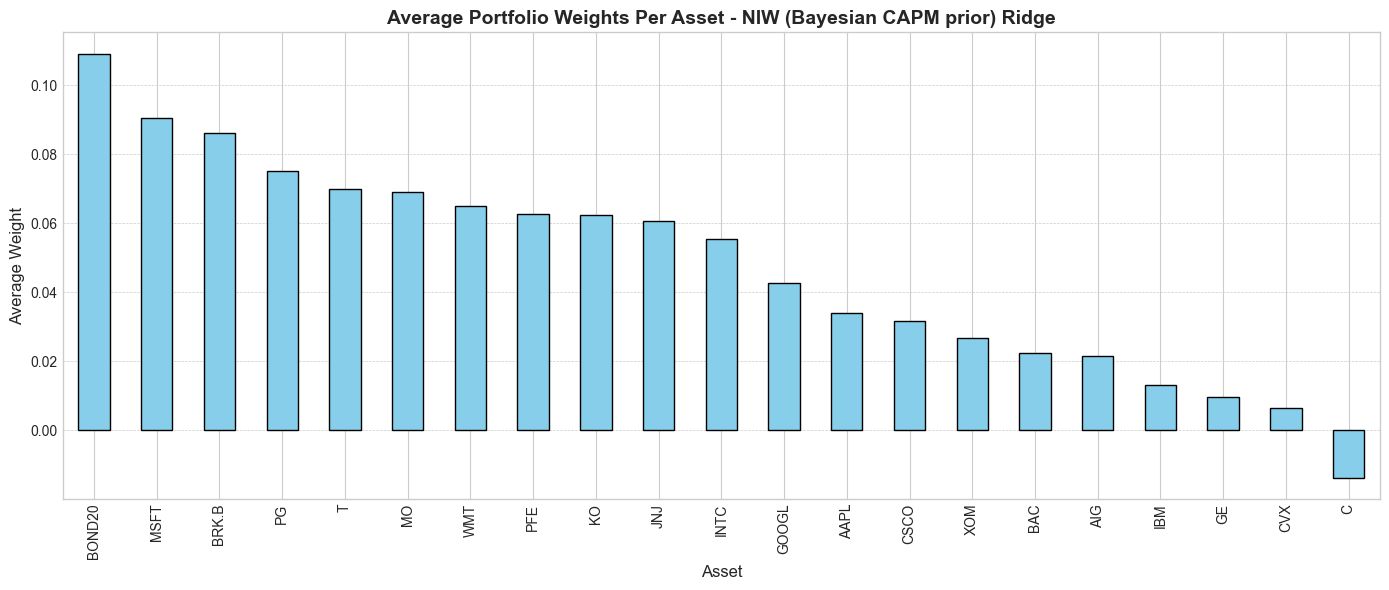


Running Mixed Prior strategy: Mixed Hist-CAPM NIW...
Summary for Mixed Hist-CAPM NIW:


Total Cumulative Return (Total)  Mean Monthly Return (Excess)  \
0                           2.1473                        0.0097   

   Volatility (Monthly Std, Excess)  Annualized Sharpe Ratio (Excess)  \
0                            0.0377                            0.8937   

   Annualized Return % (Total)  Average HHI  HHI Std Dev  \
0                      13.0833       0.2408       0.0418   

   Avg Rolling Weight Std Dev  Average Turnover  Turnover Std Dev  
0                      0.0977            0.4406            0.1575

Plot saved to plots_output/avg_weights_mixed_mixed_hist_capm_niw.png


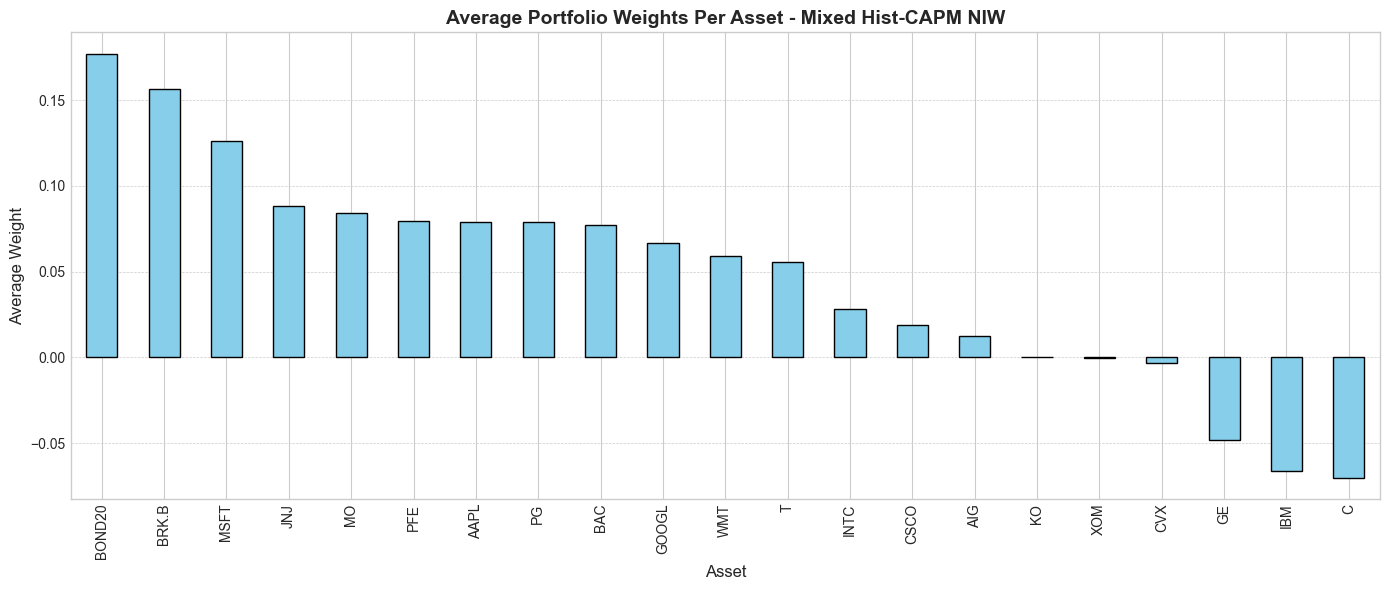

In [20]:
# --- Define and Run Bayesian CAPM-based Backtesting Strategies ---
print("--- Section 10: Bayesian CAPM-based Rolling Window Strategies ---")
if 'excess_returns_df' not in locals() or 'benchmark_excess_returns_series' not in locals() or excess_returns_df.empty or benchmark_excess_returns_series.empty:
    print("Skipping Bayesian CAPM-based backtests due to missing data.")
else:
    bayesian_capm_strategies_to_run = {
        "MVO (Bayesian CAPM moments)": {"posterior_fn": bayesian_estimators.bayesian_capm_posterior_moments, "constraint_fn": portfolio_optimizers.unconstrained, "ridge": False, "adaptive_risk": True, "posterior_kwargs": {}},
        "NIW (Bayesian CAPM prior)": {"posterior_fn": bayesian_estimators.bayes_conjugate_with_capm_prior_moments, "constraint_fn": portfolio_optimizers.unconstrained, "ridge": False, "adaptive_risk": True, "posterior_kwargs": {"capm_prior_confidence_tau": 10.0, "capm_prior_dof_nu_add": 10.0}},
        "NIW (Bayesian CAPM prior) Ridge": {"posterior_fn": bayesian_estimators.bayes_conjugate_with_capm_prior_moments, "constraint_fn": portfolio_optimizers.unconstrained_ridge, "ridge": True, "lambda_ridge": 0.1, "adaptive_risk": True, "posterior_kwargs": {"capm_prior_confidence_tau": 10.0, "capm_prior_dof_nu_add": 10.0}}
    }
    
    # (Make sure historical_excess_returns_prior_df and sample_historical_covariance_prior are loaded)
    # These are typically loaded in Section 2. Assuming they are available here.
    mixed_hist_capm_strategy = {
        "Mixed Hist-CAPM NIW": {
            "posterior_fn": bayes_niw_with_mixed_hist_capm_prior_moments,
            "constraint_fn": portfolio_optimizers.unconstrained, # Or other like long_only
            "ridge": False,
            "adaptive_risk": True, # Assuming similar to other CAPM strategies
            "posterior_kwargs": {
                "historical_excess_returns_prior_df_global": historical_excess_returns_prior_df if 'historical_excess_returns_prior_df' in locals() else pd.DataFrame(),
                "historical_covariance_prior_df_global": sample_historical_covariance_prior if 'sample_historical_covariance_prior' in locals() else pd.DataFrame(),
                # These are confidence/DoF for the NIW update using the mixed prior
                "mixed_prior_confidence_tau": 10.0, 
                "mixed_prior_dof_nu_add": 10.0,
                # capm_kwargs for the CAPM *component* of the mixed prior
                "capm_kwargs": {} # Default CAPM parameters for the prior calculation
            }
        }
    }
    
    # Initialize collections for this new strategy if they don't exist generally for one-offs
    if 'mixed_strategy_results_collection' not in locals():
        mixed_strategy_results_collection = {}
        mixed_strategy_cumulative_returns_collection = {}
        mixed_strategy_weights_collection = {}
        
    for strat_name, config in bayesian_capm_strategies_to_run.items():
        print(f"\nRunning Bayesian CAPM-based strategy: {strat_name}...")
        weights_df, strategy_excess_returns_series = \
            backtesting_engine.run_custom_bayesian_strategy_with_benchmark(
                excess_returns_df=excess_returns_df, benchmark_returns_series=benchmark_excess_returns_series,
                estimation_window=ESTIMATION_WINDOW, holding_period=HOLDING_PERIOD,
                risk_limit_target_vol=RISK_LIMIT_TARGET_VOL, constraint_fn=config["constraint_fn"],
                posterior_fn=config["posterior_fn"], portfolio_solver_fn=portfolio_optimizers.solve_portfolio,
                gmv_vol_calculator_fn=portfolio_optimizers.compute_gmv_vol if config.get("adaptive_risk") else None,
                ridge=config.get("ridge", False), lambda_ridge=config.get("lambda_ridge", 0.1),
                adaptive_risk_target_vol=RISK_LIMIT_TARGET_VOL if config.get("adaptive_risk") else None,
                **config["posterior_kwargs"]
            )
        summary_df, allocation_diag_df, cum_total_rebased100, turnover_s = \
            backtesting_engine.summarize_performance(weights_df, strategy_excess_returns_series, risk_free_series)
        bayesian_capm_results_collection[strat_name] = summary_df
        bayesian_capm_cumulative_returns_collection[strat_name] = cum_total_rebased100
        bayesian_capm_weights_collection[strat_name] = weights_df
        print(f"Summary for {strat_name}:"); display(summary_df.round(4))
        s_name_bcapm = strat_name.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('.', '')
        summary_df.to_csv(os.path.join(RESULTS_DIR, f"summary_bcapm_{s_name_bcapm}.csv"))
        weights_df.to_csv(os.path.join(RESULTS_DIR, f"weights_bcapm_{s_name_bcapm}.csv"))
        if not turnover_s.empty: turnover_s.to_csv(os.path.join(RESULTS_DIR, f"turnover_bcapm_{s_name_bcapm}.csv"))
        if not allocation_diag_df.empty: plotting_utils.plot_average_weights_bar(allocation_diag_df["Average Weight"], strat_name, output_path=os.path.join(PLOTS_DIR, f"avg_weights_bcapm_{s_name_bcapm}.png"))
    
    # --- Run the new Mixed Hist-CAPM NIW strategy ---
    for strat_name, config in mixed_hist_capm_strategy.items():
        print(f"\nRunning Mixed Prior strategy: {strat_name}...")
        weights_df, strategy_excess_returns_series = \
            backtesting_engine.run_custom_bayesian_strategy_with_benchmark(
                excess_returns_df=excess_returns_df, 
                benchmark_returns_series=benchmark_excess_returns_series,
                estimation_window=ESTIMATION_WINDOW, holding_period=HOLDING_PERIOD,
                risk_limit_target_vol=RISK_LIMIT_TARGET_VOL, 
                constraint_fn=config["constraint_fn"],
                posterior_fn=config["posterior_fn"], 
                portfolio_solver_fn=portfolio_optimizers.solve_portfolio,
                gmv_vol_calculator_fn=portfolio_optimizers.compute_gmv_vol if config.get("adaptive_risk") else None,
                ridge=config.get("ridge", False), 
                lambda_ridge=config.get("lambda_ridge", 0.1),
                adaptive_risk_target_vol=RISK_LIMIT_TARGET_VOL if config.get("adaptive_risk") else None,
                **config["posterior_kwargs"]
            )
        summary_df, allocation_diag_df, cum_total_rebased100, turnover_s = \
            backtesting_engine.summarize_performance(weights_df, strategy_excess_returns_series, risk_free_series)
        
        mixed_strategy_results_collection[strat_name] = summary_df
        mixed_strategy_cumulative_returns_collection[strat_name] = cum_total_rebased100
        mixed_strategy_weights_collection[strat_name] = weights_df
        
        print(f"Summary for {strat_name}:"); display(summary_df.round(4))
        s_name_mixed = strat_name.lower().replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '').replace('.', '')
        summary_df.to_csv(os.path.join(RESULTS_DIR, f"summary_mixed_{s_name_mixed}.csv"))
        weights_df.to_csv(os.path.join(RESULTS_DIR, f"weights_mixed_{s_name_mixed}.csv"))
        if not turnover_s.empty: turnover_s.to_csv(os.path.join(RESULTS_DIR, f"turnover_mixed_{s_name_mixed}.csv"))
        if not allocation_diag_df.empty: 
            plotting_utils.plot_average_weights_bar(
                allocation_diag_df["Average Weight"], 
                strat_name, 
                output_path=os.path.join(PLOTS_DIR, f"avg_weights_mixed_{s_name_mixed}.png")
            )

Performance of Bayesian CAPM-based strategies is summarized and saved.

Plot saved to plots_output/cumulative_returns_bayesian_capm_strategies.png


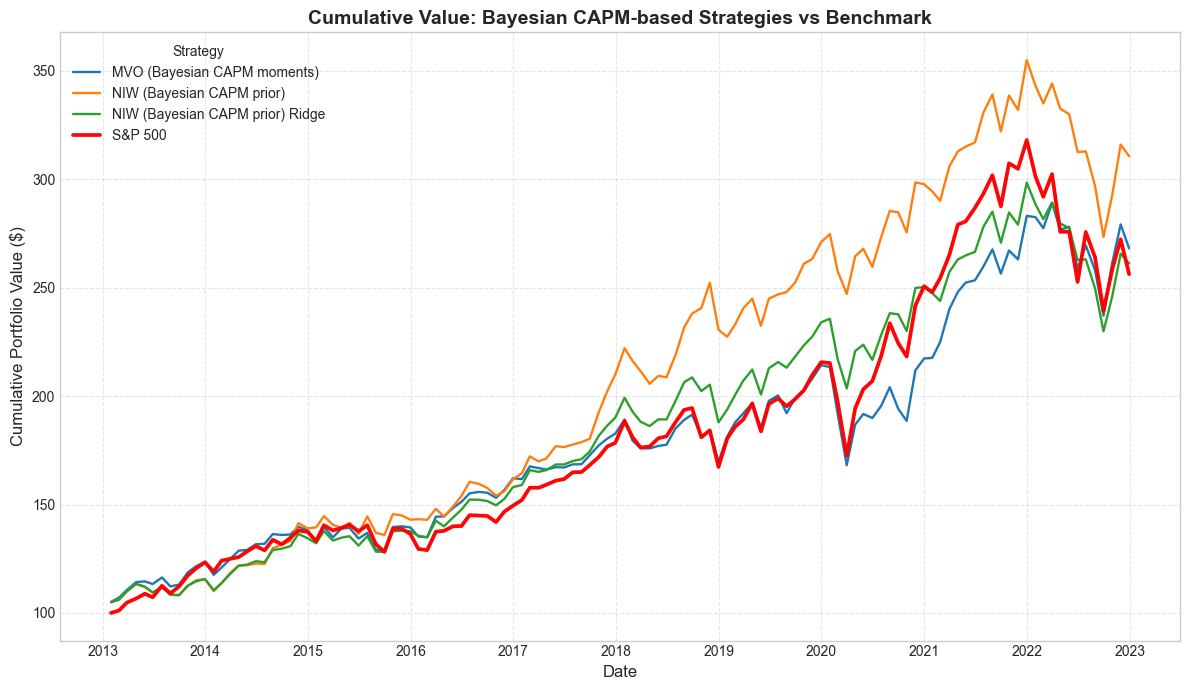

Plot saved to plots_output/metrics_comparison_bayesian_capm_strategies.png


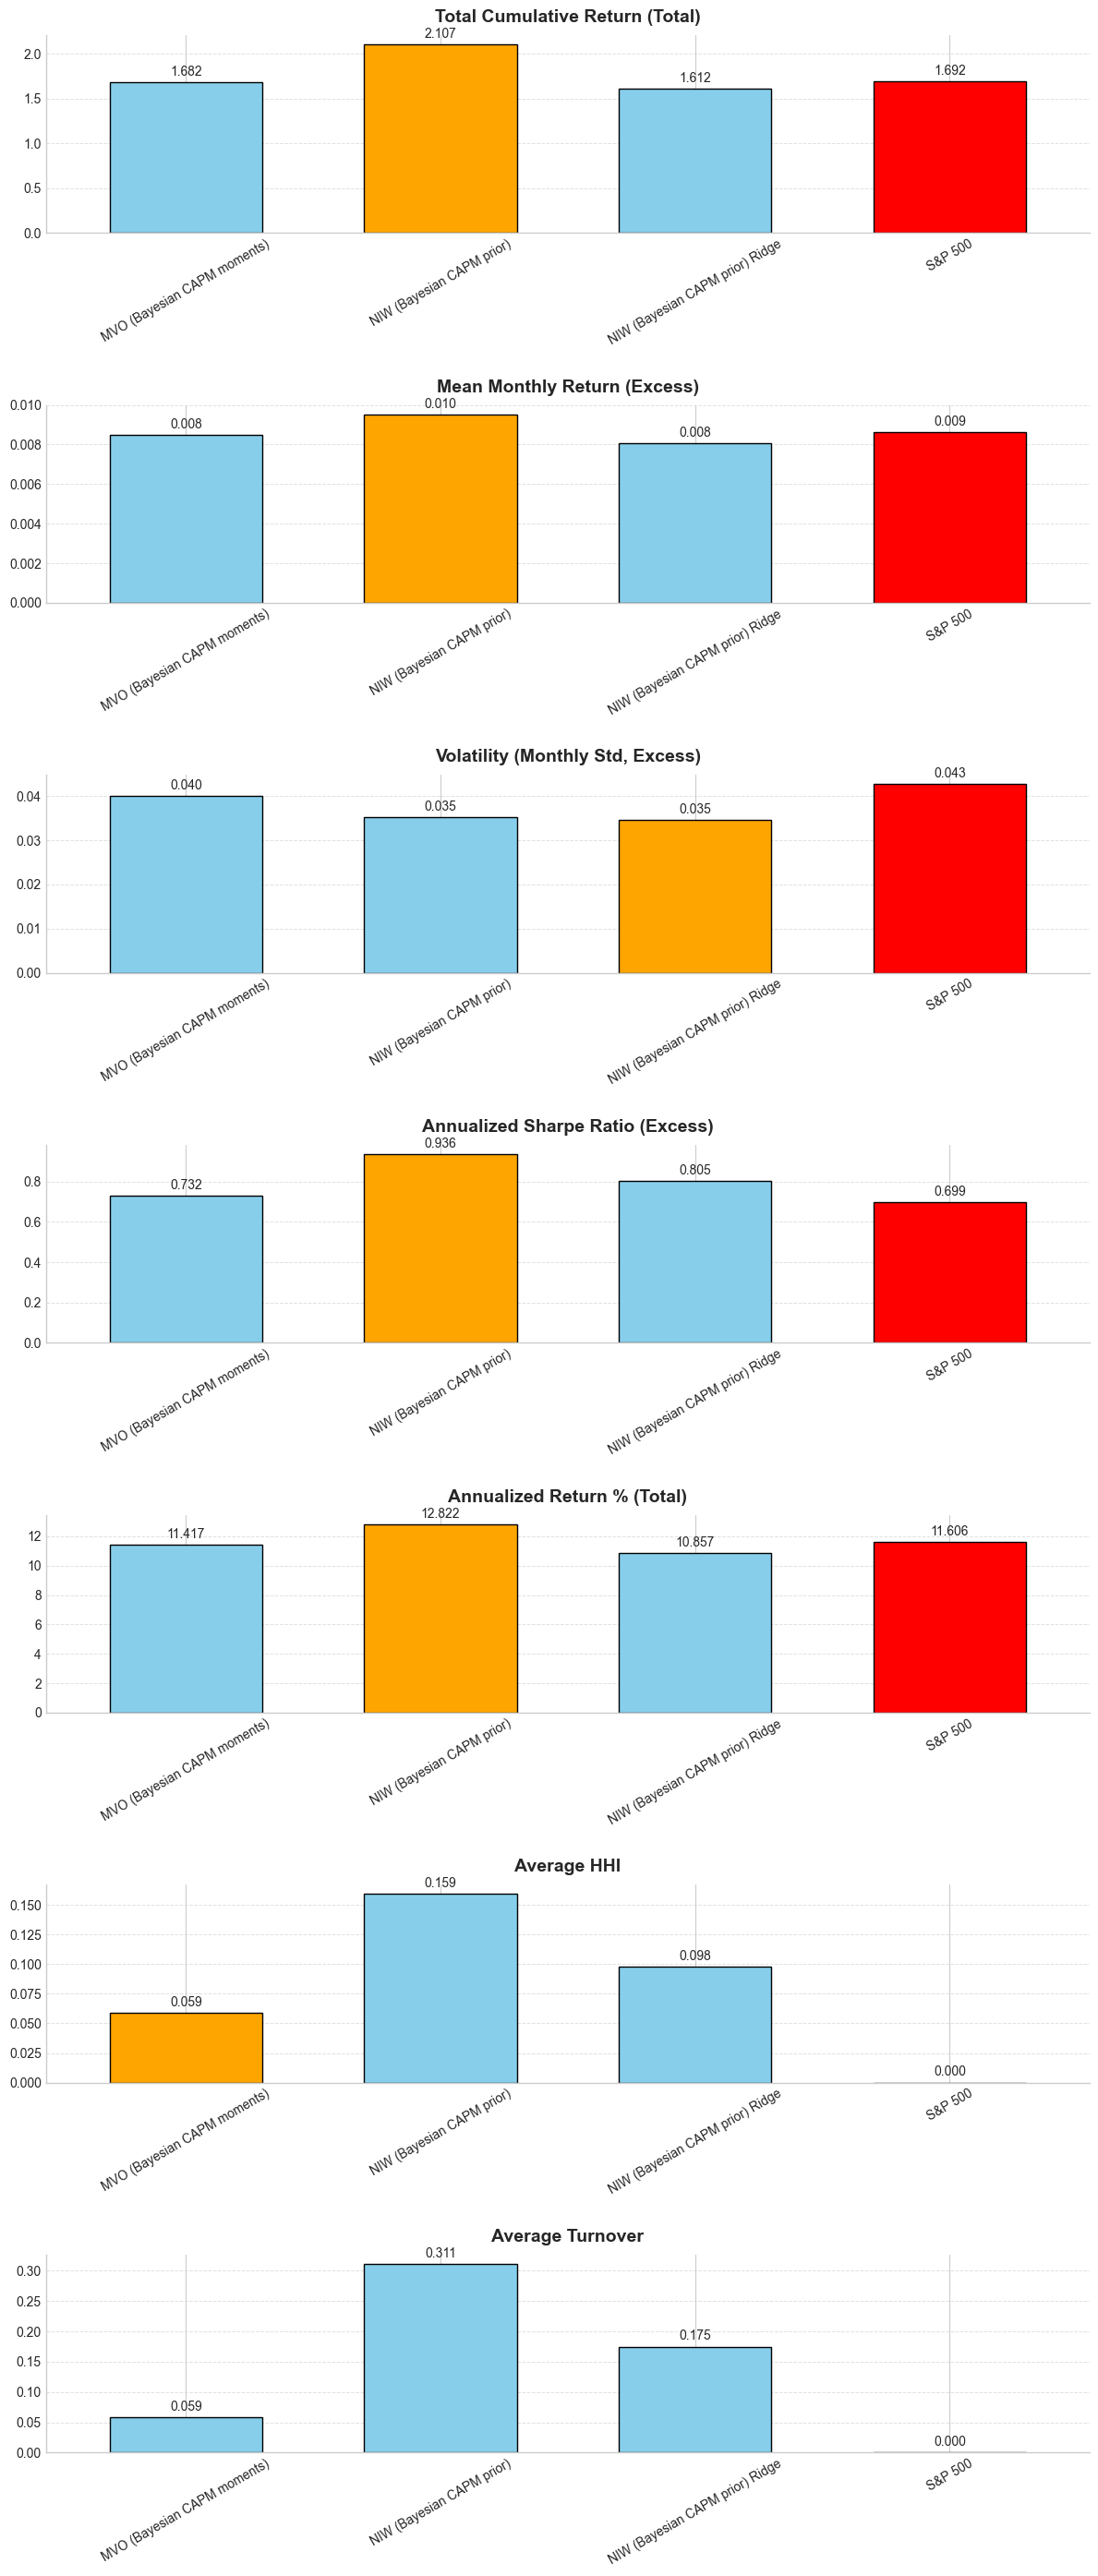

In [21]:
# --- Compare Cumulative Returns of Bayesian CAPM-based Strategies ---
if bayesian_capm_cumulative_returns_collection:
    plotting_utils.plot_strategy_cumulative_returns_comparison(
        bayesian_capm_cumulative_returns_collection,
        benchmark_series=benchmark_cum_total_for_plot_classical if 'benchmark_cum_total_for_plot_classical' in locals() else None,
        benchmark_label="S&P 500",
        title="Cumulative Value: Bayesian CAPM-based Strategies vs Benchmark",
        output_path=os.path.join(PLOTS_DIR, "cumulative_returns_bayesian_capm_strategies.png")
    )

# --- Compare Performance Metrics of Bayesian CAPM-based Strategies ---
if bayesian_capm_results_collection:
    all_bcapm_summaries_df = pd.concat([df.assign(Strategy=name) for name, df in bayesian_capm_results_collection.items()]).set_index("Strategy")
    if 'benchmark_summary_for_plot_classical_metrics' in locals() and benchmark_summary_for_plot_classical_metrics is not None:
         all_bcapm_summaries_df = pd.concat([all_bcapm_summaries_df, benchmark_summary_for_plot_classical_metrics])
    if 'metrics_to_plot_list' in locals() and 'maximize_metrics_set' in locals():
        for metric in metrics_to_plot_list:
            if metric not in all_bcapm_summaries_df.columns: all_bcapm_summaries_df[metric] = np.nan
        plotting_utils.plot_strategy_metrics_comparison_bar(
            all_bcapm_summaries_df, metrics_to_plot=metrics_to_plot_list,
            benchmark_name="S&P 500", maximize_metrics=maximize_metrics_set,
            output_path=os.path.join(PLOTS_DIR, "metrics_comparison_bayesian_capm_strategies.png")
        )


Comparative plots for Bayesian CAPM-based strategies are displayed.

## 11. Final Summary & Comparison of All Strategies
Consolidates results from all major strategies for a final comprehensive comparison.

--- Section 11: Final Summary & Comparison of All Strategies ---
Plot saved to plots_output/cumulative_returns_all_strategies_summary.png


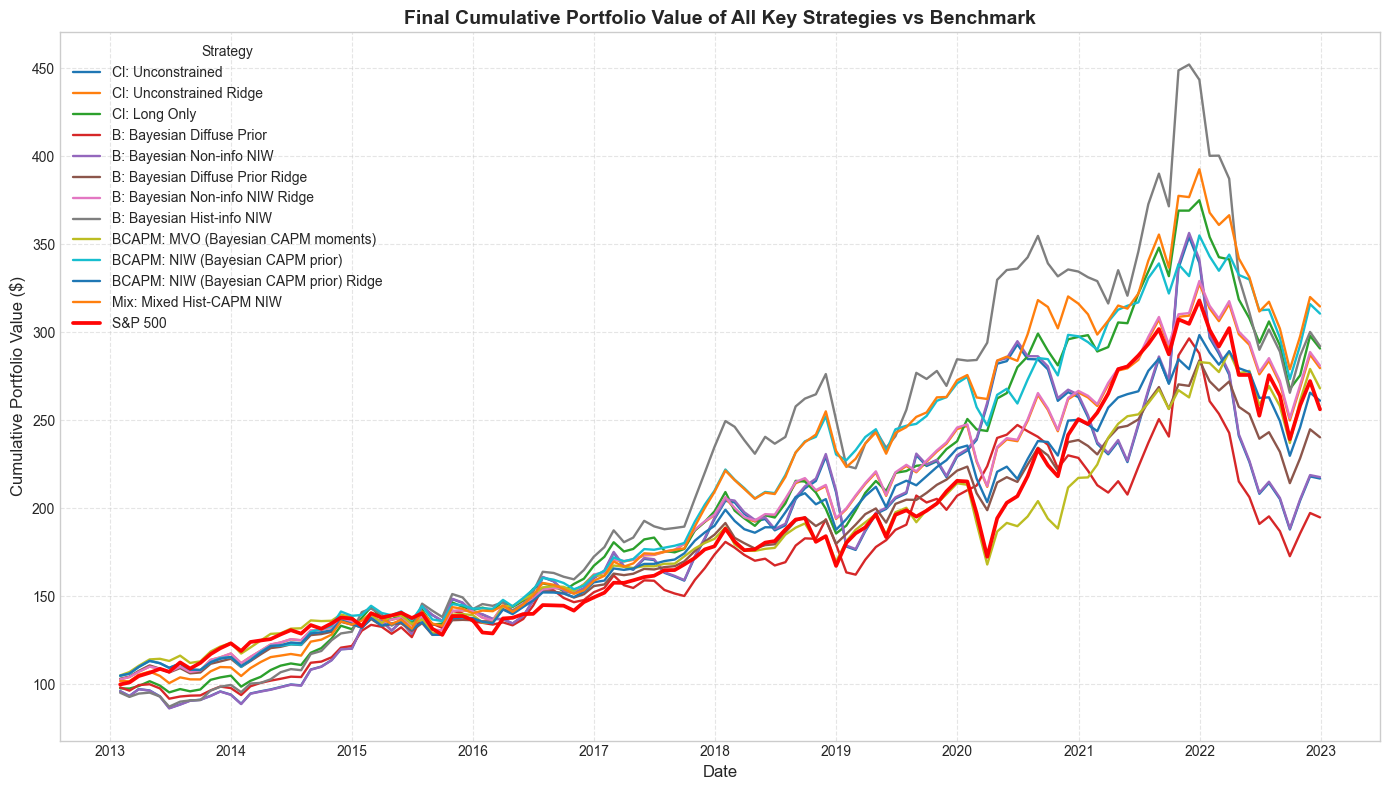

In [22]:
# --- Grand Comparison of Cumulative Returns ---
print("--- Section 11: Final Summary & Comparison of All Strategies ---")
final_cum_returns_dict = {}
if 'classical_cumulative_returns_collection' in locals():
    for k in ["Unconstrained", "Unconstrained Ridge", "Long Only"]:
        if k in classical_cumulative_returns_collection: final_cum_returns_dict[f"Cl: {k}"] = classical_cumulative_returns_collection[k]
if 'bayesian_cumulative_returns_collection' in locals():
    for k in ["Bayesian Diffuse Prior", "Bayesian Non-info NIW", "Bayesian Diffuse Prior Ridge", "Bayesian Non-info NIW Ridge", "Bayesian Hist-info NIW"]:
        if k in bayesian_cumulative_returns_collection: final_cum_returns_dict[f"B: {k}"] = bayesian_cumulative_returns_collection[k]
if 'bayesian_capm_cumulative_returns_collection' in locals():
    for k in bayesian_capm_cumulative_returns_collection: final_cum_returns_dict[f"BCAPM: {k}"] = bayesian_capm_cumulative_returns_collection[k]
if 'mixed_strategy_cumulative_returns_collection' in locals():
    for k_mixed in mixed_strategy_cumulative_returns_collection: 
        final_cum_returns_dict[f"Mix: {k_mixed}"] = mixed_strategy_cumulative_returns_collection[k_mixed]

if final_cum_returns_dict:
    plotting_utils.plot_strategy_cumulative_returns_comparison(
        final_cum_returns_dict,
        benchmark_series=benchmark_cum_total_for_plot_classical if 'benchmark_cum_total_for_plot_classical' in locals() else None,
        benchmark_label="S&P 500", title="Final Cumulative Portfolio Value of All Key Strategies vs Benchmark",
        figsize=(14, 8), output_path=os.path.join(PLOTS_DIR, "cumulative_returns_all_strategies_summary.png")
    )
else: print("No data for final cumulative returns plot.")

Final cumulative returns comparison across all key strategies.


Final Grand Summary Table of All Strategies (Metrics):


Total Cumulative Return (Total)  \
Cl: Unconstrained                                                1.1697   
Cl: Unconstrained Ridge                                          1.7967   
Cl: Long Only                                                    1.9085   
B: Bayesian Diffuse Prior                                        0.9490   
B: Bayesian Non-info NIW                                         1.1778   
B: Bayesian Diffuse Prior Ridge                                  1.4040   
B: Bayesian Non-info NIW Ridge                                   1.8107   
B: Bayesian Hist-info NIW                                        1.9216   
BCAPM: MVO (Bayesian CAPM moments)                               1.6817   
BCAPM: NIW (Bayesian CAPM prior)                                 2.1067   
BCAPM: NIW (Bayesian CAPM prior) Ridge                           1.6120   
Mix: Mixed Hist-CAPM NIW                                         2.1473   
S&P 500                                                          1.6921   

                                        Mean Monthly Return (Excess)  \
Cl: Unconstrained                                             0.0074   
Cl: Unconstrained Ridge                                       0.0087   
Cl: Long Only                                                 0.0090   
B: Bayesian Diffuse Prior                                     0.0059   
B: Bayesian Non-info NIW                                      0.0075   
B: Bayesian Diffuse Prior Ridge                               0.0073   
B: Bayesian Non-info NIW Ridge                                0.0087   
B: Bayesian Hist-info NIW                                     0.0096   
BCAPM: MVO (Bayesian CAPM moments)                            0.0085   
BCAPM: NIW (Bayesian CAPM prior)                              0.0095   
BCAPM: NIW (Bayesian CAPM prior) Ridge                        0.0080   
Mix: Mixed Hist-CAPM NIW                                      0.0097   
S&P 500                                                       0.0086   

                                        Volatility (Monthly Std, Excess)  \
Cl: Unconstrained                                                 0.0554   
Cl: Unconstrained Ridge                                           0.0361   
Cl: Long Only                                                     0.0372   
B: Bayesian Diffuse Prior                                         0.0439   
B: Bayesian Non-info NIW                                          0.0558   
B: Bayesian Diffuse Prior Ridge                                   0.0316   
B: Bayesian Non-info NIW Ridge                                    0.0363   
B: Bayesian Hist-info NIW                                         0.0501   
BCAPM: MVO (Bayesian CAPM moments)                                0.0401   
BCAPM: NIW (Bayesian CAPM prior)                                  0.0352   
BCAPM: NIW (Bayesian CAPM prior) Ridge                            0.0346   
Mix: Mixed Hist-CAPM NIW                                          0.0377   
S&P 500                                                           0.0427   

                                        Annualized Sharpe Ratio (Excess)  \
Cl: Unconstrained                                                 0.4628   
Cl: Unconstrained Ridge                                           0.8319   
Cl: Long Only                                                     0.8420   
B: Bayesian Diffuse Prior                                         0.4690   
B: Bayesian Non-info NIW                                          0.4625   
B: Bayesian Diffuse Prior Ridge                                   0.7945   
B: Bayesian Non-info NIW Ridge                                    0.8325   
B: Bayesian Hist-info NIW                                         0.6653   
BCAPM: MVO (Bayesian CAPM moments)                                0.7319   
BCAPM: NIW (Bayesian CAPM prior)                                  0.9364   
BCAPM: NIW (Bayesian CAPM prior) Ridge                            0.8049   
Mix

Plot saved to plots_output/metrics_comparison_all_strategies_summary.png


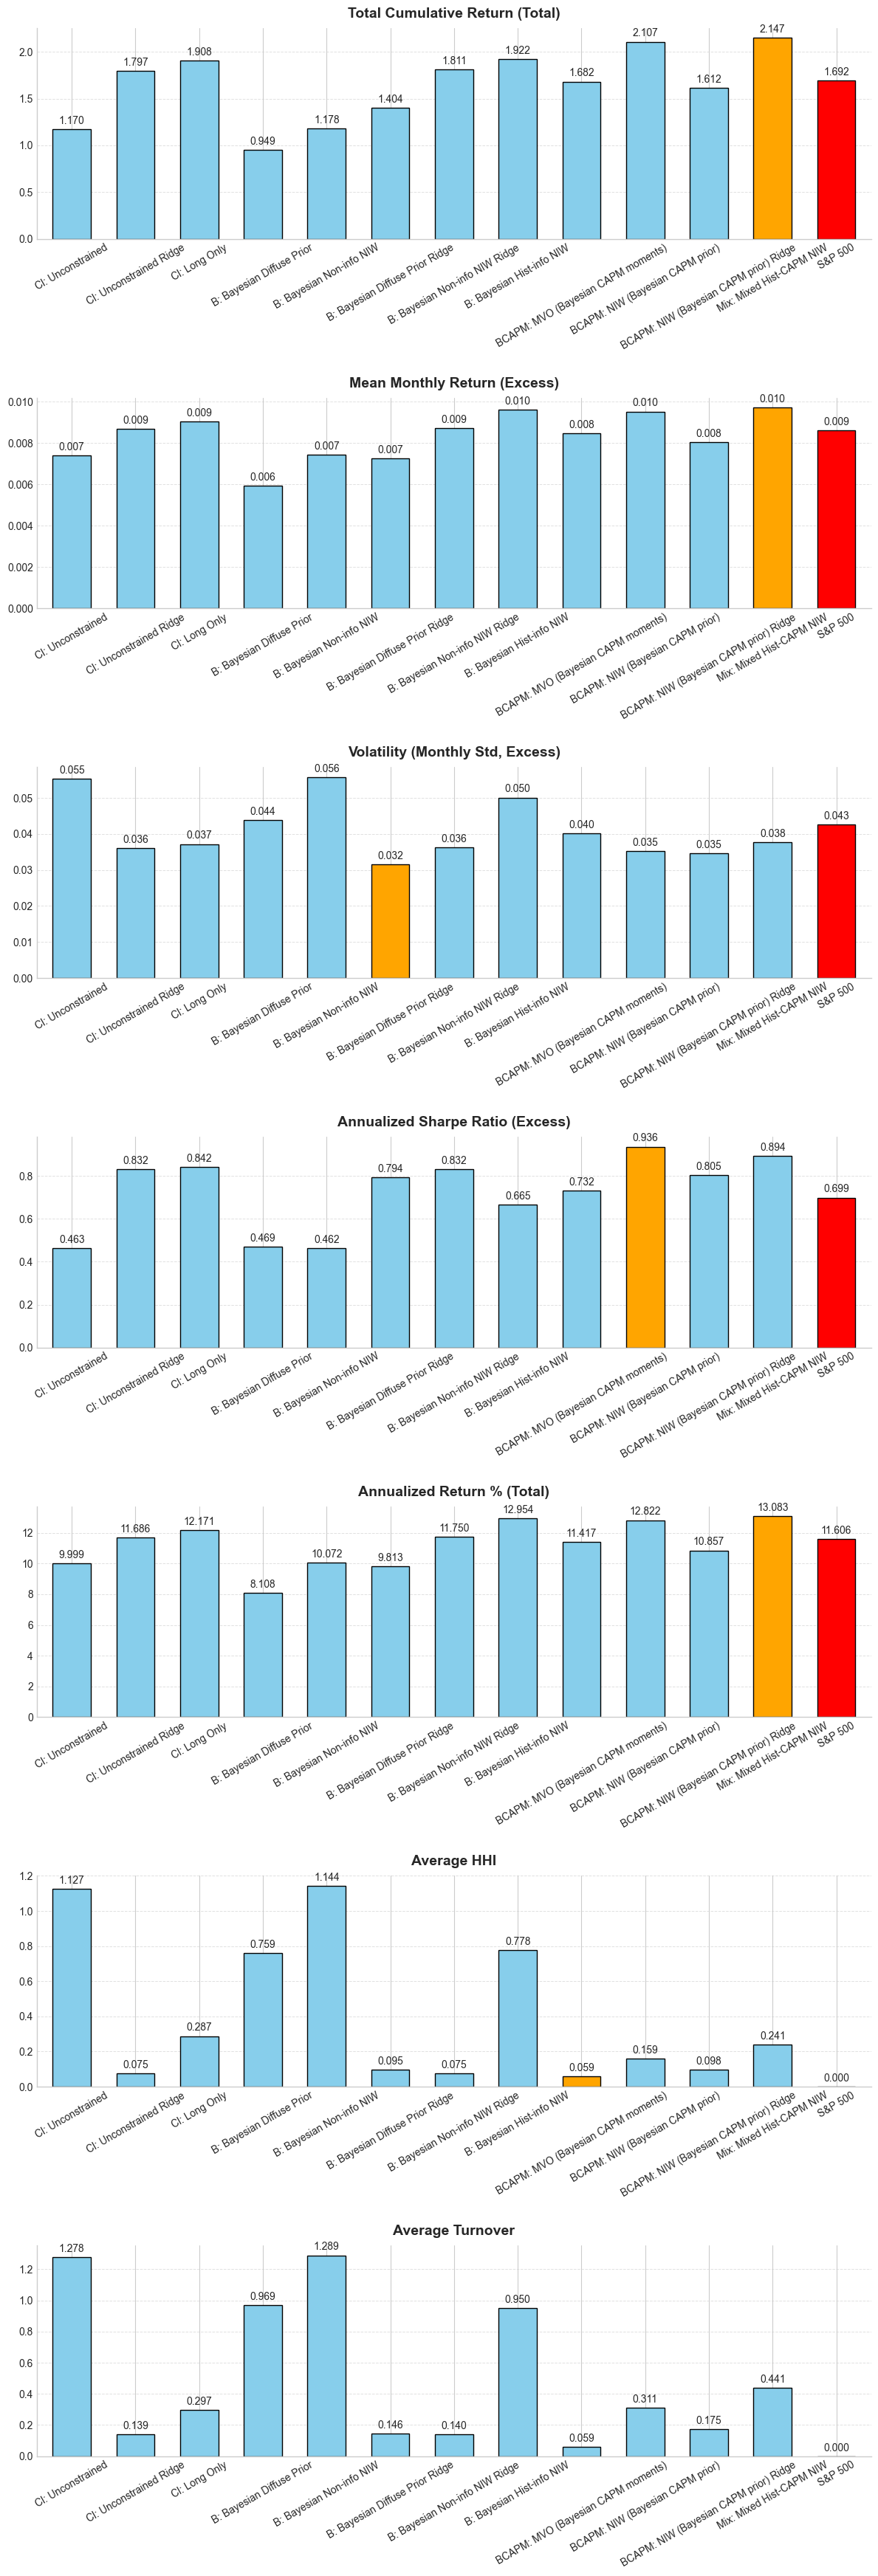

In [23]:
# --- Grand Comparison of Performance Metrics ---
all_summaries_list_final = []
if 'classical_results_collection' in locals():
    for name, df_s in classical_results_collection.items(): all_summaries_list_final.append(df_s.assign(Strategy=f"Cl: {name}"))
if 'bayesian_results_collection' in locals():
    for name, df_s in bayesian_results_collection.items(): all_summaries_list_final.append(df_s.assign(Strategy=f"B: {name}"))
if 'bayesian_capm_results_collection' in locals():
    for name, df_s in bayesian_capm_results_collection.items(): all_summaries_list_final.append(df_s.assign(Strategy=f"BCAPM: {name}"))
if 'mixed_strategy_results_collection' in locals():
    for name_mixed, df_s_mixed in mixed_strategy_results_collection.items(): 
        all_summaries_list_final.append(df_s_mixed.assign(Strategy=f"Mix: {name_mixed}"))

grand_summary_table_df_final = pd.DataFrame()
if all_summaries_list_final:
    grand_summary_table_df_final = pd.concat(all_summaries_list_final).set_index("Strategy")
    if 'benchmark_summary_for_plot_classical_metrics' in locals() and benchmark_summary_for_plot_classical_metrics is not None:
        grand_summary_table_df_final = pd.concat([grand_summary_table_df_final, benchmark_summary_for_plot_classical_metrics])
    if not grand_summary_table_df_final.empty:
        print("\nFinal Grand Summary Table of All Strategies (Metrics):")
        display(grand_summary_table_df_final.round(4))
        grand_summary_table_df_final.to_csv(os.path.join(RESULTS_DIR, "grand_summary_all_strategies_metrics.csv"))
        if 'metrics_to_plot_list' in locals() and 'maximize_metrics_set' in locals():
            for metric in metrics_to_plot_list: 
                if metric not in grand_summary_table_df_final.columns: grand_summary_table_df_final[metric] = np.nan
            plotting_utils.plot_strategy_metrics_comparison_bar(
                grand_summary_table_df_final, metrics_to_plot=metrics_to_plot_list, 
                benchmark_name="S&P 500", maximize_metrics=maximize_metrics_set,
                figsize_per_metric=(12, 5),
                output_path=os.path.join(PLOTS_DIR, "metrics_comparison_all_strategies_summary.png")
            )
    else: print("No summary data for final metrics table/plot.")
else: print("No results for final summary table.")

Final consolidated table and plot comparing key metrics across all strategies.

## 12. Comprehensive Comparison and Conclusion
*(This section is intended for qualitative discussion based on the generated results, as per user request. Specific statistical and financial explanations would be filled in here after observing all outputs.)*

**Overall Performance Summary:**
*(Placeholder: Discuss which types of strategies (Classical, Bayesian Non-CAPM, Bayesian CAPM-based) generally performed better in terms of cumulative returns, Sharpe ratio, etc. Note any standout individual strategies.)*

**Impact of Bayesian Approaches:**
-   **Parameter Estimation:** Bayesian methods aim to address the "estimation error" problem in classical MVO by incorporating prior beliefs and/or modeling parameter uncertainty. The diffuse prior approach represents a baseline for Bayesian models by formally accounting for uncertainty without strong prior views. Conjugate NIW priors allow for more structured beliefs about mean and covariance. The Bayesian CAPM imposes a factor structure.
-   **Efficient Frontiers:** We observed that Bayesian efficient frontiers (especially diffuse prior) were generally shifted compared to the classical frontier, often to the right (implying higher perceived risk for a given level of return, or lower return for a given level of risk). This reflects the incorporation of parameter uncertainty. The location and shape of history-informed or CAPM-informed Bayesian frontiers depend on the quality and impact of that prior information.
-   **Backtested Performance:** *(Placeholder: Discuss if Bayesian strategies led to more stable weights, lower turnover, better out-of-sample risk control, or improved risk-adjusted returns compared to classical MVO. Did incorporating prior information (historical or CAPM-based) consistently help?)*

**Effect of Regularization (Ridge):**
*(Placeholder: Discuss how Ridge regularization (L2 penalty) affected portfolio weights (typically by shrinking them and reducing extremes) and whether it consistently improved out-of-sample performance or stability for the strategies where it was applied.)*

**Portfolio Characteristics:**
-   **Concentration (HHI):** Lower HHI values suggest more diversified portfolios. *(Placeholder: Compare HHI across strategies.)*
-   **Turnover:** High turnover implies higher transaction costs. *(Placeholder: Compare turnover and discuss if certain approaches (e.g., Bayesian shrinkage) led to lower turnover.)*

**Financial Implications & Recommendations:**
*(Placeholder: Based on the results, what are the practical takeaways for an investor or portfolio manager? 
- Are Bayesian methods worth the additional complexity? 
- Under what conditions might specific Bayesian approaches be preferred? 
- How does parameter sensitivity, as observed earlier, relate to the performance of these more advanced models?
- Limitations of the analysis (e.g., specific dataset, period, types of priors chosen).)*

**Further Research:**
*(Placeholder: Suggest potential areas for further investigation, e.g., different types of priors, more sophisticated Bayesian models (like Black-Litterman), alternative risk measures, impact of transaction costs, different data frequencies or asset classes.)*

This concluding qualitative analysis would typically be filled in after a thorough review of all generated plots and quantitative results.

In [24]:
print("--- MVO Analysis Notebook Complete ---")
print(f"All plots saved to: {os.path.abspath(PLOTS_DIR)}")
print(f"All CSV results saved to: {os.path.abspath(RESULTS_DIR)}")

--- MVO Analysis Notebook Complete ---
All plots saved to: /Users/andreavento/Documents/Tesi/Thesis/Code/plots_output
All CSV results saved to: /Users/andreavento/Documents/Tesi/Thesis/Code/results_output
